First 5 rows with calculated probabilities:
        commence_time  spread  home_moneyline_fair_prob  \
0 2023-03-30 17:05:00     1.5                  0.299838   
1 2023-03-30 17:05:00    -1.5                  0.622019   
2 2023-03-30 18:10:00    -1.5                  0.542744   
3 2023-03-30 18:20:00     1.5                  0.425766   
4 2023-03-30 19:10:00    -1.5                  0.669007   

   home_spread_adjusted_prob  home_prob_diff_pct  away_moneyline_fair_prob  \
0                  -7.535624         -783.546191                  0.700162   
1                  17.478543         1685.652470                  0.377981   
2                  15.179563         1463.681909                  0.457256   
3                 -10.935674        -1136.143936                  0.574234   
4                  18.841204         1817.219659                  0.330993   

   away_spread_adjusted_prob  away_prob_diff_pct  home_win  away_win  \
0                  19.744700         1904.453809     False  

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


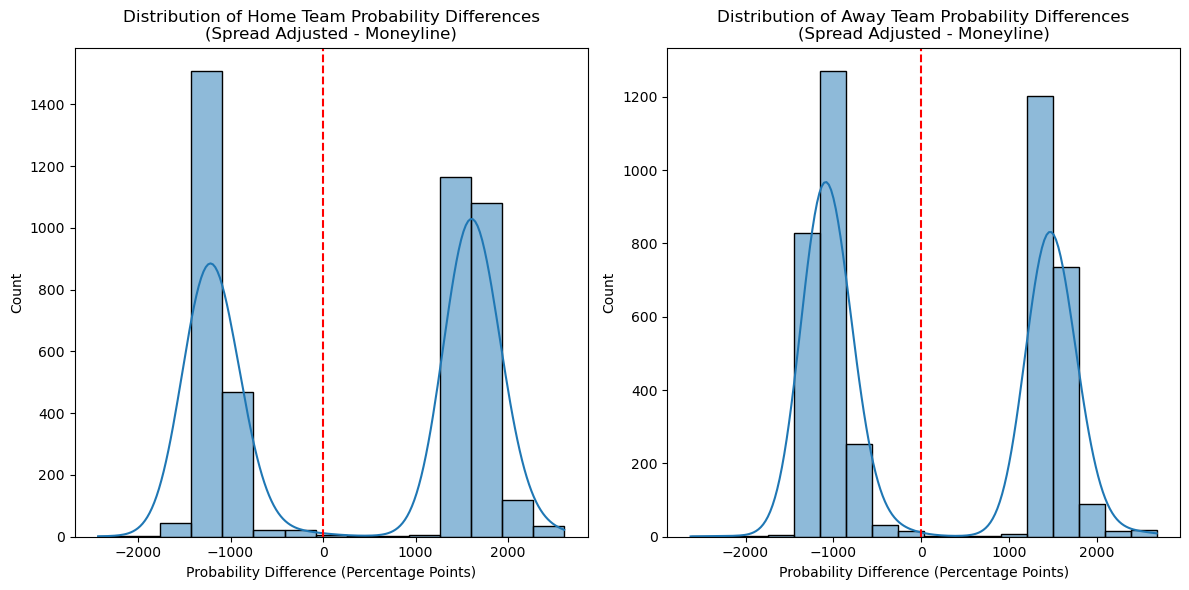

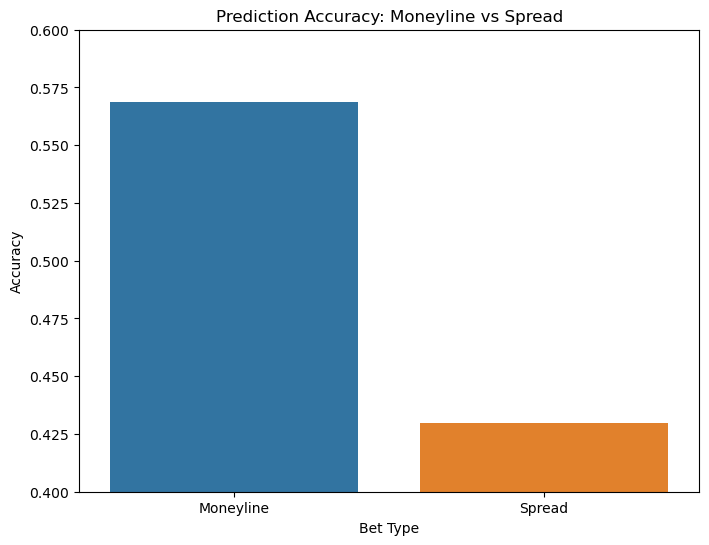


Accuracy by spread group:
              moneyline_prediction_correct  spread_prediction_correct
spread_group                                                         
(0.0, 1.0]                        0.800000                   0.600000
(1.0, 1.5]                        0.563012                   0.427889
(1.5, 2.0]                        1.000000                   1.000000
(2.0, 2.5]                        0.878049                   0.560976
(2.5, 3.0]                             NaN                        NaN
(3.0, 10.0]                       0.846154                   0.461538


/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_96257/1745003219.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spread_group_accuracy = df.groupby('spread_group')[['moneyline_prediction_correct', 'spread_prediction_correct']].mean()


<Figure size 1000x600 with 0 Axes>

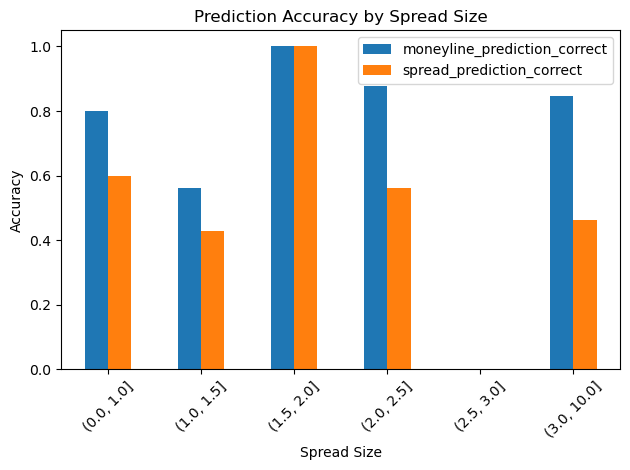


Bet advantage counts:
bet_advantage
Equal        3491
Moneyline     807
Spread        184
Name: count, dtype: int64


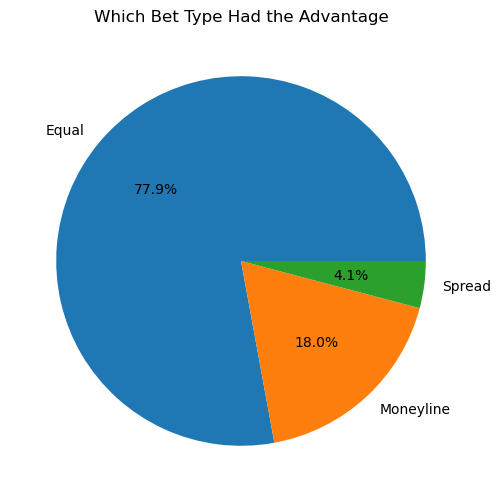


Games with extreme probability differences (>10 percentage points):
Home team extreme differences: 4481 games
Away team extreme differences: 4482 games

Extreme home team differences:
Home covers when spread prob much higher: 0.4223
Home wins when moneyline prob much higher: 0.4424

Extreme away team differences:
Away covers when spread prob much higher: 0.4383
Away wins when moneyline prob much higher: 0.4136


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('documents/Result_33.csv')

# Convert date column to datetime
df['commence_time'] = pd.to_datetime(df['commence_time'])

# Function to calculate implied probability from money line odds
def calc_implied_prob_moneyline(odds):
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return abs(odds) / (abs(odds) + 100)

# Function to calculate implied probability from spread odds (using your formula)
def calc_implied_prob_spread(original_prob, spread):
    # Subtract 2% from original probability
    adjusted_prob = original_prob - 0.02  
    
    # Multiply by 28 (conversion factor)
    conversion = adjusted_prob * 28
    
    # Add or subtract based on spread direction
    if spread < 0:  # Home team favored
        return original_prob + conversion
    else:  # Away team favored
        return original_prob - conversion

# Calculate implied probabilities for money lines
df['home_moneyline_implied_prob'] = df['home_money_line_odds'].apply(calc_implied_prob_moneyline)
df['away_moneyline_implied_prob'] = df['away_money_line_odds'].apply(calc_implied_prob_moneyline)

# Calculate the "fair" total implied probability without vig
df['total_implied_prob'] = df['home_moneyline_implied_prob'] + df['away_moneyline_implied_prob']
df['vig_factor'] = 1 / df['total_implied_prob']

# Normalize moneyline probabilities to remove the vig
df['home_moneyline_fair_prob'] = df['home_moneyline_implied_prob'] * df['vig_factor']
df['away_moneyline_fair_prob'] = df['away_moneyline_implied_prob'] * df['vig_factor']

# Calculate spread-based probabilities
# First, calculate implied probabilities from spread odds
df['home_spread_implied_prob'] = df['home_spread_odds'].apply(calc_implied_prob_moneyline)
df['away_spread_implied_prob'] = df['away_spread_odds'].apply(calc_implied_prob_moneyline)

# Apply the adjustment formula to get the adjusted probabilities
df['home_spread_adjusted_prob'] = df.apply(
    lambda row: calc_implied_prob_spread(row['home_moneyline_fair_prob'], row['spread']), axis=1)
df['away_spread_adjusted_prob'] = df.apply(
    lambda row: calc_implied_prob_spread(row['away_moneyline_fair_prob'], -row['spread']), axis=1)

# Calculate the differences between moneyline and spread adjusted probabilities (in percentage points)
df['home_prob_diff_pct'] = (df['home_spread_adjusted_prob'] - df['home_moneyline_fair_prob']) * 100
df['away_prob_diff_pct'] = (df['away_spread_adjusted_prob'] - df['away_moneyline_fair_prob']) * 100

# Calculate actual outcomes (who won)
df['home_win'] = df['home_score'] > df['away_score']
df['away_win'] = df['away_score'] > df['home_score']

# Calculate whether the spread was covered
df['home_covered_spread'] = (df['home_score'] - df['away_score']) > -df['spread']
df['away_covered_spread'] = (df['away_score'] - df['home_score']) > df['spread']

# Display the first few rows with calculated values
print("First 5 rows with calculated probabilities:")
columns_to_show = ['commence_time', 'spread', 
                   'home_moneyline_fair_prob', 'home_spread_adjusted_prob', 'home_prob_diff_pct',
                   'away_moneyline_fair_prob', 'away_spread_adjusted_prob', 'away_prob_diff_pct',
                   'home_win', 'away_win', 'home_covered_spread', 'away_covered_spread']
print(df[columns_to_show].head())

# Basic statistics on the probability differences
print("\nSummary statistics for probability differences (percentage points):")
print(df[['home_prob_diff_pct', 'away_prob_diff_pct']].describe())

# Analyze which bet type was more accurate
# For moneyline: did team with higher moneyline probability win?
df['moneyline_prediction_correct'] = (
    ((df['home_moneyline_fair_prob'] > df['away_moneyline_fair_prob']) & df['home_win']) | 
    ((df['away_moneyline_fair_prob'] > df['home_moneyline_fair_prob']) & df['away_win'])
)

# For spread: did team with higher spread-adjusted probability cover the spread?
df['spread_prediction_correct'] = (
    ((df['home_spread_adjusted_prob'] > df['away_spread_adjusted_prob']) & df['home_covered_spread']) | 
    ((df['away_spread_adjusted_prob'] > df['home_spread_adjusted_prob']) & df['away_covered_spread'])
)

# Calculate accuracy rates
moneyline_accuracy = df['moneyline_prediction_correct'].mean()
spread_accuracy = df['spread_prediction_correct'].mean()

print(f"\nMoneyline prediction accuracy: {moneyline_accuracy:.4f}")
print(f"Spread prediction accuracy: {spread_accuracy:.4f}")

# Additional analysis: Check for patterns based on probability differences
print("\nAccuracy when spread probability is higher than moneyline probability:")
home_higher_spread = df[df['home_prob_diff_pct'] > 0]['home_covered_spread'].mean()
away_higher_spread = df[df['away_prob_diff_pct'] > 0]['away_covered_spread'].mean()
print(f"Home team covers when spread probability > moneyline: {home_higher_spread:.4f}")
print(f"Away team covers when spread probability > moneyline: {away_higher_spread:.4f}")

print("\nAccuracy when moneyline probability is higher than spread probability:")
home_higher_ml = df[df['home_prob_diff_pct'] < 0]['home_win'].mean()
away_higher_ml = df[df['away_prob_diff_pct'] < 0]['away_win'].mean()
print(f"Home team wins when moneyline probability > spread: {home_higher_ml:.4f}")
print(f"Away team wins when moneyline probability > spread: {away_higher_ml:.4f}")

# Visualize the distribution of probability differences
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['home_prob_diff_pct'], kde=True)
plt.title('Distribution of Home Team Probability Differences\n(Spread Adjusted - Moneyline)')
plt.xlabel('Probability Difference (Percentage Points)')
plt.axvline(x=0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
sns.histplot(df['away_prob_diff_pct'], kde=True)
plt.title('Distribution of Away Team Probability Differences\n(Spread Adjusted - Moneyline)')
plt.xlabel('Probability Difference (Percentage Points)')
plt.axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Visualize accuracy comparison
plt.figure(figsize=(8, 6))
accuracy_df = pd.DataFrame({
    'Bet Type': ['Moneyline', 'Spread'],
    'Accuracy': [moneyline_accuracy, spread_accuracy]
})
sns.barplot(x='Bet Type', y='Accuracy', data=accuracy_df)
plt.title('Prediction Accuracy: Moneyline vs Spread')
plt.ylim(0.4, 0.6)
plt.show()

# Additional analysis: Check if there's a pattern based on spread size
df['abs_spread'] = df['spread'].abs()
spread_bins = [0, 1, 1.5, 2, 2.5, 3, 10]
df['spread_group'] = pd.cut(df['abs_spread'], bins=spread_bins)

# Calculate accuracy by spread group
spread_group_accuracy = df.groupby('spread_group')[['moneyline_prediction_correct', 'spread_prediction_correct']].mean()
print("\nAccuracy by spread group:")
print(spread_group_accuracy)

plt.figure(figsize=(10, 6))
spread_group_accuracy.plot(kind='bar')
plt.title('Prediction Accuracy by Spread Size')
plt.xlabel('Spread Size')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check where the biggest advantages are
df['bet_advantage'] = np.where(
    df['spread_prediction_correct'] & ~df['moneyline_prediction_correct'], 'Spread',
    np.where(df['moneyline_prediction_correct'] & ~df['spread_prediction_correct'], 'Moneyline', 'Equal')
)

advantage_counts = df['bet_advantage'].value_counts()
print("\nBet advantage counts:")
print(advantage_counts)

plt.figure(figsize=(8, 6))
advantage_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Which Bet Type Had the Advantage')
plt.ylabel('')
plt.show()

# Additional analysis: Look at the extreme differences
extreme_diff_threshold = 10  # 10 percentage points difference
df_extreme_home = df[df['home_prob_diff_pct'].abs() > extreme_diff_threshold]
df_extreme_away = df[df['away_prob_diff_pct'].abs() > extreme_diff_threshold]

print(f"\nGames with extreme probability differences (>{extreme_diff_threshold} percentage points):")
print(f"Home team extreme differences: {len(df_extreme_home)} games")
print(f"Away team extreme differences: {len(df_extreme_away)} games")

# For extreme home differences
if len(df_extreme_home) > 0:
    home_extreme_higher_spread = df_extreme_home[df_extreme_home['home_prob_diff_pct'] > 0]['home_covered_spread'].mean()
    home_extreme_higher_ml = df_extreme_home[df_extreme_home['home_prob_diff_pct'] < 0]['home_win'].mean()
    
    print("\nExtreme home team differences:")
    print(f"Home covers when spread prob much higher: {home_extreme_higher_spread:.4f}")
    print(f"Home wins when moneyline prob much higher: {home_extreme_higher_ml:.4f}")

# For extreme away differences
if len(df_extreme_away) > 0:
    away_extreme_higher_spread = df_extreme_away[df_extreme_away['away_prob_diff_pct'] > 0]['away_covered_spread'].mean()
    away_extreme_higher_ml = df_extreme_away[df_extreme_away['away_prob_diff_pct'] < 0]['away_win'].mean()
    
    print("\nExtreme away team differences:")
    print(f"Away covers when spread prob much higher: {away_extreme_higher_spread:.4f}")
    print(f"Away wins when moneyline prob much higher: {away_extreme_higher_ml:.4f}")

First 5 rows with calculated probabilities:
        commence_time  spread  home_moneyline_fair_prob  \
0 2023-03-30 17:05:00     1.5                  0.299838   
1 2023-03-30 17:05:00    -1.5                  0.622019   
2 2023-03-30 18:10:00    -1.5                  0.542744   
3 2023-03-30 18:20:00     1.5                  0.425766   
4 2023-03-30 19:10:00    -1.5                  0.669007   

   home_spread_adjusted_prob  home_prob_diff_pct  away_moneyline_fair_prob  \
0                  -7.535624         -783.546191                  0.700162   
1                  17.478543         1685.652470                  0.377981   
2                  15.179563         1463.681909                  0.457256   
3                 -10.935674        -1136.143936                  0.574234   
4                  18.841204         1817.219659                  0.330993   

   away_spread_adjusted_prob  away_prob_diff_pct  home_win  away_win  \
0                  19.744700         1904.453809     False  

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


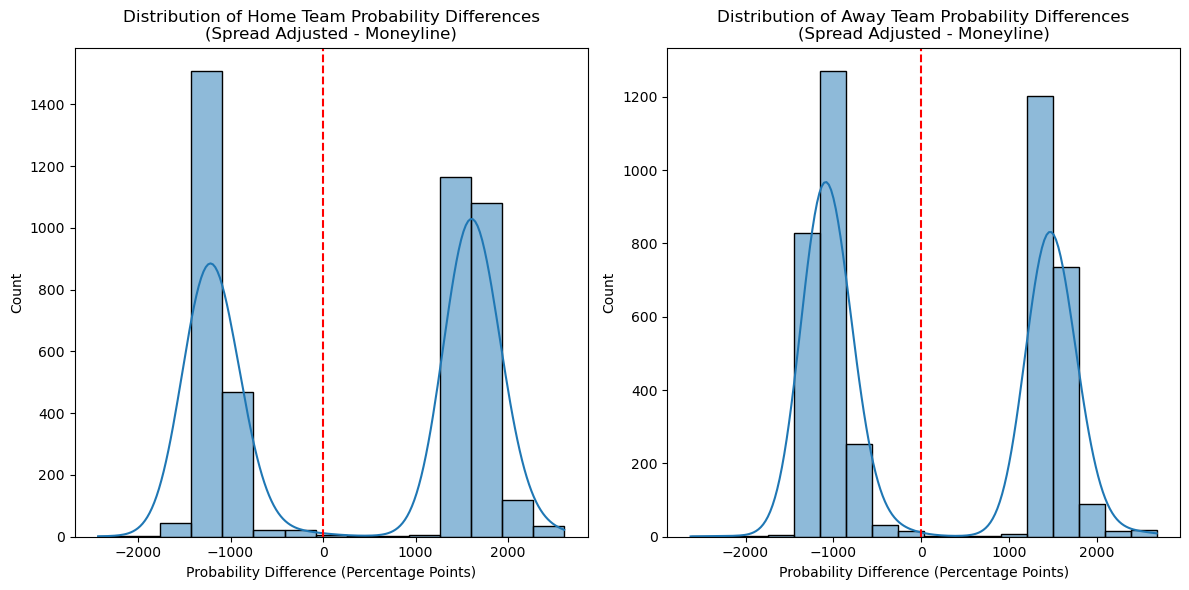

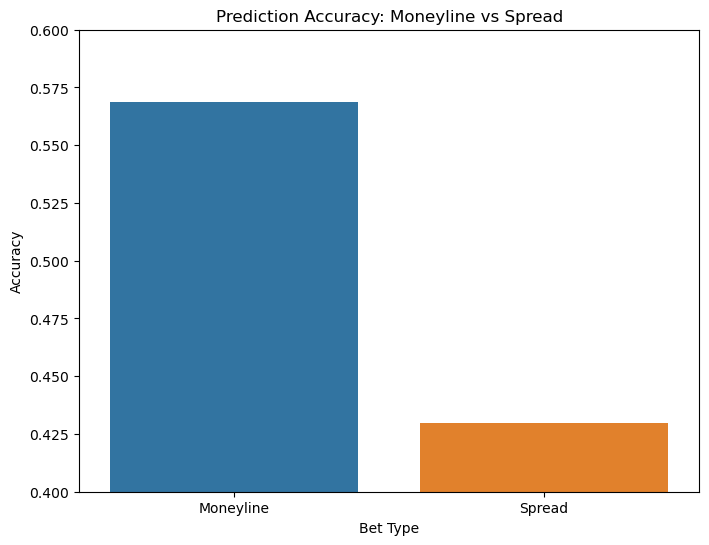


Accuracy by spread group:
              moneyline_prediction_correct  spread_prediction_correct
spread_group                                                         
(0.0, 1.0]                        0.800000                   0.600000
(1.0, 1.5]                        0.563012                   0.427889
(1.5, 2.0]                        1.000000                   1.000000
(2.0, 2.5]                        0.878049                   0.560976
(2.5, 3.0]                             NaN                        NaN
(3.0, 10.0]                       0.846154                   0.461538


/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_96257/1659016220.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spread_group_accuracy = df.groupby('spread_group')[['moneyline_prediction_correct', 'spread_prediction_correct']].mean()


<Figure size 1000x600 with 0 Axes>

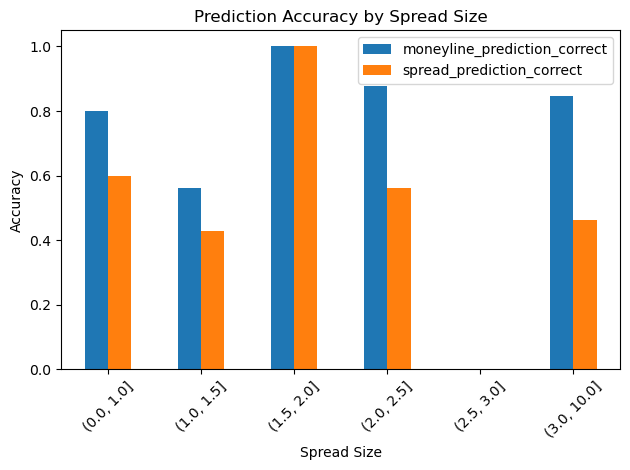


Bet advantage counts:
bet_advantage
Equal        3491
Moneyline     807
Spread        184
Name: count, dtype: int64


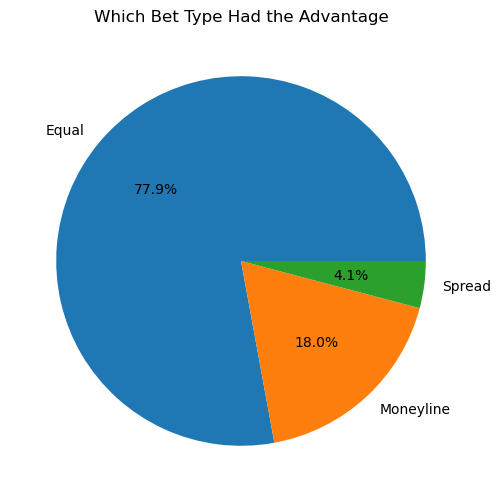

/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_96257/1659016220.py:216: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  home_avg_diff = df_money_range[home_in_range]['home_prob_diff_pct'].mean() if any(home_in_range) else 0
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_96257/1659016220.py:217: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  away_avg_diff = df_money_range[away_in_range]['away_prob_diff_pct'].mean() if any(away_in_range) else 0
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_96257/1659016220.py:225: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  home_ml_accuracy = df_money_range[home_in_range]['home_win'].mean()
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_96257/1659016220.py:226: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  home_spread_accuracy = df_money_range[home_in_range]['home_covered_spread'].


Games with extreme probability differences (>10 percentage points):
Home team extreme differences: 4481 games
Away team extreme differences: 4482 games

Extreme home team differences:
Home covers when spread prob much higher: 0.4223
Home wins when moneyline prob much higher: 0.4424

Extreme away team differences:
Away covers when spread prob much higher: 0.4383
Away wins when moneyline prob much higher: 0.4136

--- Analysis of games with money lines between +150 and +200 ---
Number of games with money lines between +150 and +200: 848

Average probability differences (percentage points) in +150 to +200 range:
Home teams: -937.74
Away teams: -928.38

Betting accuracy for teams with money line between +150 and +200:
Home teams moneyline accuracy: 0.3992
Home teams spread accuracy: 0.5099
Away teams moneyline accuracy: 0.3916
Away teams spread accuracy: 0.5210

Expected Value (EV) per $1 bet:
Home teams moneyline EV: $0.0978
Home teams spread EV: $-0.0261
Away teams moneyline EV: $0.0769


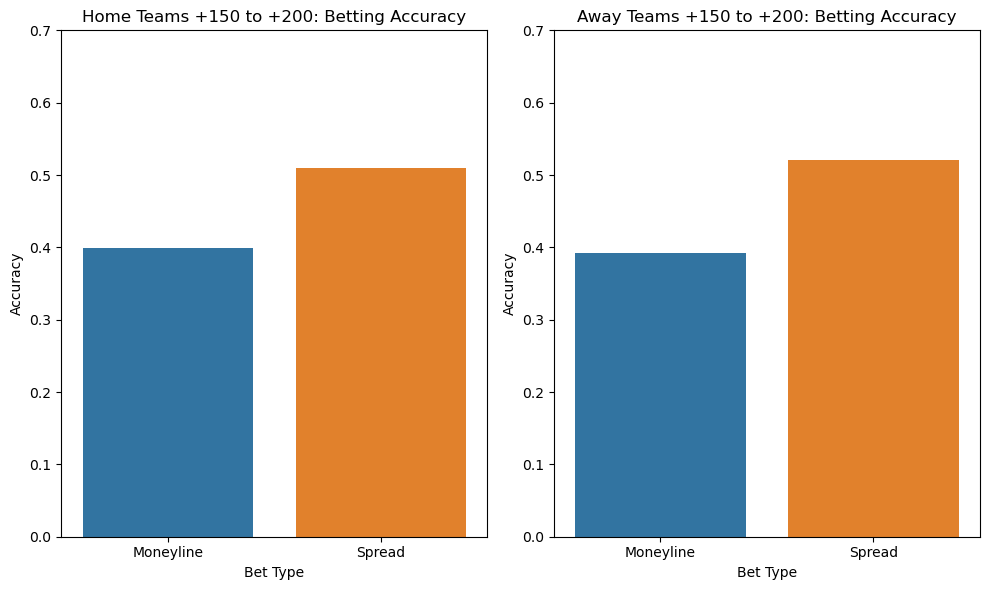

/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_96257/1659016220.py:294: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_money_range[home_in_range]['home_prob_diff_pct'],
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_96257/1659016220.py:295: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_money_range[home_in_range]['home_covered_spread'].astype(int),
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_96257/1659016220.py:308: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_money_range[away_in_range]['away_prob_diff_pct'],
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_96257/1659016220.py:309: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_money_range[away_in_range]['away_covered_spread'].astype(int),


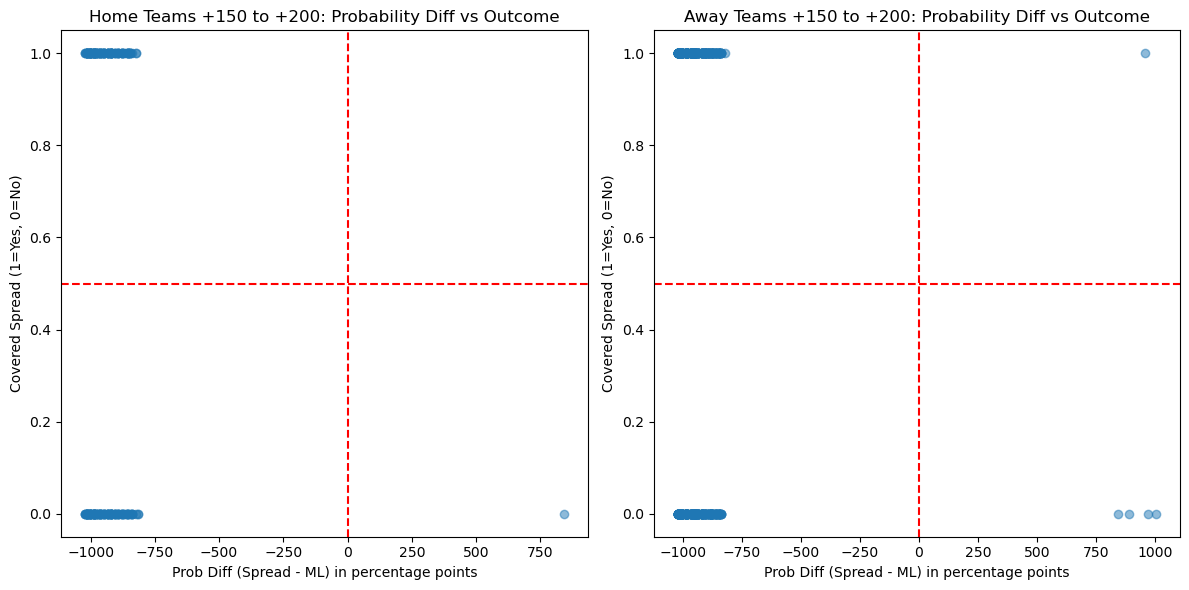

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('documents/Result_33.csv')

# Convert date column to datetime
df['commence_time'] = pd.to_datetime(df['commence_time'])

# Function to calculate implied probability from money line odds
def calc_implied_prob_moneyline(odds):
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return abs(odds) / (abs(odds) + 100)

# Function to calculate implied probability from spread odds (using your formula)
def calc_implied_prob_spread(original_prob, spread):
    # Subtract 2% from original probability
    adjusted_prob = original_prob - 0.02  
    
    # Multiply by 28 (conversion factor)
    conversion = adjusted_prob * 28
    
    # Add or subtract based on spread direction
    if spread < 0:  # Home team favored
        return original_prob + conversion
    else:  # Away team favored
        return original_prob - conversion

# Calculate implied probabilities for money lines
df['home_moneyline_implied_prob'] = df['home_money_line_odds'].apply(calc_implied_prob_moneyline)
df['away_moneyline_implied_prob'] = df['away_money_line_odds'].apply(calc_implied_prob_moneyline)

# Calculate the "fair" total implied probability without vig
df['total_implied_prob'] = df['home_moneyline_implied_prob'] + df['away_moneyline_implied_prob']
df['vig_factor'] = 1 / df['total_implied_prob']

# Normalize moneyline probabilities to remove the vig
df['home_moneyline_fair_prob'] = df['home_moneyline_implied_prob'] * df['vig_factor']
df['away_moneyline_fair_prob'] = df['away_moneyline_implied_prob'] * df['vig_factor']

# Calculate spread-based probabilities
# First, calculate implied probabilities from spread odds
df['home_spread_implied_prob'] = df['home_spread_odds'].apply(calc_implied_prob_moneyline)
df['away_spread_implied_prob'] = df['away_spread_odds'].apply(calc_implied_prob_moneyline)

# Apply the adjustment formula to get the adjusted probabilities
df['home_spread_adjusted_prob'] = df.apply(
    lambda row: calc_implied_prob_spread(row['home_moneyline_fair_prob'], row['spread']), axis=1)
df['away_spread_adjusted_prob'] = df.apply(
    lambda row: calc_implied_prob_spread(row['away_moneyline_fair_prob'], -row['spread']), axis=1)

# Calculate the differences between moneyline and spread adjusted probabilities (in percentage points)
df['home_prob_diff_pct'] = (df['home_spread_adjusted_prob'] - df['home_moneyline_fair_prob']) * 100
df['away_prob_diff_pct'] = (df['away_spread_adjusted_prob'] - df['away_moneyline_fair_prob']) * 100

# Calculate actual outcomes (who won)
df['home_win'] = df['home_score'] > df['away_score']
df['away_win'] = df['away_score'] > df['home_score']

# Calculate whether the spread was covered
df['home_covered_spread'] = (df['home_score'] - df['away_score']) > -df['spread']
df['away_covered_spread'] = (df['away_score'] - df['home_score']) > df['spread']

# Display the first few rows with calculated values
print("First 5 rows with calculated probabilities:")
columns_to_show = ['commence_time', 'spread', 
                   'home_moneyline_fair_prob', 'home_spread_adjusted_prob', 'home_prob_diff_pct',
                   'away_moneyline_fair_prob', 'away_spread_adjusted_prob', 'away_prob_diff_pct',
                   'home_win', 'away_win', 'home_covered_spread', 'away_covered_spread']
print(df[columns_to_show].head())

# Basic statistics on the probability differences
print("\nSummary statistics for probability differences (percentage points):")
print(df[['home_prob_diff_pct', 'away_prob_diff_pct']].describe())

# Analyze which bet type was more accurate
# For moneyline: did team with higher moneyline probability win?
df['moneyline_prediction_correct'] = (
    ((df['home_moneyline_fair_prob'] > df['away_moneyline_fair_prob']) & df['home_win']) | 
    ((df['away_moneyline_fair_prob'] > df['home_moneyline_fair_prob']) & df['away_win'])
)

# For spread: did team with higher spread-adjusted probability cover the spread?
df['spread_prediction_correct'] = (
    ((df['home_spread_adjusted_prob'] > df['away_spread_adjusted_prob']) & df['home_covered_spread']) | 
    ((df['away_spread_adjusted_prob'] > df['home_spread_adjusted_prob']) & df['away_covered_spread'])
)

# Calculate accuracy rates
moneyline_accuracy = df['moneyline_prediction_correct'].mean()
spread_accuracy = df['spread_prediction_correct'].mean()

print(f"\nMoneyline prediction accuracy: {moneyline_accuracy:.4f}")
print(f"Spread prediction accuracy: {spread_accuracy:.4f}")

# Additional analysis: Check for patterns based on probability differences
print("\nAccuracy when spread probability is higher than moneyline probability:")
home_higher_spread = df[df['home_prob_diff_pct'] > 0]['home_covered_spread'].mean()
away_higher_spread = df[df['away_prob_diff_pct'] > 0]['away_covered_spread'].mean()
print(f"Home team covers when spread probability > moneyline: {home_higher_spread:.4f}")
print(f"Away team covers when spread probability > moneyline: {away_higher_spread:.4f}")

print("\nAccuracy when moneyline probability is higher than spread probability:")
home_higher_ml = df[df['home_prob_diff_pct'] < 0]['home_win'].mean()
away_higher_ml = df[df['away_prob_diff_pct'] < 0]['away_win'].mean()
print(f"Home team wins when moneyline probability > spread: {home_higher_ml:.4f}")
print(f"Away team wins when moneyline probability > spread: {away_higher_ml:.4f}")

# Visualize the distribution of probability differences
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['home_prob_diff_pct'], kde=True)
plt.title('Distribution of Home Team Probability Differences\n(Spread Adjusted - Moneyline)')
plt.xlabel('Probability Difference (Percentage Points)')
plt.axvline(x=0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
sns.histplot(df['away_prob_diff_pct'], kde=True)
plt.title('Distribution of Away Team Probability Differences\n(Spread Adjusted - Moneyline)')
plt.xlabel('Probability Difference (Percentage Points)')
plt.axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Visualize accuracy comparison
plt.figure(figsize=(8, 6))
accuracy_df = pd.DataFrame({
    'Bet Type': ['Moneyline', 'Spread'],
    'Accuracy': [moneyline_accuracy, spread_accuracy]
})
sns.barplot(x='Bet Type', y='Accuracy', data=accuracy_df)
plt.title('Prediction Accuracy: Moneyline vs Spread')
plt.ylim(0.4, 0.6)
plt.show()

# Additional analysis: Check if there's a pattern based on spread size
df['abs_spread'] = df['spread'].abs()
spread_bins = [0, 1, 1.5, 2, 2.5, 3, 10]
df['spread_group'] = pd.cut(df['abs_spread'], bins=spread_bins)

# Calculate accuracy by spread group
spread_group_accuracy = df.groupby('spread_group')[['moneyline_prediction_correct', 'spread_prediction_correct']].mean()
print("\nAccuracy by spread group:")
print(spread_group_accuracy)

plt.figure(figsize=(10, 6))
spread_group_accuracy.plot(kind='bar')
plt.title('Prediction Accuracy by Spread Size')
plt.xlabel('Spread Size')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check where the biggest advantages are
df['bet_advantage'] = np.where(
    df['spread_prediction_correct'] & ~df['moneyline_prediction_correct'], 'Spread',
    np.where(df['moneyline_prediction_correct'] & ~df['spread_prediction_correct'], 'Moneyline', 'Equal')
)

advantage_counts = df['bet_advantage'].value_counts()
print("\nBet advantage counts:")
print(advantage_counts)

plt.figure(figsize=(8, 6))
advantage_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Which Bet Type Had the Advantage')
plt.ylabel('')
plt.show()

# Additional analysis: Look at the extreme differences
extreme_diff_threshold = 10  # 10 percentage points difference
df_extreme_home = df[df['home_prob_diff_pct'].abs() > extreme_diff_threshold]
df_extreme_away = df[df['away_prob_diff_pct'].abs() > extreme_diff_threshold]

print(f"\nGames with extreme probability differences (>{extreme_diff_threshold} percentage points):")
print(f"Home team extreme differences: {len(df_extreme_home)} games")
print(f"Away team extreme differences: {len(df_extreme_away)} games")

# For extreme home differences
if len(df_extreme_home) > 0:
    home_extreme_higher_spread = df_extreme_home[df_extreme_home['home_prob_diff_pct'] > 0]['home_covered_spread'].mean()
    home_extreme_higher_ml = df_extreme_home[df_extreme_home['home_prob_diff_pct'] < 0]['home_win'].mean()
    
    print("\nExtreme home team differences:")
    print(f"Home covers when spread prob much higher: {home_extreme_higher_spread:.4f}")
    print(f"Home wins when moneyline prob much higher: {home_extreme_higher_ml:.4f}")

# For extreme away differences
if len(df_extreme_away) > 0:
    away_extreme_higher_spread = df_extreme_away[df_extreme_away['away_prob_diff_pct'] > 0]['away_covered_spread'].mean()
    away_extreme_higher_ml = df_extreme_away[df_extreme_away['away_prob_diff_pct'] < 0]['away_win'].mean()
    
    print("\nExtreme away team differences:")
    print(f"Away covers when spread prob much higher: {away_extreme_higher_spread:.4f}")
    print(f"Away wins when moneyline prob much higher: {away_extreme_higher_ml:.4f}")

# Analysis for games with money lines between +150 and +200
print("\n--- Analysis of games with money lines between +150 and +200 ---")

# Find games where either home or away team has money line odds in this range
home_in_range = (df['home_money_line_odds'] >= 150) & (df['home_money_line_odds'] <= 200)
away_in_range = (df['away_money_line_odds'] >= 150) & (df['away_money_line_odds'] <= 200)
df_money_range = df[home_in_range | away_in_range]

print(f"Number of games with money lines between +150 and +200: {len(df_money_range)}")

# Calculate average probability differences in this range
# Handle potential empty dataframes
home_avg_diff = df_money_range[home_in_range]['home_prob_diff_pct'].mean() if any(home_in_range) else 0
away_avg_diff = df_money_range[away_in_range]['away_prob_diff_pct'].mean() if any(away_in_range) else 0

print("\nAverage probability differences (percentage points) in +150 to +200 range:")
print(f"Home teams: {home_avg_diff:.2f}")
print(f"Away teams: {away_avg_diff:.2f}")

# Calculate betting accuracy in this range - handle potential empty dataframes
if any(home_in_range):
    home_ml_accuracy = df_money_range[home_in_range]['home_win'].mean()
    home_spread_accuracy = df_money_range[home_in_range]['home_covered_spread'].mean()
else:
    home_ml_accuracy = 0
    home_spread_accuracy = 0

if any(away_in_range):
    away_ml_accuracy = df_money_range[away_in_range]['away_win'].mean()
    away_spread_accuracy = df_money_range[away_in_range]['away_covered_spread'].mean()
else:
    away_ml_accuracy = 0
    away_spread_accuracy = 0

print("\nBetting accuracy for teams with money line between +150 and +200:")
print(f"Home teams moneyline accuracy: {home_ml_accuracy:.4f}")
print(f"Home teams spread accuracy: {home_spread_accuracy:.4f}")
print(f"Away teams moneyline accuracy: {away_ml_accuracy:.4f}")
print(f"Away teams spread accuracy: {away_spread_accuracy:.4f}")

# Calculate expected value in this range
home_ml_ev = (home_ml_accuracy * 1.75) - (1 - home_ml_accuracy)  # Average payout of 1.75 for +150 to +200
home_spread_ev = (home_spread_accuracy * 0.91) - (1 - home_spread_accuracy)  # Using -110 typical spread odds
away_ml_ev = (away_ml_accuracy * 1.75) - (1 - away_ml_accuracy)
away_spread_ev = (away_spread_accuracy * 0.91) - (1 - away_spread_accuracy)

print("\nExpected Value (EV) per $1 bet:")
print(f"Home teams moneyline EV: ${home_ml_ev:.4f}")
print(f"Home teams spread EV: ${home_spread_ev:.4f}")
print(f"Away teams moneyline EV: ${away_ml_ev:.4f}")
print(f"Away teams spread EV: ${away_spread_ev:.4f}")

# Visualize the spread vs moneyline performance in this range
if len(df_money_range) > 0:
    plt.figure(figsize=(10, 6))
    
    # Plot for home teams in range
    if any(home_in_range):
        plt.subplot(1, 2, 1)
        accuracy_home = pd.DataFrame({
            'Bet Type': ['Moneyline', 'Spread'],
            'Accuracy': [home_ml_accuracy, home_spread_accuracy],
            'EV': [home_ml_ev, home_spread_ev]
        })
        sns.barplot(x='Bet Type', y='Accuracy', data=accuracy_home)
        plt.title('Home Teams +150 to +200: Betting Accuracy')
        plt.ylim(0, 0.7)
    
    # Plot for away teams in range
    if any(away_in_range):
        plt.subplot(1, 2, 2)
        accuracy_away = pd.DataFrame({
            'Bet Type': ['Moneyline', 'Spread'],
            'Accuracy': [away_ml_accuracy, away_spread_accuracy],
            'EV': [away_ml_ev, away_spread_ev]
        })
        sns.barplot(x='Bet Type', y='Accuracy', data=accuracy_away)
        plt.title('Away Teams +150 to +200: Betting Accuracy')
        plt.ylim(0, 0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Create a scatter plot of probability differences vs actual results
    plt.figure(figsize=(12, 6))
    
    # Plot for home teams in range
    if any(home_in_range):
        plt.subplot(1, 2, 1)
        plt.scatter(
            df_money_range[home_in_range]['home_prob_diff_pct'], 
            df_money_range[home_in_range]['home_covered_spread'].astype(int),
            alpha=0.5
        )
        plt.axhline(y=0.5, color='red', linestyle='--')
        plt.axvline(x=0, color='red', linestyle='--')
        plt.title('Home Teams +150 to +200: Probability Diff vs Outcome')
        plt.xlabel('Prob Diff (Spread - ML) in percentage points')
        plt.ylabel('Covered Spread (1=Yes, 0=No)')
    
    # Plot for away teams in range
    if any(away_in_range):
        plt.subplot(1, 2, 2)
        plt.scatter(
            df_money_range[away_in_range]['away_prob_diff_pct'], 
            df_money_range[away_in_range]['away_covered_spread'].astype(int),
            alpha=0.5
        )
        plt.axhline(y=0.5, color='red', linestyle='--')
        plt.axvline(x=0, color='red', linestyle='--')
        plt.title('Away Teams +150 to +200: Probability Diff vs Outcome')
        plt.xlabel('Prob Diff (Spread - ML) in percentage points')
        plt.ylabel('Covered Spread (1=Yes, 0=No)')
    
    plt.tight_layout()
    plt.show()

In [14]:
# Create a separate cell for exporting the probabilities to avoid syntax errors
def export_probabilities_to_csv(df, filename='baseball_implied_probabilities.csv'):
    """
    Export a clean dataframe with all the implied probabilities in percentage format.
    
    Parameters:
        df: The original dataframe with betting data
        filename: The output CSV filename
        
    Returns:
        DataFrame: A dataframe with all probabilities as percentages
    """
    # Create a new dataframe with only the relevant probability columns (as percentages)
    prob_df = pd.DataFrame()
    
    # Add game identifiers and basic info
    prob_df['game_date'] = df['commence_time'].dt.date
    prob_df['spread'] = df['spread']
    
    # Add moneyline odds
    prob_df['home_moneyline_odds'] = df['home_money_line_odds']
    prob_df['away_moneyline_odds'] = df['away_money_line_odds']
    
    # Add spread odds
    prob_df['home_spread_odds'] = df['home_spread_odds']
    prob_df['away_spread_odds'] = df['away_spread_odds']
    
    # Add moneyline probabilities (as percentages)
    prob_df['home_moneyline_raw_prob_pct'] = df['home_moneyline_implied_prob'] * 100
    prob_df['away_moneyline_raw_prob_pct'] = df['away_moneyline_implied_prob'] * 100
    prob_df['home_moneyline_fair_prob_pct'] = df['home_moneyline_fair_prob'] * 100
    prob_df['away_moneyline_fair_prob_pct'] = df['away_moneyline_fair_prob'] * 100
    
    # Add spread probabilities (as percentages)
    prob_df['home_spread_implied_prob_pct'] = df['home_spread_implied_prob'] * 100
    prob_df['away_spread_implied_prob_pct'] = df['away_spread_implied_prob'] * 100
    prob_df['home_spread_adjusted_prob_pct'] = df['home_spread_adjusted_prob'] * 100
    prob_df['away_spread_adjusted_prob_pct'] = df['away_spread_adjusted_prob'] * 100
    
    # Add probability differences
    prob_df['home_prob_diff_pct'] = df['home_prob_diff_pct']
    prob_df['away_prob_diff_pct'] = df['away_prob_diff_pct']
    
    # Add actual results
    prob_df['home_win'] = df['home_win']
    prob_df['away_win'] = df['away_win']
    prob_df['home_covered_spread'] = df['home_covered_spread']
    prob_df['away_covered_spread'] = df['away_covered_spread']
    
    # Save to CSV
    prob_df.to_csv(filename, index=False)
    print(f"Exported probability data to {filename}")
    
    return prob_df

# Run this in a separate cell
prob_df = export_probabilities_to_csv(df)

# Run this in another cell
print("First 5 rows of the probability dataframe:")
print(prob_df.head())

Exported probability data to baseball_implied_probabilities.csv
First 5 rows of the probability dataframe:
    game_date  spread  home_moneyline_odds  away_moneyline_odds  \
0  2023-03-30     1.5                220.0               -270.0   
1  2023-03-30    -1.5               -184.0                154.0   
2  2023-03-30    -1.5               -130.0                110.0   
3  2023-03-30     1.5                126.0               -148.0   
4  2023-03-30    -1.5               -230.0                190.0   

   home_spread_odds  away_spread_odds  home_moneyline_raw_prob_pct  \
0             120.0            -140.0                    31.250000   
1             125.0            -145.0                    64.788732   
2             155.0            -180.0                    56.521739   
3            -140.0             120.0                    44.247788   
4            -110.0            -110.0                    69.696970   

   away_moneyline_raw_prob_pct  home_moneyline_fair_prob_pct  \
0    

First 5 rows with calculated probabilities:
        commence_time  spread  home_moneyline_fair_prob  \
0 2023-03-30 17:05:00     1.5                  0.299838   
1 2023-03-30 17:05:00    -1.5                  0.622019   
2 2023-03-30 18:10:00    -1.5                  0.542744   
3 2023-03-30 18:20:00     1.5                  0.425766   
4 2023-03-30 19:10:00    -1.5                  0.669007   

   home_spread_adjusted_prob  home_prob_diff_pct  away_moneyline_fair_prob  \
0                   0.644991           34.515291                  0.700162   
1                   0.275879          -34.613954                  0.377981   
2                   0.245789          -29.695487                  0.457256   
3                   0.738519           31.275325                  0.574234   
4                   0.342088          -32.691946                  0.330993   

   away_spread_adjusted_prob  away_prob_diff_pct  home_win  away_win  \
0                   0.392888          -30.727412     False  

/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_20266/2693978294.py:198: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  home_avg_diff = df_money_range[home_in_range]['home_prob_diff_pct'].mean() if any(home_in_range) else 0
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_20266/2693978294.py:199: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  away_avg_diff = df_money_range[away_in_range]['away_prob_diff_pct'].mean() if any(away_in_range) else 0
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_20266/2693978294.py:207: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  home_ml_accuracy = df_money_range[home_in_range]['home_win'].mean()
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_20266/2693978294.py:208: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  home_spread_accuracy = df_money_range[home_in_range]['home_covered_spread'].

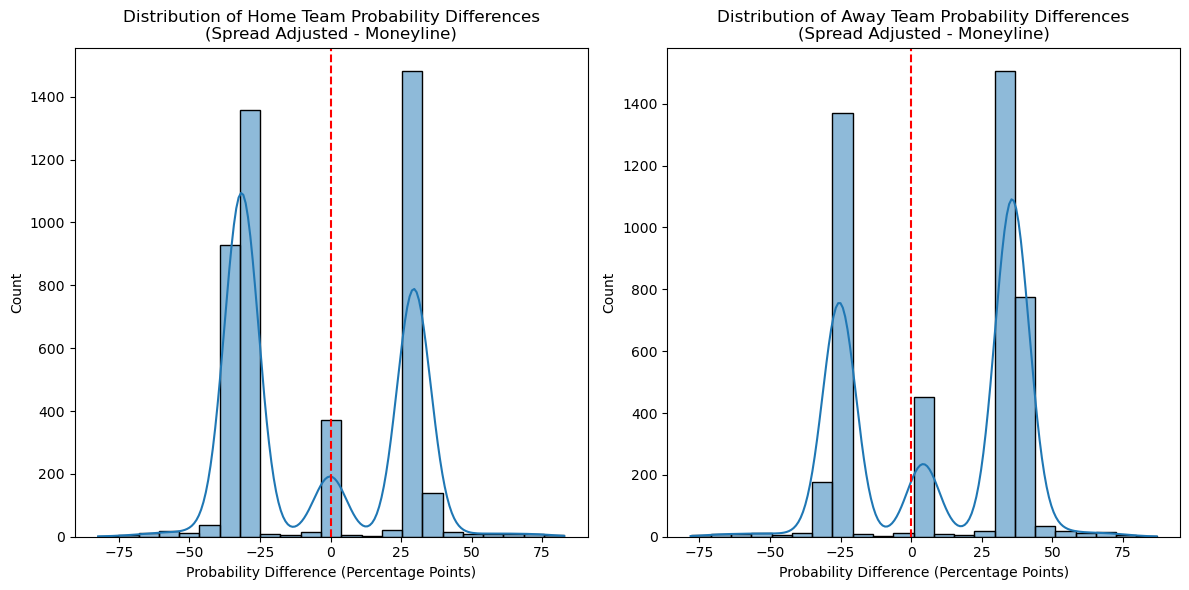


Accuracy by spread group:
              moneyline_prediction_correct  spread_prediction_correct
spread_group                                                         
(0.0, 1.0]                        0.800000                   0.200000
(1.0, 1.5]                        0.563012                   0.556870
(1.5, 2.0]                        1.000000                   0.000000
(2.0, 2.5]                        0.878049                   0.439024
(2.5, 3.0]                             NaN                        NaN
(3.0, 10.0]                       0.846154                   0.512821


/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_20266/2693978294.py:262: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spread_group_accuracy = df.groupby('spread_group')[['moneyline_prediction_correct', 'spread_prediction_correct']].mean()


<Figure size 1000x600 with 0 Axes>

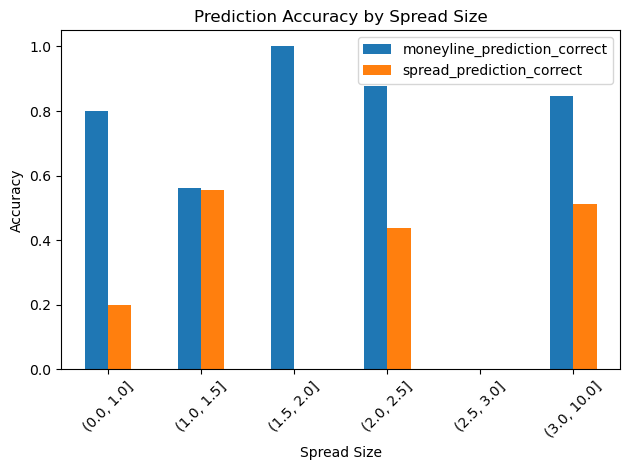


Underdog Performance by Odds Range:
              underdog_won  underdog_covered  underdog_prob_diff_pct  \
odds_group                                                             
<+100             0.485602          0.509162               16.550546   
+100 to +150      0.438272          0.579090               31.826352   
+150 to +200      0.386684          0.510883               35.763269   
+200 to +250      0.244019          0.377990               38.310570   
+250 to +300      0.190476          0.380952               44.301118   
>+300             0.127660          0.436170               61.689344   

              underdog_ml_prob  underdog_spread_adjusted_prob  game_count  
odds_group                                                                 
<+100                 0.488365                       0.653871         764  
+100 to +150          0.433219                       0.751482        2592  
+150 to +200          0.354898                       0.712531         781  
+200 t

/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_20266/2693978294.py:306: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  underdog_performance = underdogs_df.groupby('odds_group').agg({


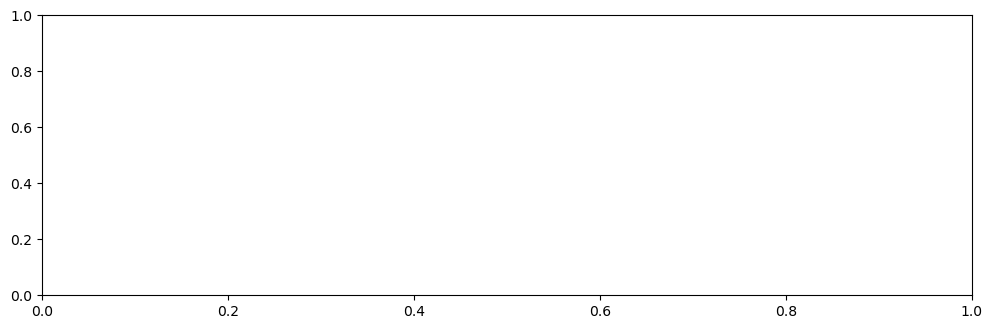

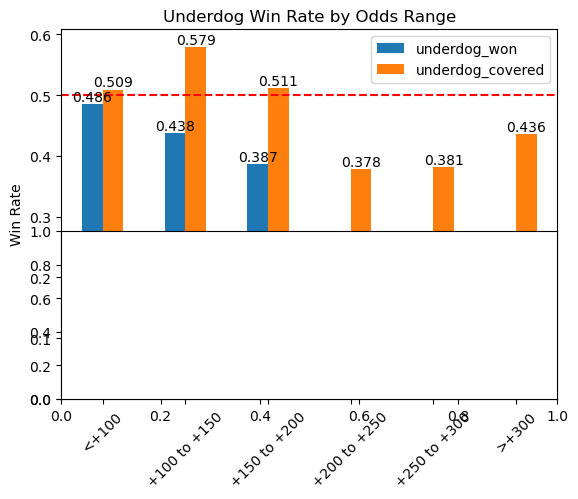

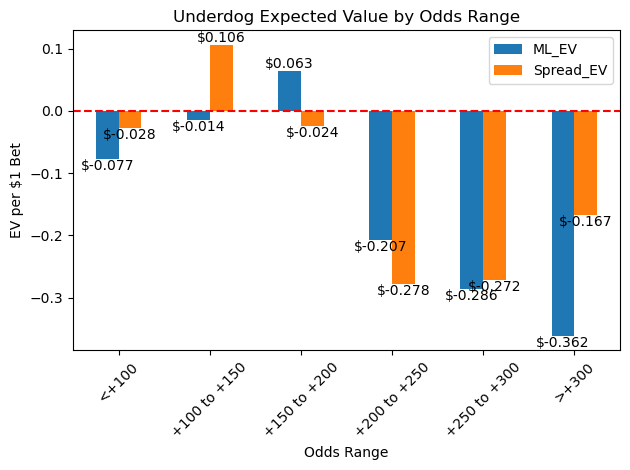

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('Documents/result_33.csv')

# Convert date column to datetime
df['commence_time'] = pd.to_datetime(df['commence_time'])

# Function to calculate implied probability from money line odds
def calc_implied_prob_moneyline(odds):
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return abs(odds) / (abs(odds) + 100)

# Calculate implied probabilities for money lines
df['home_moneyline_implied_prob'] = df['home_money_line_odds'].apply(calc_implied_prob_moneyline)
df['away_moneyline_implied_prob'] = df['away_money_line_odds'].apply(calc_implied_prob_moneyline)

# Calculate the "fair" total implied probability without vig
df['total_implied_prob'] = df['home_moneyline_implied_prob'] + df['away_moneyline_implied_prob']
df['vig_factor'] = 1 / df['total_implied_prob']

# Normalize moneyline probabilities to remove the vig
df['home_moneyline_fair_prob'] = df['home_moneyline_implied_prob'] * df['vig_factor']
df['away_moneyline_fair_prob'] = df['away_moneyline_implied_prob'] * df['vig_factor']

# Calculate spread-based probabilities
# First, calculate implied probabilities from spread odds
df['home_spread_implied_prob'] = df['home_spread_odds'].apply(calc_implied_prob_moneyline)
df['away_spread_implied_prob'] = df['away_spread_odds'].apply(calc_implied_prob_moneyline)

# Determine favorites for each game
df['home_is_favorite'] = df['home_moneyline_fair_prob'] > df['away_moneyline_fair_prob']
df['away_is_favorite'] = df['away_moneyline_fair_prob'] > df['home_moneyline_fair_prob']

# Determine the favorite's probability for each game
df['favorite_prob'] = df.apply(
    lambda row: max(row['home_moneyline_fair_prob'], row['away_moneyline_fair_prob']), 
    axis=1)

# Calculate the conversion factor using the favorite's probability
df['conversion_factor'] = (df['favorite_prob'] - 0.02) * 0.28

# CORRECTED: Calculate adjusted spread probabilities using the favorite's conversion factor
df['home_spread_adjusted_prob'] = df.apply(
    lambda row: row['home_spread_implied_prob'] - row['conversion_factor'] if row['home_is_favorite'] 
                else row['home_spread_implied_prob'] + row['conversion_factor'],
    axis=1)

df['away_spread_adjusted_prob'] = df.apply(
    lambda row: row['away_spread_implied_prob'] - row['conversion_factor'] if row['away_is_favorite'] 
                else row['away_spread_implied_prob'] + row['conversion_factor'],
    axis=1)

# Calculate the differences between moneyline and spread adjusted probabilities (in percentage points)
df['home_prob_diff_pct'] = (df['home_spread_adjusted_prob'] - df['home_moneyline_fair_prob']) * 100
df['away_prob_diff_pct'] = (df['away_spread_adjusted_prob'] - df['away_moneyline_fair_prob']) * 100

# Calculate actual outcomes (who won)
df['home_win'] = df['home_score'] > df['away_score']
df['away_win'] = df['away_score'] > df['home_score']

# Calculate whether the spread was covered
df['home_covered_spread'] = (df['home_score'] - df['away_score']) > -df['spread']
df['away_covered_spread'] = (df['away_score'] - df['home_score']) > df['spread']

# Display the first few rows with calculated values
print("First 5 rows with calculated probabilities:")
columns_to_show = ['commence_time', 'spread', 
                   'home_moneyline_fair_prob', 'home_spread_adjusted_prob', 'home_prob_diff_pct',
                   'away_moneyline_fair_prob', 'away_spread_adjusted_prob', 'away_prob_diff_pct',
                   'home_win', 'away_win', 'home_covered_spread', 'away_covered_spread']
print(df[columns_to_show].head())

# Basic statistics on the probability differences
print("\nSummary statistics for probability differences (percentage points):")
print(df[['home_prob_diff_pct', 'away_prob_diff_pct']].describe())

# Analyze which bet type was more accurate
# For moneyline: did team with higher moneyline probability win?
df['moneyline_prediction_correct'] = (
    ((df['home_moneyline_fair_prob'] > df['away_moneyline_fair_prob']) & df['home_win']) | 
    ((df['away_moneyline_fair_prob'] > df['home_moneyline_fair_prob']) & df['away_win'])
)

# For spread: did team with higher spread-adjusted probability cover the spread?
df['spread_prediction_correct'] = (
    ((df['home_spread_adjusted_prob'] > df['away_spread_adjusted_prob']) & df['home_covered_spread']) | 
    ((df['away_spread_adjusted_prob'] > df['home_spread_adjusted_prob']) & df['away_covered_spread'])
)

# Calculate accuracy rates
moneyline_accuracy = df['moneyline_prediction_correct'].mean()
spread_accuracy = df['spread_prediction_correct'].mean()

print(f"\nMoneyline prediction accuracy: {moneyline_accuracy:.4f}")
print(f"Spread prediction accuracy: {spread_accuracy:.4f}")

# Additional analysis: Check for patterns based on probability differences
print("\nAccuracy when spread probability is higher than moneyline probability:")
home_higher_spread = df[df['home_prob_diff_pct'] > 0]['home_covered_spread'].mean()
away_higher_spread = df[df['away_prob_diff_pct'] > 0]['away_covered_spread'].mean()
print(f"Home team covers when spread probability > moneyline: {home_higher_spread:.4f}")
print(f"Away team covers when spread probability > moneyline: {away_higher_spread:.4f}")

print("\nAccuracy when moneyline probability is higher than spread probability:")
home_higher_ml = df[df['home_prob_diff_pct'] < 0]['home_win'].mean()
away_higher_ml = df[df['away_prob_diff_pct'] < 0]['away_win'].mean()
print(f"Home team wins when moneyline probability > spread: {home_higher_ml:.4f}")
print(f"Away team wins when moneyline probability > spread: {away_higher_ml:.4f}")

# Create a function to export the probability data to CSV
def export_probabilities_to_csv(df, filename='baseball_implied_probabilities.csv'):
    """
    Export a clean dataframe with all the implied probabilities in percentage format.
    
    Parameters:
        df: The original dataframe with betting data
        filename: The output CSV filename
        
    Returns:
        DataFrame: A dataframe with all probabilities as percentages
    """
    # Create a new dataframe with only the relevant probability columns (as percentages)
    prob_df = pd.DataFrame()
    
    # Add game identifiers and basic info
    prob_df['game_date'] = df['commence_time'].dt.date
    prob_df['spread'] = df['spread']
    
    # Add moneyline odds
    prob_df['home_moneyline_odds'] = df['home_money_line_odds']
    prob_df['away_moneyline_odds'] = df['away_money_line_odds']
    
    # Add spread odds
    prob_df['home_spread_odds'] = df['home_spread_odds']
    prob_df['away_spread_odds'] = df['away_spread_odds']
    
    # Add favorite indicators
    prob_df['home_is_favorite'] = df['home_is_favorite']
    prob_df['away_is_favorite'] = df['away_is_favorite']
    
    # Add moneyline probabilities (as percentages)
    prob_df['home_moneyline_raw_prob_pct'] = df['home_moneyline_implied_prob'] * 100
    prob_df['away_moneyline_raw_prob_pct'] = df['away_moneyline_implied_prob'] * 100
    prob_df['home_moneyline_fair_prob_pct'] = df['home_moneyline_fair_prob'] * 100
    prob_df['away_moneyline_fair_prob_pct'] = df['away_moneyline_fair_prob'] * 100
    
    # Add spread probabilities (as percentages)
    prob_df['home_spread_implied_prob_pct'] = df['home_spread_implied_prob'] * 100
    prob_df['away_spread_implied_prob_pct'] = df['away_spread_implied_prob'] * 100
    prob_df['home_spread_adjusted_prob_pct'] = df['home_spread_adjusted_prob'] * 100
    prob_df['away_spread_adjusted_prob_pct'] = df['away_spread_adjusted_prob'] * 100
    
    # Add the favorite's probability and conversion factor
    prob_df['favorite_prob_pct'] = df['favorite_prob'] * 100
    prob_df['conversion_factor_pct'] = df['conversion_factor'] * 100
    
    # Add probability differences
    prob_df['home_prob_diff_pct'] = df['home_prob_diff_pct']
    prob_df['away_prob_diff_pct'] = df['away_prob_diff_pct']
    
    # Add actual results
    prob_df['home_win'] = df['home_win']
    prob_df['away_win'] = df['away_win']
    prob_df['home_covered_spread'] = df['home_covered_spread']
    prob_df['away_covered_spread'] = df['away_covered_spread']
    
    # Save to CSV
    prob_df.to_csv(filename, index=False)
    print(f"Exported probability data to {filename}")
    
    return prob_df

# Export the probability data
prob_df = export_probabilities_to_csv(df)

# Display the first few rows of the exported dataframe
print("\nFirst 5 rows of the probability dataframe:")
print(prob_df.head())

# Analysis for games with money lines between +150 and +200
print("\n--- Analysis of games with money lines between +150 and +200 ---")

# Find games where either home or away team has money line odds in this range
home_in_range = (df['home_money_line_odds'] >= 150) & (df['home_money_line_odds'] <= 200)
away_in_range = (df['away_money_line_odds'] >= 150) & (df['away_money_line_odds'] <= 200)
df_money_range = df[home_in_range | away_in_range]

print(f"Number of games with money lines between +150 and +200: {len(df_money_range)}")

# Calculate average probability differences in this range
# Handle potential empty dataframes
home_avg_diff = df_money_range[home_in_range]['home_prob_diff_pct'].mean() if any(home_in_range) else 0
away_avg_diff = df_money_range[away_in_range]['away_prob_diff_pct'].mean() if any(away_in_range) else 0

print("\nAverage probability differences (percentage points) in +150 to +200 range:")
print(f"Home teams: {home_avg_diff:.2f}")
print(f"Away teams: {away_avg_diff:.2f}")

# Calculate betting accuracy in this range - handle potential empty dataframes
if any(home_in_range):
    home_ml_accuracy = df_money_range[home_in_range]['home_win'].mean()
    home_spread_accuracy = df_money_range[home_in_range]['home_covered_spread'].mean()
else:
    home_ml_accuracy = 0
    home_spread_accuracy = 0

if any(away_in_range):
    away_ml_accuracy = df_money_range[away_in_range]['away_win'].mean()
    away_spread_accuracy = df_money_range[away_in_range]['away_covered_spread'].mean()
else:
    away_ml_accuracy = 0
    away_spread_accuracy = 0

print("\nBetting accuracy for teams with money line between +150 and +200:")
print(f"Home teams moneyline accuracy: {home_ml_accuracy:.4f}")
print(f"Home teams spread accuracy: {home_spread_accuracy:.4f}")
print(f"Away teams moneyline accuracy: {away_ml_accuracy:.4f}")
print(f"Away teams spread accuracy: {away_spread_accuracy:.4f}")

# Calculate expected value in this range
home_ml_ev = (home_ml_accuracy * 1.75) - (1 - home_ml_accuracy)  # Average payout of 1.75 for +150 to +200
home_spread_ev = (home_spread_accuracy * 0.91) - (1 - home_spread_accuracy)  # Using -110 typical spread odds
away_ml_ev = (away_ml_accuracy * 1.75) - (1 - away_ml_accuracy)
away_spread_ev = (away_spread_accuracy * 0.91) - (1 - away_spread_accuracy)

print("\nExpected Value (EV) per $1 bet:")
print(f"Home teams moneyline EV: ${home_ml_ev:.4f}")
print(f"Home teams spread EV: ${home_spread_ev:.4f}")
print(f"Away teams moneyline EV: ${away_ml_ev:.4f}")
print(f"Away teams spread EV: ${away_spread_ev:.4f}")

# Visualize the distribution of probability differences
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['home_prob_diff_pct'], kde=True)
plt.title('Distribution of Home Team Probability Differences\n(Spread Adjusted - Moneyline)')
plt.xlabel('Probability Difference (Percentage Points)')
plt.axvline(x=0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
sns.histplot(df['away_prob_diff_pct'], kde=True)
plt.title('Distribution of Away Team Probability Differences\n(Spread Adjusted - Moneyline)')
plt.xlabel('Probability Difference (Percentage Points)')
plt.axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Additional analysis: Check if there's a pattern based on spread size
df['abs_spread'] = df['spread'].abs()
spread_bins = [0, 1, 1.5, 2, 2.5, 3, 10]
df['spread_group'] = pd.cut(df['abs_spread'], bins=spread_bins)

# Calculate accuracy by spread group
spread_group_accuracy = df.groupby('spread_group')[['moneyline_prediction_correct', 'spread_prediction_correct']].mean()
print("\nAccuracy by spread group:")
print(spread_group_accuracy)

plt.figure(figsize=(10, 6))
spread_group_accuracy.plot(kind='bar')
plt.title('Prediction Accuracy by Spread Size')
plt.xlabel('Spread Size')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a separate dataframe to analyze patterns specifically for underdogs
underdogs_df = pd.DataFrame()
underdogs_df['underdog_is_home'] = df['home_moneyline_fair_prob'] < df['away_moneyline_fair_prob']
underdogs_df['underdog_ml_prob'] = df.apply(
    lambda row: row['home_moneyline_fair_prob'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] else row['away_moneyline_fair_prob'],
    axis=1
)
underdogs_df['underdog_spread_adjusted_prob'] = df.apply(
    lambda row: row['home_spread_adjusted_prob'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] else row['away_spread_adjusted_prob'],
    axis=1
)
underdogs_df['underdog_prob_diff_pct'] = (underdogs_df['underdog_spread_adjusted_prob'] - underdogs_df['underdog_ml_prob']) * 100
underdogs_df['underdog_won'] = df.apply(
    lambda row: row['home_win'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] else row['away_win'],
    axis=1
)
underdogs_df['underdog_covered'] = df.apply(
    lambda row: row['home_covered_spread'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] else row['away_covered_spread'],
    axis=1
)
underdogs_df['underdog_ml_odds'] = df.apply(
    lambda row: row['home_money_line_odds'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] else row['away_money_line_odds'],
    axis=1
)

# Analyze underdog performance by moneyline odds range
underdog_bins = [-np.inf, 100, 150, 200, 250, 300, np.inf]
underdog_labels = ['<+100', '+100 to +150', '+150 to +200', '+200 to +250', '+250 to +300', '>+300']
underdogs_df['odds_group'] = pd.cut(underdogs_df['underdog_ml_odds'], bins=underdog_bins, labels=underdog_labels)

# Calculate underdog performance by odds group
underdog_performance = underdogs_df.groupby('odds_group').agg({
    'underdog_won': 'mean',
    'underdog_covered': 'mean',
    'underdog_prob_diff_pct': 'mean',
    'underdog_ml_prob': 'mean',
    'underdog_spread_adjusted_prob': 'mean',
    'underdog_is_home': 'size'  # Count of games in each group
}).rename(columns={'underdog_is_home': 'game_count'})

print("\nUnderdog Performance by Odds Range:")
print(underdog_performance)

# Calculate moneyline and spread expected values by odds group
for group in underdog_labels:
    if group in underdog_performance.index:
        ml_win_rate = underdog_performance.loc[group, 'underdog_won']
        spread_win_rate = underdog_performance.loc[group, 'underdog_covered']
        
        # Estimate average payout for each odds group
        if group == '<+100':
            avg_payout = 0.9  # Approximate for favorites
        elif group == '+100 to +150':
            avg_payout = 1.25
        elif group == '+150 to +200':
            avg_payout = 1.75
        elif group == '+200 to +250':
            avg_payout = 2.25
        elif group == '+250 to +300':
            avg_payout = 2.75
        else:  # >+300
            avg_payout = 4.0
            
        ml_ev = (ml_win_rate * avg_payout) - (1 - ml_win_rate)
        spread_ev = (spread_win_rate * 0.91) - (1 - spread_win_rate)
        
        underdog_performance.loc[group, 'ML_EV'] = ml_ev
        underdog_performance.loc[group, 'Spread_EV'] = spread_ev

print("\nUnderdog Expected Value by Odds Range:")
print(underdog_performance[['underdog_won', 'underdog_covered', 'ML_EV', 'Spread_EV', 'game_count']])

# Visualize underdog performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
ax = underdog_performance[['underdog_won', 'underdog_covered']].plot(kind='bar')
plt.title('Underdog Win Rate by Odds Range')
plt.ylabel('Win Rate')
plt.xlabel('')
plt.xticks(rotation=45)
plt.axhline(y=0.5, color='red', linestyle='--')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

plt.subplot(2, 1, 2)
ax2 = underdog_performance[['ML_EV', 'Spread_EV']].plot(kind='bar')
plt.title('Underdog Expected Value by Odds Range')
plt.ylabel('EV per $1 Bet')
plt.xlabel('Odds Range')
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--')

# Add value labels on top of bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='$%.3f')

plt.tight_layout()
plt.show()


Favorite Performance by Odds Range:
              favorite_won  favorite_covered  favorite_prob_diff_pct  \
odds_group                                                             
< -500            0.876543          0.555556              -57.955619   
-500 to -300      0.784946          0.634409              -38.450452   
-300 to -200      0.668285          0.537217              -32.201025   
-200 to -150      0.571967          0.434062              -29.978105   
-150 to -110      0.546460          0.438938              -22.700658   
-110 to 0         0.495146          0.495146                6.751878   

              favorite_ml_prob  favorite_spread_adjusted_prob  game_count  \
odds_group                                                                  
< -500                0.873882                       0.294326          81   
-500 to -300          0.740007                       0.355503          93   
-300 to -200          0.669498                       0.347488         618   
-

/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_20266/405422306.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  favorite_performance = favorites_df.groupby('odds_group').agg({


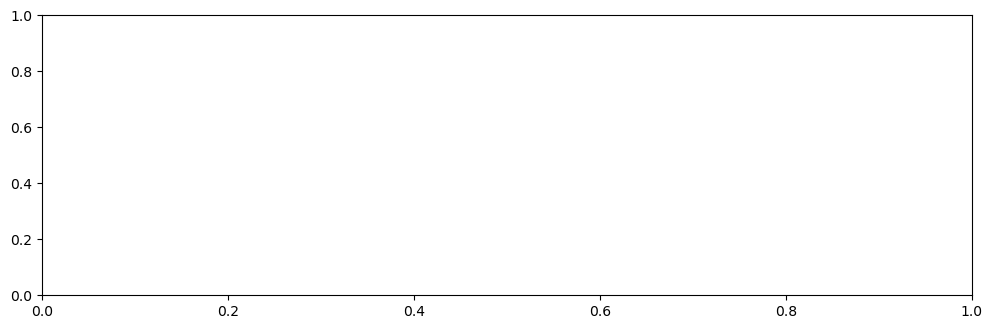

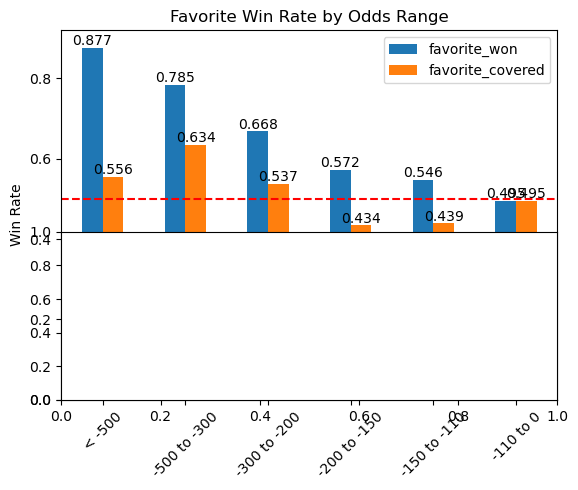

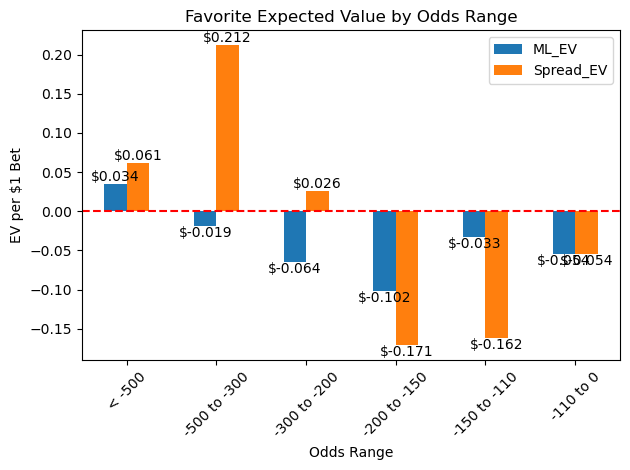


Favorite Performance by Odds Range and Spread Size:
                           favorite_won  favorite_covered     ML_EV  \
odds_group   spread_group                                             
< -500       (1.0, 1.5]        0.840000          0.720000 -0.008800   
             (2.0, 2.5]        0.944444          0.500000  0.114444   
             (3.0, 10.0]       0.864865          0.486486  0.020541   
-500 to -300 (1.0, 1.5]        0.774648          0.661972 -0.031690   
             (2.0, 2.5]        0.809524          0.571429  0.011905   
-300 to -200 (1.0, 1.5]        0.667752          0.534202 -0.065147   
-200 to -150 (1.0, 1.5]        0.571644          0.433635 -0.102519   
-150 to -110 (1.0, 1.5]        0.546300          0.439078 -0.033048   
-110 to 0    (1.0, 1.5]        0.495146          0.495146 -0.054272   

                           Spread_EV   EV_Diff  game_count  
odds_group   spread_group                                   
< -500       (1.0, 1.5]     0.375200  0.384

/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_20266/405422306.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  favorite_spread_analysis = favorites_df.groupby(['odds_group', 'spread_group']).agg({
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


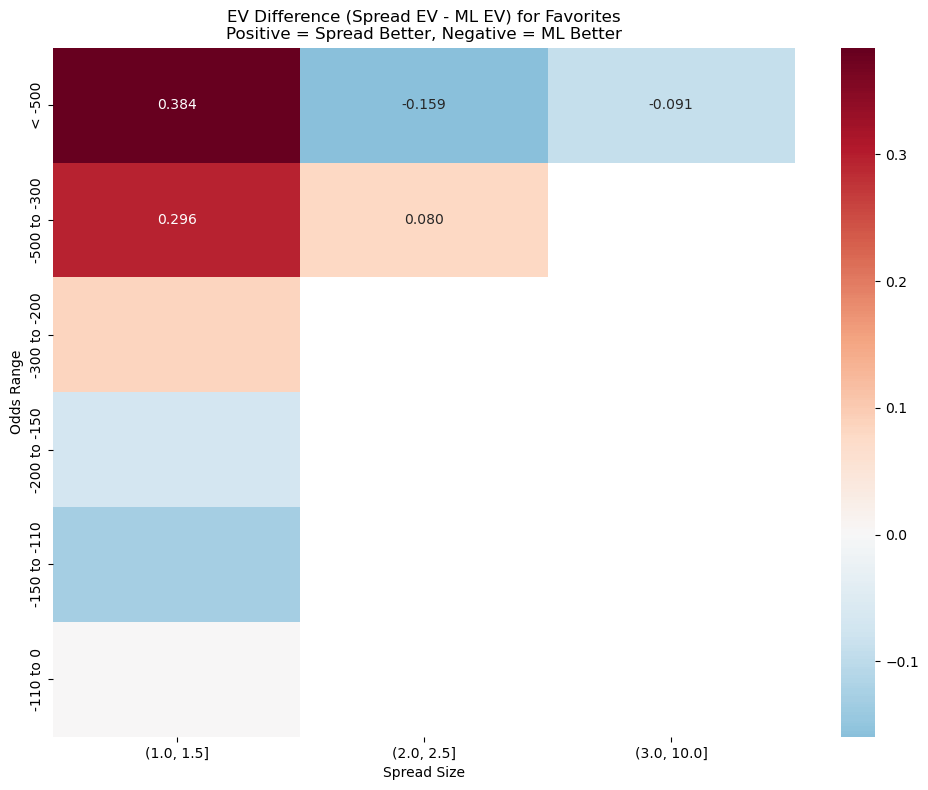

In [4]:
# Add this at the end of your main analysis script

# Create a separate dataframe to analyze patterns specifically for favorites
favorites_df = pd.DataFrame()
favorites_df['favorite_is_home'] = df['home_moneyline_fair_prob'] > df['away_moneyline_fair_prob']
favorites_df['favorite_ml_prob'] = df.apply(
    lambda row: row['home_moneyline_fair_prob'] if row['home_moneyline_fair_prob'] > row['away_moneyline_fair_prob'] else row['away_moneyline_fair_prob'],
    axis=1
)
favorites_df['favorite_spread_adjusted_prob'] = df.apply(
    lambda row: row['home_spread_adjusted_prob'] if row['home_moneyline_fair_prob'] > row['away_moneyline_fair_prob'] else row['away_spread_adjusted_prob'],
    axis=1
)
favorites_df['favorite_prob_diff_pct'] = (favorites_df['favorite_spread_adjusted_prob'] - favorites_df['favorite_ml_prob']) * 100
favorites_df['favorite_won'] = df.apply(
    lambda row: row['home_win'] if row['home_moneyline_fair_prob'] > row['away_moneyline_fair_prob'] else row['away_win'],
    axis=1
)
favorites_df['favorite_covered'] = df.apply(
    lambda row: row['home_covered_spread'] if row['home_moneyline_fair_prob'] > row['away_moneyline_fair_prob'] else row['away_covered_spread'],
    axis=1
)
favorites_df['favorite_ml_odds'] = df.apply(
    lambda row: row['home_money_line_odds'] if row['home_moneyline_fair_prob'] > row['away_moneyline_fair_prob'] else row['away_money_line_odds'],
    axis=1
)
favorites_df['spread_value'] = df['spread'].abs()

# Group favorites by moneyline odds range (negative values for favorites)
favorite_bins = [-np.inf, -500, -300, -200, -150, -110, 0]
favorite_labels = ['< -500', '-500 to -300', '-300 to -200', '-200 to -150', '-150 to -110', '-110 to 0']
favorites_df['odds_group'] = pd.cut(favorites_df['favorite_ml_odds'], bins=favorite_bins, labels=favorite_labels)

# Calculate favorite performance by odds group
favorite_performance = favorites_df.groupby('odds_group').agg({
    'favorite_won': 'mean',
    'favorite_covered': 'mean',
    'favorite_prob_diff_pct': 'mean',
    'favorite_ml_prob': 'mean', 
    'favorite_spread_adjusted_prob': 'mean',
    'favorite_is_home': 'size',  # Count of games in each group
    'spread_value': 'mean'      # Average spread
}).rename(columns={'favorite_is_home': 'game_count'})

print("\nFavorite Performance by Odds Range:")
print(favorite_performance)

# Calculate moneyline and spread expected values by odds group for favorites
for group in favorite_labels:
    if group in favorite_performance.index:
        ml_win_rate = favorite_performance.loc[group, 'favorite_won']
        spread_win_rate = favorite_performance.loc[group, 'favorite_covered']
        
        # Estimate average payout for each odds group based on midpoint
        if group == '< -500':
            avg_payout = 0.18  # Approximate -550 odds
        elif group == '-500 to -300':
            avg_payout = 0.25  # Approximate -400 odds
        elif group == '-300 to -200':
            avg_payout = 0.4   # Approximate -250 odds
        elif group == '-200 to -150':
            avg_payout = 0.57  # Approximate -175 odds
        elif group == '-150 to -110':
            avg_payout = 0.77  # Approximate -130 odds
        else:  # '-110 to 0'
            avg_payout = 0.91  # Approximate -105 odds
            
        ml_ev = (ml_win_rate * avg_payout) - (1 - ml_win_rate)
        spread_ev = (spread_win_rate * 0.91) - (1 - spread_win_rate)
        
        favorite_performance.loc[group, 'ML_EV'] = ml_ev
        favorite_performance.loc[group, 'Spread_EV'] = spread_ev

print("\nFavorite Expected Value by Odds Range:")
print(favorite_performance[['favorite_won', 'favorite_covered', 'ML_EV', 'Spread_EV', 'game_count', 'spread_value']])

# Visualize favorite performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
ax = favorite_performance[['favorite_won', 'favorite_covered']].plot(kind='bar')
plt.title('Favorite Win Rate by Odds Range')
plt.ylabel('Win Rate')
plt.xlabel('')
plt.xticks(rotation=45)
plt.axhline(y=0.5, color='red', linestyle='--')

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

plt.subplot(2, 1, 2)
ax2 = favorite_performance[['ML_EV', 'Spread_EV']].plot(kind='bar')
plt.title('Favorite Expected Value by Odds Range')
plt.ylabel('EV per $1 Bet')
plt.xlabel('Odds Range')
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--')

# Add value labels on top of bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='$%.3f')

plt.tight_layout()
plt.show()

# Additional analysis: Compare favorite EV by spread size
favorites_df['spread_group'] = pd.cut(favorites_df['spread_value'], bins=[0, 1, 1.5, 2, 2.5, 3, 10])

# Group by both odds and spread
favorite_spread_analysis = favorites_df.groupby(['odds_group', 'spread_group']).agg({
    'favorite_won': 'mean',
    'favorite_covered': 'mean',
    'favorite_is_home': 'size'  # Count
}).rename(columns={'favorite_is_home': 'game_count'})

# Filter groups with sufficient sample size
favorite_spread_analysis = favorite_spread_analysis[favorite_spread_analysis['game_count'] >= 10]

# Calculate EVs for each combination
for idx in favorite_spread_analysis.index:
    odds_group, spread_group = idx
    win_rate = favorite_spread_analysis.loc[idx, 'favorite_won']
    cover_rate = favorite_spread_analysis.loc[idx, 'favorite_covered']
    
    # Use same payout estimates as before
    if odds_group == '< -500':
        avg_payout = 0.18
    elif odds_group == '-500 to -300':
        avg_payout = 0.25
    elif odds_group == '-300 to -200':
        avg_payout = 0.4
    elif odds_group == '-200 to -150':
        avg_payout = 0.57
    elif odds_group == '-150 to -110':
        avg_payout = 0.77
    else:  # '-110 to 0'
        avg_payout = 0.91
        
    ml_ev = (win_rate * avg_payout) - (1 - win_rate)
    spread_ev = (cover_rate * 0.91) - (1 - cover_rate)
    
    favorite_spread_analysis.loc[idx, 'ML_EV'] = ml_ev
    favorite_spread_analysis.loc[idx, 'Spread_EV'] = spread_ev
    favorite_spread_analysis.loc[idx, 'EV_Diff'] = spread_ev - ml_ev

print("\nFavorite Performance by Odds Range and Spread Size:")
print(favorite_spread_analysis[['favorite_won', 'favorite_covered', 'ML_EV', 'Spread_EV', 'EV_Diff', 'game_count']])

# Identify the most profitable betting scenarios
best_ml_combos = favorite_spread_analysis.sort_values('ML_EV', ascending=False).head(5)
best_spread_combos = favorite_spread_analysis.sort_values('Spread_EV', ascending=False).head(5)

print("\nTop 5 Most Profitable Favorite Moneyline Scenarios:")
print(best_ml_combos[['favorite_won', 'ML_EV', 'game_count']])

print("\nTop 5 Most Profitable Favorite Spread Scenarios:")
print(best_spread_combos[['favorite_covered', 'Spread_EV', 'game_count']])

# Visualize the EV difference (Spread EV - ML EV) as a heatmap
if len(favorite_spread_analysis) > 0:
    # Pivot the data for the heatmap
    pivot_data = favorite_spread_analysis['EV_Diff'].unstack()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_data, annot=True, cmap='RdBu_r', center=0, fmt='.3f')
    plt.title('EV Difference (Spread EV - ML EV) for Favorites\nPositive = Spread Better, Negative = ML Better')
    plt.xlabel('Spread Size')
    plt.ylabel('Odds Range')
    plt.tight_layout()
    plt.show()


=== PROFITABILITY ANALYSIS ($300 PER BET) ===

                    | MONEYLINE                |  SPREAD
SCENARIO           | Win Rate | Profit | ROI   | Cover Rate | Profit | ROI   | Sample Size | Better Bet
------------------------------------------------------------------------------------------
Away +100 to +150  | 0.455   | $  6.82 |   2.3% | 0.604     | $ 46.19 |  15.4% |  1584       | SPREAD
Home +100 to +150  | 0.413   | $-21.43 |  -7.1% | 0.540     | $  9.24 |   3.1% |  1008       | SPREAD
Away +150 to +200  | 0.377   | $ 11.29 |   3.8% | 0.511     | $ -7.11 |  -2.4% |   538       | MONEYLINE
Home +150 to +200  | 0.407   | $ 36.11 |  12.0% | 0.510     | $ -7.60 |  -2.5% |   243       | MONEYLINE

=== PROFIT PER 100 BETS ===
SCENARIO           | MONEYLINE    | SPREAD        | DIFFERENCE (SPREAD-ML)
-----------------------------------------------------------------
Away +100 to +150  | $    681.82 | $   4618.75 | $   3936.93
Home +100 to +150  | $  -2142.86 | $    923.81 | $   30

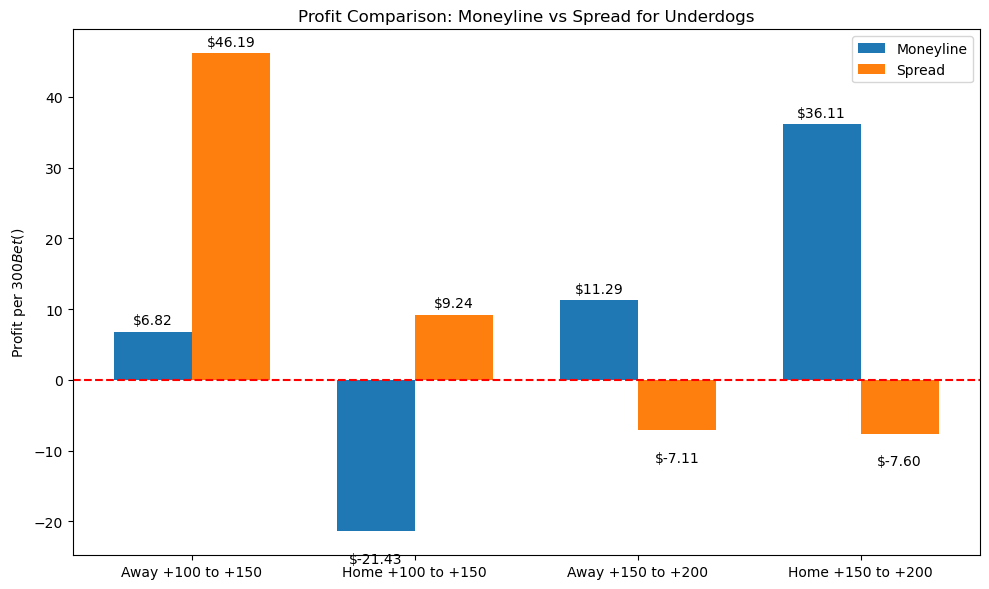

In [8]:
# Create a fixed, simplified profitability analysis focusing on the specific underdog scenarios
# Avoiding categorical data issues

# Define the bet amount
BET_AMOUNT = 300  # $300 per bet

# Create the underdog dataframe with home/away distinction
underdog_analysis = pd.DataFrame()
underdog_analysis['is_home'] = df.apply(
    lambda row: row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'],
    axis=1
)
underdog_analysis['ml_odds'] = df.apply(
    lambda row: row['home_money_line_odds'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_money_line_odds'],
    axis=1
)
underdog_analysis['won'] = df.apply(
    lambda row: row['home_win'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_win'],
    axis=1
)
underdog_analysis['covered'] = df.apply(
    lambda row: row['home_covered_spread'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_covered_spread'],
    axis=1
)

# Create a string column for odds group rather than categorical
def get_odds_group(odds):
    if 0 < odds <= 100:
        return '+0 to +100'
    elif 100 < odds <= 150:
        return '+100 to +150'
    elif 150 < odds <= 200:
        return '+150 to +200'
    elif 200 < odds <= 250:
        return '+200 to +250'
    elif 250 < odds <= 300:
        return '+250 to +300'
    else:
        return '>+300'

underdog_analysis['odds_group'] = underdog_analysis['ml_odds'].apply(get_odds_group)

# Calculate results for each group and home/away status
grouped_results = underdog_analysis.groupby(['odds_group', 'is_home']).agg({
    'won': ['mean', 'count'],
    'covered': 'mean'
}).reset_index()

# Flatten the multi-level columns
grouped_results.columns = ['odds_group', 'is_home', 'win_rate', 'sample_size', 'cover_rate']
grouped_results['location'] = grouped_results['is_home'].map({True: 'Home', False: 'Away'})

# Calculate payouts using a dictionary mapping instead of categorical data
payout_map = {
    '+0 to +100': 1.9,
    '+100 to +150': 2.25,
    '+150 to +200': 2.75,
    '+200 to +250': 3.25,
    '+250 to +300': 3.75,
    '>+300': 4.5
}

grouped_results['ml_payout_multiplier'] = grouped_results['odds_group'].map(payout_map)
grouped_results['ml_payout_per_win'] = grouped_results['ml_payout_multiplier'] * BET_AMOUNT
grouped_results['spread_payout_per_win'] = 1.91 * BET_AMOUNT  # Standard -110 odds payout

# Calculate expected profit/loss per bet
grouped_results['ml_profit_per_bet'] = (grouped_results['win_rate'] * (grouped_results['ml_payout_per_win'] - BET_AMOUNT)) - ((1 - grouped_results['win_rate']) * BET_AMOUNT)
grouped_results['spread_profit_per_bet'] = (grouped_results['cover_rate'] * (grouped_results['spread_payout_per_win'] - BET_AMOUNT)) - ((1 - grouped_results['cover_rate']) * BET_AMOUNT)

# Calculate ROI and profit per 100 bets
grouped_results['ml_roi'] = grouped_results['ml_profit_per_bet'] / BET_AMOUNT * 100
grouped_results['spread_roi'] = grouped_results['spread_profit_per_bet'] / BET_AMOUNT * 100
grouped_results['ml_profit_per_100_bets'] = grouped_results['ml_profit_per_bet'] * 100
grouped_results['spread_profit_per_100_bets'] = grouped_results['spread_profit_per_bet'] * 100

# Focus on the two scenarios of interest
interest_scenarios = grouped_results[
    ((grouped_results['odds_group'] == '+100 to +150') | 
     (grouped_results['odds_group'] == '+150 to +200'))
]

# Print detailed results for the scenarios of interest
print(f"\n=== PROFITABILITY ANALYSIS (${BET_AMOUNT} PER BET) ===\n")

# Prepare a more tabular format for better readability
print("                    | MONEYLINE                |  SPREAD")
print("SCENARIO           | Win Rate | Profit | ROI   | Cover Rate | Profit | ROI   | Sample Size | Better Bet")
print("-" * 90)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    win_rate = row['win_rate']
    cover_rate = row['cover_rate']
    ml_profit = row['ml_profit_per_bet']
    spread_profit = row['spread_profit_per_bet']
    ml_roi = row['ml_roi']
    spread_roi = row['spread_roi']
    sample_size = row['sample_size']
    
    better_bet = "SPREAD" if spread_profit > ml_profit else "MONEYLINE"
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | {win_rate:.3f}   | ${ml_profit:6.2f} | {ml_roi:5.1f}% | {cover_rate:.3f}     | ${spread_profit:6.2f} | {spread_roi:5.1f}% | {sample_size:5d}       | {better_bet}")

# Create a simple table showing the profit per 100 bets
print("\n=== PROFIT PER 100 BETS ===")
print("SCENARIO           | MONEYLINE    | SPREAD        | DIFFERENCE (SPREAD-ML)")
print("-" * 65)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    ml_profit_100 = row['ml_profit_per_100_bets']
    spread_profit_100 = row['spread_profit_per_100_bets']
    diff = spread_profit_100 - ml_profit_100
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | ${ml_profit_100:10.2f} | ${spread_profit_100:10.2f} | ${diff:10.2f}")

# Calculate the overall optimal strategy
optimal_strategy_profit = 0
print("\n=== OPTIMAL BETTING STRATEGY ===")
print("SCENARIO           | OPTIMAL BET  | PROFIT PER BET | PROFIT PER 25 BETS")
print("-" * 65)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    ml_profit = row['ml_profit_per_bet']
    spread_profit = row['spread_profit_per_bet']
    
    better_bet = "SPREAD" if spread_profit > ml_profit else "MONEYLINE"
    opt_profit = max(ml_profit, spread_profit)
    profit_25 = opt_profit * 25
    optimal_strategy_profit += profit_25
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | {better_bet:11} | ${opt_profit:12.2f} | ${profit_25:15.2f}")

print("-" * 65)
print(f"TOTAL EXPECTED PROFIT FROM 100 BETS (25 IN EACH SCENARIO): ${optimal_strategy_profit:.2f}")
print(f"OVERALL ROI: {(optimal_strategy_profit / (BET_AMOUNT * 100)):.1%}")

# Create a simple bar chart of the profit per bet for each scenario
scenarios = [f"{row['location']} {row['odds_group']}" for _, row in interest_scenarios.iterrows()]
ml_profits = interest_scenarios['ml_profit_per_bet'].tolist()
spread_profits = interest_scenarios['spread_profit_per_bet'].tolist()

x = np.arange(len(scenarios))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, ml_profits, width, label='Moneyline')
rects2 = ax.bar(x + width/2, spread_profits, width, label='Spread')

ax.set_ylabel('Profit per $300 Bet ($)')
ax.set_title('Profit Comparison: Moneyline vs Spread for Underdogs')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend()
ax.axhline(y=0, color='red', linestyle='--')

# Add value labels
for i, rect in enumerate(rects1):
    height = ml_profits[i]
    ax.annotate(f'${height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),  # offset based on value
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

for i, rect in enumerate(rects2):
    height = spread_profits[i]
    ax.annotate(f'${height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),  # offset based on value
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()


=== VERIFICATION OF PROBABILITY DIFFERENCES ===

Home team probability differences (Spread Adjusted - Moneyline):
count    4482.000000
mean       -5.503180
std        30.027551
min       -82.354649
25%       -31.882192
50%       -28.045071
75%        28.709644
max        82.786217
Name: home_prob_diff, dtype: float64

Away team probability differences (Spread Adjusted - Moneyline):
count    4482.000000
mean       10.426388
std        29.651293
min       -78.066921
25%       -24.469516
50%        31.807391
75%        36.096031
max        86.900103
Name: away_prob_diff, dtype: float64

Top 5 largest positive probability differences (Spread Prob > ML Prob):
Home: ML Prob 2.7%, Spread Adj Prob 85.5%, Diff: 82.8%
Home: ML Prob 4.1%, Spread Adj Prob 82.8%, Diff: 78.8%
Home: ML Prob 3.0%, Spread Adj Prob 81.2%, Diff: 78.2%
Home: ML Prob 13.7%, Spread Adj Prob 89.4%, Diff: 75.7%
Home: ML Prob 5.0%, Spread Adj Prob 80.6%, Diff: 75.6%

Top 5 largest negative probability differences (ML Prob > S

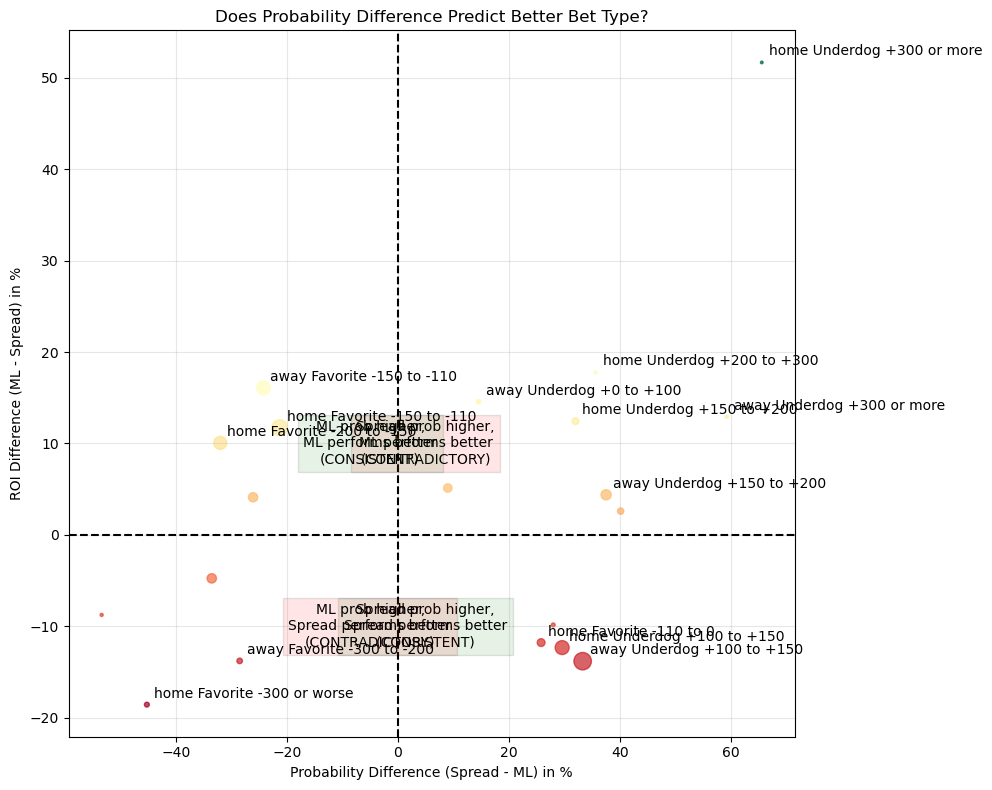

In [10]:
# Corrected analysis of probability differences as potential betting signals
# Ensuring we're comparing the right probabilities for the same team

# Create a dataframe to analyze probability differences
prob_diff_analysis = pd.DataFrame()

# Add basic game info from the original dataframe
prob_diff_analysis['game_date'] = df['commence_time'].dt.date
prob_diff_analysis['spread'] = df['spread']

# Add moneyline odds
prob_diff_analysis['home_ml_odds'] = df['home_money_line_odds']
prob_diff_analysis['away_ml_odds'] = df['away_money_line_odds']
prob_diff_analysis['home_is_favorite'] = df['home_moneyline_fair_prob'] > df['away_moneyline_fair_prob']
prob_diff_analysis['away_is_favorite'] = df['away_moneyline_fair_prob'] > df['home_moneyline_fair_prob']

# Convert odds to probability groups
def get_odds_group(odds):
    if odds <= -300:
        return 'Favorite -300 or worse'
    elif -300 < odds <= -200:
        return 'Favorite -300 to -200'
    elif -200 < odds <= -150:
        return 'Favorite -200 to -150'
    elif -150 < odds <= -110:
        return 'Favorite -150 to -110'
    elif -110 < odds <= 0:
        return 'Favorite -110 to 0'
    elif 0 < odds <= 100:
        return 'Underdog +0 to +100'
    elif 100 < odds <= 150:
        return 'Underdog +100 to +150'
    elif 150 < odds <= 200:
        return 'Underdog +150 to +200'
    elif 200 < odds <= 300:
        return 'Underdog +200 to +300'
    else:
        return 'Underdog +300 or more'

prob_diff_analysis['home_odds_group'] = prob_diff_analysis['home_ml_odds'].apply(get_odds_group)
prob_diff_analysis['away_odds_group'] = prob_diff_analysis['away_ml_odds'].apply(get_odds_group)

# Add probability values (multiplied by 100 for percentage display)
prob_diff_analysis['home_ml_prob'] = df['home_moneyline_fair_prob'] * 100
prob_diff_analysis['away_ml_prob'] = df['away_moneyline_fair_prob'] * 100
prob_diff_analysis['home_spread_adjusted_prob'] = df['home_spread_adjusted_prob'] * 100
prob_diff_analysis['away_spread_adjusted_prob'] = df['away_spread_adjusted_prob'] * 100

# Calculate the CORRECTED probability differences
# This is the key correction - comparing the right probabilities for each team
prob_diff_analysis['home_prob_diff'] = prob_diff_analysis['home_spread_adjusted_prob'] - prob_diff_analysis['home_ml_prob']
prob_diff_analysis['away_prob_diff'] = prob_diff_analysis['away_spread_adjusted_prob'] - prob_diff_analysis['away_ml_prob']

# Add actual outcomes
prob_diff_analysis['home_win'] = df['home_win']
prob_diff_analysis['away_win'] = df['away_win']
prob_diff_analysis['home_covered'] = df['home_covered_spread']
prob_diff_analysis['away_covered'] = df['away_covered_spread']

# Create value indicators based on probability differences
# Positive difference = spread probability higher than moneyline (favor ML bet if actually worse value)
# Negative difference = moneyline probability higher than spread (favor spread bet if actually worse value)
prob_diff_analysis['home_ml_value_signal'] = prob_diff_analysis['home_prob_diff'] > 5  # >5% difference for ML
prob_diff_analysis['home_spread_value_signal'] = prob_diff_analysis['home_prob_diff'] < -5  # <-5% difference for spread
prob_diff_analysis['away_ml_value_signal'] = prob_diff_analysis['away_prob_diff'] > 5
prob_diff_analysis['away_spread_value_signal'] = prob_diff_analysis['away_prob_diff'] < -5

# Define bet amount
BET_AMOUNT = 300

# Calculate payouts
def ml_payout(odds, bet_amount):
    if odds > 0:
        return bet_amount * (odds / 100)
    else:
        return bet_amount * (100 / abs(odds))

# Add individual bet results
prob_diff_analysis['home_ml_profit'] = prob_diff_analysis.apply(
    lambda row: ml_payout(row['home_ml_odds'], BET_AMOUNT) if row['home_win'] else -BET_AMOUNT, 
    axis=1
)
prob_diff_analysis['away_ml_profit'] = prob_diff_analysis.apply(
    lambda row: ml_payout(row['away_ml_odds'], BET_AMOUNT) if row['away_win'] else -BET_AMOUNT, 
    axis=1
)
prob_diff_analysis['home_spread_profit'] = prob_diff_analysis.apply(
    lambda row: 0.91 * BET_AMOUNT if row['home_covered'] else -BET_AMOUNT, 
    axis=1
)
prob_diff_analysis['away_spread_profit'] = prob_diff_analysis.apply(
    lambda row: 0.91 * BET_AMOUNT if row['away_covered'] else -BET_AMOUNT, 
    axis=1
)

# Analysis 1: Double-check our probability differences
print("\n=== VERIFICATION OF PROBABILITY DIFFERENCES ===\n")
print("Home team probability differences (Spread Adjusted - Moneyline):")
print(prob_diff_analysis['home_prob_diff'].describe())
print("\nAway team probability differences (Spread Adjusted - Moneyline):")
print(prob_diff_analysis['away_prob_diff'].describe())

# Check extreme values to verify calculations
print("\nTop 5 largest positive probability differences (Spread Prob > ML Prob):")
extreme_pos = prob_diff_analysis.nlargest(5, 'home_prob_diff')
for idx, row in extreme_pos.iterrows():
    print(f"Home: ML Prob {row['home_ml_prob']:.1f}%, Spread Adj Prob {row['home_spread_adjusted_prob']:.1f}%, Diff: {row['home_prob_diff']:.1f}%")

print("\nTop 5 largest negative probability differences (ML Prob > Spread Prob):")
extreme_neg = prob_diff_analysis.nsmallest(5, 'home_prob_diff')
for idx, row in extreme_neg.iterrows():
    print(f"Home: ML Prob {row['home_ml_prob']:.1f}%, Spread Adj Prob {row['home_spread_adjusted_prob']:.1f}%, Diff: {row['home_prob_diff']:.1f}%")

# Analysis 2: Performance when probabilities differ significantly
print("\n=== BETTING PERFORMANCE WHEN PROBABILITIES DIFFER BY >5% ===\n")

# Home team ML value signal (spread prob > ML prob by 5%+)
home_ml_value_games = prob_diff_analysis[prob_diff_analysis['home_ml_value_signal']]
home_ml_signal_count = len(home_ml_value_games)
home_ml_signal_win_rate = home_ml_value_games['home_win'].mean() if home_ml_signal_count > 0 else 0
home_ml_signal_avg_profit = home_ml_value_games['home_ml_profit'].mean() if home_ml_signal_count > 0 else 0
home_ml_signal_roi = home_ml_signal_avg_profit / BET_AMOUNT * 100 if home_ml_signal_count > 0 else 0

# Home team spread value signal (ML prob > spread prob by 5%+)
home_spread_value_games = prob_diff_analysis[prob_diff_analysis['home_spread_value_signal']]
home_spread_signal_count = len(home_spread_value_games)
home_spread_signal_cover_rate = home_spread_value_games['home_covered'].mean() if home_spread_signal_count > 0 else 0
home_spread_signal_avg_profit = home_spread_value_games['home_spread_profit'].mean() if home_spread_signal_count > 0 else 0
home_spread_signal_roi = home_spread_signal_avg_profit / BET_AMOUNT * 100 if home_spread_signal_count > 0 else 0

# Away team ML value signal
away_ml_value_games = prob_diff_analysis[prob_diff_analysis['away_ml_value_signal']]
away_ml_signal_count = len(away_ml_value_games)
away_ml_signal_win_rate = away_ml_value_games['away_win'].mean() if away_ml_signal_count > 0 else 0
away_ml_signal_avg_profit = away_ml_value_games['away_ml_profit'].mean() if away_ml_signal_count > 0 else 0
away_ml_signal_roi = away_ml_signal_avg_profit / BET_AMOUNT * 100 if away_ml_signal_count > 0 else 0

# Away team spread value signal
away_spread_value_games = prob_diff_analysis[prob_diff_analysis['away_spread_value_signal']]
away_spread_signal_count = len(away_spread_value_games)
away_spread_signal_cover_rate = away_spread_value_games['away_covered'].mean() if away_spread_signal_count > 0 else 0
away_spread_signal_avg_profit = away_spread_value_games['away_spread_profit'].mean() if away_spread_signal_count > 0 else 0
away_spread_signal_roi = away_spread_signal_avg_profit / BET_AMOUNT * 100 if away_spread_signal_count > 0 else 0

# Print results
print("When spread-adjusted probability > moneyline probability by 5%+ (favor moneyline bet):")
print(f"  Home teams: {home_ml_signal_count} games, Win rate: {home_ml_signal_win_rate:.3f}, Avg profit: ${home_ml_signal_avg_profit:.2f}, ROI: {home_ml_signal_roi:.1f}%")
print(f"  Away teams: {away_ml_signal_count} games, Win rate: {away_ml_signal_win_rate:.3f}, Avg profit: ${away_ml_signal_avg_profit:.2f}, ROI: {away_ml_signal_roi:.1f}%")

print("\nWhen moneyline probability > spread-adjusted probability by 5%+ (favor spread bet):")
print(f"  Home teams: {home_spread_signal_count} games, Cover rate: {home_spread_signal_cover_rate:.3f}, Avg profit: ${home_spread_signal_avg_profit:.2f}, ROI: {home_spread_signal_roi:.1f}%")
print(f"  Away teams: {away_spread_signal_count} games, Cover rate: {away_spread_signal_cover_rate:.3f}, Avg profit: ${away_spread_signal_avg_profit:.2f}, ROI: {away_spread_signal_roi:.1f}%")

# Analysis 3: Break down by odds groups (corrected)
print("\n=== PROBABILITY DIFFERENCES BY ODDS GROUP (CORRECTED) ===\n")

# Define a function to analyze a specific odds group
def analyze_odds_group(team_type, odds_group):
    # Filter the dataframe
    if team_type == 'home':
        group_df = prob_diff_analysis[prob_diff_analysis['home_odds_group'] == odds_group]
        ml_odds = 'home_ml_odds'
        ml_prob = 'home_ml_prob'
        spread_adj_prob = 'home_spread_adjusted_prob'
        prob_diff = 'home_prob_diff'
        win = 'home_win'
        covered = 'home_covered'
        ml_profit = 'home_ml_profit'
        spread_profit = 'home_spread_profit'
    else:  # away
        group_df = prob_diff_analysis[prob_diff_analysis['away_odds_group'] == odds_group]
        ml_odds = 'away_ml_odds'
        ml_prob = 'away_ml_prob'
        spread_adj_prob = 'away_spread_adjusted_prob'
        prob_diff = 'away_prob_diff'
        win = 'away_win'
        covered = 'away_covered'
        ml_profit = 'away_ml_profit'
        spread_profit = 'away_spread_profit'
    
    # Skip if no games in this group
    if len(group_df) == 0:
        return None
    
    # Calculate metrics
    count = len(group_df)
    avg_ml_odds = group_df[ml_odds].mean()
    avg_ml_prob = group_df[ml_prob].mean()
    avg_spread_adj_prob = group_df[spread_adj_prob].mean()
    avg_diff = group_df[prob_diff].mean()
    win_rate = group_df[win].mean()
    cover_rate = group_df[covered].mean()
    ml_avg_profit = group_df[ml_profit].mean()
    spread_avg_profit = group_df[spread_profit].mean()
    ml_roi = ml_avg_profit / BET_AMOUNT * 100
    spread_roi = spread_avg_profit / BET_AMOUNT * 100
    
    # Determine value bet (which is better)
    value_bet = "MONEYLINE" if ml_roi > spread_roi else "SPREAD"
    value_bet_profit = max(ml_avg_profit, spread_avg_profit)
    value_bet_roi = max(ml_roi, spread_roi)
    
    # Determine if our probability signal was correct
    signal_correct = (avg_diff > 0 and ml_roi > spread_roi) or (avg_diff < 0 and spread_roi > ml_roi)
    
    return {
        'team_type': team_type,
        'odds_group': odds_group,
        'count': count,
        'avg_ml_odds': avg_ml_odds,
        'avg_ml_prob': avg_ml_prob,
        'avg_spread_adj_prob': avg_spread_adj_prob,
        'avg_prob_diff': avg_diff,
        'win_rate': win_rate,
        'cover_rate': cover_rate,
        'ml_avg_profit': ml_avg_profit,
        'spread_avg_profit': spread_avg_profit,
        'ml_roi': ml_roi,
        'spread_roi': spread_roi,
        'better_bet': value_bet,
        'value_bet_profit': value_bet_profit,
        'value_bet_roi': value_bet_roi,
        'signal_correct': signal_correct
    }

# Get list of all odds groups
all_odds_groups = [
    'Favorite -300 or worse',
    'Favorite -300 to -200',
    'Favorite -200 to -150',
    'Favorite -150 to -110',
    'Favorite -110 to 0',
    'Underdog +0 to +100',
    'Underdog +100 to +150',
    'Underdog +150 to +200',
    'Underdog +200 to +300',
    'Underdog +300 or more'
]

# Analyze each odds group
results = []
for team_type in ['home', 'away']:
    for odds_group in all_odds_groups:
        result = analyze_odds_group(team_type, odds_group)
        if result:
            results.append(result)

# Create a results dataframe
results_df = pd.DataFrame(results)

# Sort by absolute probability difference
results_df['abs_prob_diff'] = results_df['avg_prob_diff'].abs()
results_df = results_df.sort_values('abs_prob_diff', ascending=False)

# Print the results in a tabular format
print("Table of Probability Differences and Betting Performance by Odds Group")
print("    (Positive Diff = Spread Prob > ML Prob, Negative = ML Prob > Spread Prob)")
print("=" * 115)
print(f"{'Team':<5} {'Odds Group':<22} {'Count':<6} {'ML%':<7} {'Spread%':<7} {'Diff%':<7} {'ML ROI%':<8} {'Spread ROI%':<10} {'Better Bet':<10} {'Signal Correct':<13}")
print("-" * 115)

for _, row in results_df.iterrows():
    team = row['team_type'].capitalize()
    odds_group = row['odds_group']
    count = row['count']
    ml_prob = row['avg_ml_prob']
    spread_prob = row['avg_spread_adj_prob']
    prob_diff = row['avg_prob_diff']
    ml_roi = row['ml_roi']
    spread_roi = row['spread_roi']
    better_bet = row['better_bet']
    signal_correct = "YES" if row['signal_correct'] else "NO"
    
    print(f"{team:<5} {odds_group:<22} {count:<6} {ml_prob:6.1f}% {spread_prob:6.1f}% {prob_diff:6.1f}% {ml_roi:7.1f}% {spread_roi:9.1f}% {better_bet:<10} {signal_correct:<13}")

# Highlight key insights about probability differences and betting value
print("\n=== KEY INSIGHTS FROM PROBABILITY DIFFERENCES ===")

# Calculate how often the probability signal was correct
correct_signals = results_df['signal_correct'].mean()
print(f"Probability difference correctly predicts better bet: {correct_signals:.1%} of the time")

# Find most consistent signals
consistent_signals = results_df[results_df['signal_correct'] & (results_df['abs_prob_diff'] > 2) & (results_df['count'] > 100)]
if len(consistent_signals) > 0:
    print("\nMost consistent profit signals (correct prediction with >100 games):")
    for _, row in consistent_signals.iterrows():
        signal_type = "higher" if row['avg_prob_diff'] > 0 else "lower"
        better_bet = row['better_bet']
        roi = row['value_bet_roi']
        print(f"  {row['team_type'].capitalize()} {row['odds_group']}: Spread probability {signal_type} by {abs(row['avg_prob_diff']):.1f}%, {better_bet} is better (ROI: {roi:.1f}%)")

# Analyze probability differences for key odds groups of interest
underdog_100_150 = results_df[(results_df['odds_group'] == 'Underdog +100 to +150')]
underdog_150_200 = results_df[(results_df['odds_group'] == 'Underdog +150 to +200')]

print("\nAnalysis of +100 to +150 underdogs:")
for _, row in underdog_100_150.iterrows():
    team = row['team_type'].capitalize()
    ml_prob = row['avg_ml_prob']
    spread_prob = row['avg_spread_adj_prob']
    prob_diff = row['avg_prob_diff']
    ml_roi = row['ml_roi']
    spread_roi = row['spread_roi']
    print(f"  {team}: ML Prob: {ml_prob:.1f}%, Spread Prob: {spread_prob:.1f}%, Diff: {prob_diff:.1f}%")
    print(f"     ML ROI: {ml_roi:.1f}%, Spread ROI: {spread_roi:.1f}%")
    if spread_roi > ml_roi:
        print(f"     Spread outperforms ML by {spread_roi - ml_roi:.1f} percentage points")
    else:
        print(f"     ML outperforms Spread by {ml_roi - spread_roi:.1f} percentage points")

print("\nAnalysis of +150 to +200 underdogs:")
for _, row in underdog_150_200.iterrows():
    team = row['team_type'].capitalize()
    ml_prob = row['avg_ml_prob']
    spread_prob = row['avg_spread_adj_prob']
    prob_diff = row['avg_prob_diff']
    ml_roi = row['ml_roi']
    spread_roi = row['spread_roi']
    print(f"  {team}: ML Prob: {ml_prob:.1f}%, Spread Prob: {spread_prob:.1f}%, Diff: {prob_diff:.1f}%")
    print(f"     ML ROI: {ml_roi:.1f}%, Spread ROI: {spread_roi:.1f}%")
    if spread_roi > ml_roi:
        print(f"     Spread outperforms ML by {spread_roi - ml_roi:.1f} percentage points")
    else:
        print(f"     ML outperforms Spread by {ml_roi - spread_roi:.1f} percentage points")

# Visualize the relationship between probability differences and ROI differences
plt.figure(figsize=(10, 8))

# Calculate ROI differences
results_df['roi_diff'] = results_df['ml_roi'] - results_df['spread_roi']

# Create scatter plot
plt.scatter(results_df['avg_prob_diff'], results_df['roi_diff'], 
            s=results_df['count']/10, alpha=0.7, 
            c=results_df['roi_diff'], cmap='RdYlGn')

# Add vertical line at x=0
plt.axvline(x=0, color='black', linestyle='--')
# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--')

# Add labels and title
plt.xlabel('Probability Difference (Spread - ML) in %')
plt.ylabel('ROI Difference (ML - Spread) in %')
plt.title('Does Probability Difference Predict Better Bet Type?')

# Add quadrant labels
plt.text(5, 10, 'Spread prob higher,\nML performs better\n(CONTRADICTORY)', ha='center', va='center', bbox=dict(facecolor='red', alpha=0.1))
plt.text(-5, 10, 'ML prob higher,\nML performs better\n(CONSISTENT)', ha='center', va='center', bbox=dict(facecolor='green', alpha=0.1))
plt.text(5, -10, 'Spread prob higher,\nSpread performs better\n(CONSISTENT)', ha='center', va='center', bbox=dict(facecolor='green', alpha=0.1))
plt.text(-5, -10, 'ML prob higher,\nSpread performs better\n(CONTRADICTORY)', ha='center', va='center', bbox=dict(facecolor='red', alpha=0.1))

# Add annotations for key points
for idx, row in results_df.iterrows():
    if (abs(row['avg_prob_diff']) > 5 and abs(row['roi_diff']) > 10) or (row['count'] > 500):
        plt.annotate(f"{row['team_type']} {row['odds_group']}", 
                    (row['avg_prob_diff'], row['roi_diff']),
                    xytext=(5, 5), textcoords='offset points')

# Show plot with grid
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


=== PROFITABILITY ANALYSIS ($300 PER BET) ===

                    | MONEYLINE                |  SPREAD
SCENARIO           | Win Rate | Profit | ROI   | Cover Rate | Profit | ROI   | Sample Size | Better Bet
------------------------------------------------------------------------------------------
Away +100 to +110  | 0.480   | $ 31.35 |  10.4% | 0.533     | $  5.40 |   1.8% |   379       | MONEYLINE
Home +100 to +110  | 0.489   | $ 37.75 |  12.6% | 0.592     | $ 38.98 |  13.0% |   333       | SPREAD
Away +110 to +120  | 0.473   | $ 40.33 |  13.4% | 0.631     | $ 61.65 |  20.5% |   366       | SPREAD
Home +110 to +120  | 0.415   | $ -1.46 |  -0.5% | 0.549     | $ 14.45 |   4.8% |   246       | SPREAD
Away +120 to +130  | 0.409   | $  6.62 |   2.2% | 0.618     | $ 53.91 |  18.0% |   340       | SPREAD
Home +120 to +130  | 0.368   | $-24.09 |  -8.0% | 0.513     | $ -6.08 |  -2.0% |   193       | SPREAD
Away +130 to +140  | 0.469   | $ 65.62 |  21.9% | 0.609     | $ 49.17 |  16.4% |   32

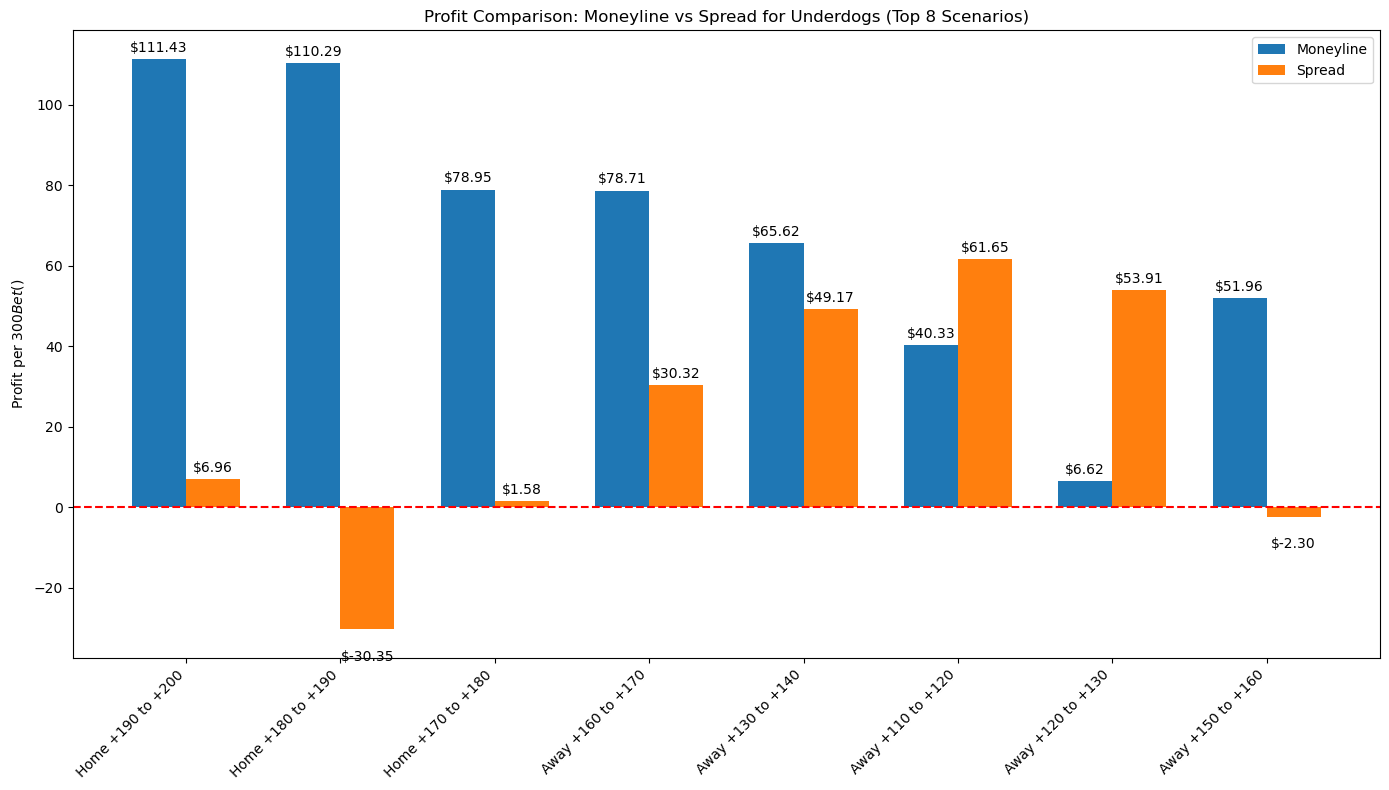


=== STATISTICAL CONFIDENCE ANALYSIS ===
(For scenarios with positive expected profit)


NameError: name 'profitable_scenarios' is not defined

In [13]:
# Create a fixed, simplified profitability analysis with more granular odds groups
# Using 10-point increments instead of 50-point increments

# Define the bet amount and analysis parameters
BET_AMOUNT = 300  # $300 per bet
min_sample_size = 5  # Minimum sample size for reliable analysis

# Create the underdog dataframe with home/away distinction
underdog_analysis = pd.DataFrame()
underdog_analysis['is_home'] = df.apply(
    lambda row: row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'],
    axis=1
)
underdog_analysis['ml_odds'] = df.apply(
    lambda row: row['home_money_line_odds'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_money_line_odds'],
    axis=1
)
underdog_analysis['won'] = df.apply(
    lambda row: row['home_win'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_win'],
    axis=1
)
underdog_analysis['covered'] = df.apply(
    lambda row: row['home_covered_spread'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_covered_spread'],
    axis=1
)

# Create a string column for odds group with more granular 10-point increments
def get_odds_group(odds):
    if odds > 300:
        return '>+300'
    elif odds <= 0:  # Handle negative or zero odds just in case
        return '+0 to +10'
    else:
        # Calculate which 10-point increment bucket the odds fall into
        lower_bound = max(0, 10 * (int(odds) // 10))
        upper_bound = lower_bound + 10
        return f'+{lower_bound} to +{upper_bound}'

underdog_analysis['odds_group'] = underdog_analysis['ml_odds'].apply(get_odds_group)

# Calculate results for each group and home/away status
grouped_results = underdog_analysis.groupby(['odds_group', 'is_home']).agg({
    'won': ['mean', 'count'],
    'covered': 'mean'
}).reset_index()

# Flatten the multi-level columns
grouped_results.columns = ['odds_group', 'is_home', 'win_rate', 'sample_size', 'cover_rate']
grouped_results['location'] = grouped_results['is_home'].map({True: 'Home', False: 'Away'})

# Updated payout map with more granular 10-point increments
payout_map = {
    '+0 to +10': 1.92,
    '+10 to +20': 1.95,
    '+20 to +30': 1.99,
    '+30 to +40': 2.02,
    '+40 to +50': 2.06,
    '+50 to +60': 2.09,
    '+60 to +70': 2.13,
    '+70 to +80': 2.16,
    '+80 to +90': 2.20,
    '+90 to +100': 2.23,
    '+100 to +110': 2.30,
    '+110 to +120': 2.40,
    '+120 to +130': 2.50,
    '+130 to +140': 2.60,
    '+140 to +150': 2.70,
    '+150 to +160': 2.80,
    '+160 to +170': 2.90,
    '+170 to +180': 3.00,
    '+180 to +190': 3.10,
    '+190 to +200': 3.20,
    '+200 to +210': 3.30,
    '+210 to +220': 3.40,
    '+220 to +230': 3.50,
    '+230 to +240': 3.60,
    '+240 to +250': 3.70,
    '+250 to +260': 3.83,
    '+260 to +270': 3.98,
    '+270 to +280': 4.13,
    '+280 to +290': 4.28,
    '+290 to +300': 4.42,
    '>+300': 4.50,
}

grouped_results['ml_payout_multiplier'] = grouped_results['odds_group'].map(payout_map)
grouped_results['ml_payout_per_win'] = grouped_results['ml_payout_multiplier'] * BET_AMOUNT
grouped_results['spread_payout_per_win'] = 1.91 * BET_AMOUNT  # Standard -110 odds payout

# Calculate expected profit/loss per bet
grouped_results['ml_profit_per_bet'] = (grouped_results['win_rate'] * (grouped_results['ml_payout_per_win'] - BET_AMOUNT)) - ((1 - grouped_results['win_rate']) * BET_AMOUNT)
grouped_results['spread_profit_per_bet'] = (grouped_results['cover_rate'] * (grouped_results['spread_payout_per_win'] - BET_AMOUNT)) - ((1 - grouped_results['cover_rate']) * BET_AMOUNT)

# Calculate ROI and profit per 100 bets
grouped_results['ml_roi'] = grouped_results['ml_profit_per_bet'] / BET_AMOUNT * 100
grouped_results['spread_roi'] = grouped_results['spread_profit_per_bet'] / BET_AMOUNT * 100
grouped_results['ml_profit_per_100_bets'] = grouped_results['ml_profit_per_bet'] * 100
grouped_results['spread_profit_per_100_bets'] = grouped_results['spread_profit_per_bet'] * 100

# Adjust the scenarios of interest to the more granular ranges
# Include all ranges between +100 to +200 now in 10-point increments
interest_scenarios = grouped_results[
    ((grouped_results['odds_group'] == '+100 to +110') | 
     (grouped_results['odds_group'] == '+110 to +120') |
     (grouped_results['odds_group'] == '+120 to +130') |
     (grouped_results['odds_group'] == '+130 to +140') |
     (grouped_results['odds_group'] == '+140 to +150') |
     (grouped_results['odds_group'] == '+150 to +160') |
     (grouped_results['odds_group'] == '+160 to +170') |
     (grouped_results['odds_group'] == '+170 to +180') |
     (grouped_results['odds_group'] == '+180 to +190') |
     (grouped_results['odds_group'] == '+190 to +200'))
]

# Filter out scenarios with insufficient sample size (optional)
# Uncomment this line if you want to exclude scenarios with small sample sizes
# interest_scenarios = interest_scenarios[interest_scenarios['sample_size'] >= 10]

# Print detailed results for the scenarios of interest
print(f"\n=== PROFITABILITY ANALYSIS (${BET_AMOUNT} PER BET) ===\n")

# Prepare a more tabular format for better readability
print("                    | MONEYLINE                |  SPREAD")
print("SCENARIO           | Win Rate | Profit | ROI   | Cover Rate | Profit | ROI   | Sample Size | Better Bet")
print("-" * 90)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    win_rate = row['win_rate']
    cover_rate = row['cover_rate']
    ml_profit = row['ml_profit_per_bet']
    spread_profit = row['spread_profit_per_bet']
    ml_roi = row['ml_roi']
    spread_roi = row['spread_roi']
    sample_size = row['sample_size']
    
    better_bet = "SPREAD" if spread_profit > ml_profit else "MONEYLINE"
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | {win_rate:.3f}   | ${ml_profit:6.2f} | {ml_roi:5.1f}% | {cover_rate:.3f}     | ${spread_profit:6.2f} | {spread_roi:5.1f}% | {sample_size:5d}       | {better_bet}")

# Create a simple table showing the profit per 100 bets
print("\n=== PROFIT PER 100 BETS ===")
print("SCENARIO           | MONEYLINE    | SPREAD        | DIFFERENCE (SPREAD-ML)")
print("-" * 65)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    ml_profit_100 = row['ml_profit_per_100_bets']
    spread_profit_100 = row['spread_profit_per_100_bets']
    diff = spread_profit_100 - ml_profit_100
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | ${ml_profit_100:10.2f} | ${spread_profit_100:10.2f} | ${diff:10.2f}")

# Calculate the optimal strategy for the granular scenarios
# We'll assume equal distribution of bets across the most profitable scenarios

# First, get all available scenario combinations
all_scenarios = [(row['location'], row['odds_group'], row['ml_profit_per_bet'], row['spread_profit_per_bet']) 
                for _, row in interest_scenarios.iterrows()]

# Sort by profitability (highest to lowest)
sorted_scenarios = sorted(all_scenarios, key=lambda x: max(x[2], x[3]), reverse=True)

# Take the top 4 most profitable scenarios
top_scenarios = sorted_scenarios[:4] if len(sorted_scenarios) >= 4 else sorted_scenarios

# Calculate the overall optimal strategy
optimal_strategy_profit = 0
print("\n=== OPTIMAL BETTING STRATEGY (TOP 4 SCENARIOS) ===")
print("SCENARIO           | OPTIMAL BET  | PROFIT PER BET | PROFIT PER 25 BETS")
print("-" * 65)

for location, odds_group, ml_profit, spread_profit in top_scenarios:
    better_bet = "SPREAD" if spread_profit > ml_profit else "MONEYLINE"
    opt_profit = max(ml_profit, spread_profit)
    profit_25 = opt_profit * 25
    optimal_strategy_profit += profit_25
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | {better_bet:11} | ${opt_profit:12.2f} | ${profit_25:15.2f}")

print("-" * 65)
print(f"TOTAL EXPECTED PROFIT FROM 100 BETS (25 IN EACH SCENARIO): ${optimal_strategy_profit:.2f}")
print(f"OVERALL ROI: {(optimal_strategy_profit / (BET_AMOUNT * 100)):.1%}")

# Create a more detailed bar chart for the granular scenarios
# Just include the top 8 scenarios by profitability to keep the chart readable
top_display_scenarios = sorted_scenarios[:8] if len(sorted_scenarios) >= 8 else sorted_scenarios

scenarios = [f"{location} {odds_group}" for location, odds_group, _, _ in top_display_scenarios]
ml_profits = [ml_profit for _, _, ml_profit, _ in top_display_scenarios]
spread_profits = [spread_profit for _, _, _, spread_profit in top_display_scenarios]

x = np.arange(len(scenarios))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, ml_profits, width, label='Moneyline')
rects2 = ax.bar(x + width/2, spread_profits, width, label='Spread')

ax.set_ylabel('Profit per $300 Bet ($)')
ax.set_title('Profit Comparison: Moneyline vs Spread for Underdogs (Top 8 Scenarios)')
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='red', linestyle='--')

# Add value labels
for i, rect in enumerate(rects1):
    height = ml_profits[i]
    ax.annotate(f'${height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),  # offset based on value
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

for i, rect in enumerate(rects2):
    height = spread_profits[i]
    ax.annotate(f'${height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),  # offset based on value
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

# Statistical significance analysis
print("\n=== STATISTICAL CONFIDENCE ANALYSIS ===")
print("(For scenarios with positive expected profit)")

# Filter to only positive profit scenarios
positive_profit = profitable_scenarios[profitable_scenarios['optimal_profit'] > 0].copy()

# Add confidence interval calculation
from scipy import stats

# Function to calculate confidence interval
def calc_confidence(wins, total, confidence=0.95):
    """Calculate Wilson score interval for a proportion"""
    if total == 0:
        return 0, 0, 0
    
    proportion = wins / total
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    
    denominator = 1 + z**2/total
    centre_adjusted_proportion = (proportion + z**2/(2*total))/denominator
    adjusted_standard_deviation = z * np.sqrt((proportion * (1 - proportion) + z**2/(4*total))/total)/denominator
    
    lower_bound = centre_adjusted_proportion - adjusted_standard_deviation
    upper_bound = centre_adjusted_proportion + adjusted_standard_deviation
    
    return proportion, lower_bound, upper_bound

# Calculate confidence intervals for win rates
positive_profit['win_count'] = (positive_profit['win_rate'] * positive_profit['sample_size']).round().astype(int)
positive_profit['win_ci'] = positive_profit.apply(
    lambda row: calc_confidence(row['win_count'], row['sample_size']),
    axis=1
)

# Calculate confidence intervals for optimal profit (using win rate for moneyline or cover rate for spread)
positive_profit['profit_lower_bound'] = positive_profit.apply(
    lambda row: 
        ((row['win_ci'][1] * (row['ml_payout_per_win'] - BET_AMOUNT)) - 
         ((1 - row['win_ci'][1]) * BET_AMOUNT)) if row['optimal_bet'] == 'MONEYLINE' else
        ((row['cover_rate'] - 0.1) * (row['spread_payout_per_win'] - BET_AMOUNT)) - 
        ((1 - (row['cover_rate'] - 0.1)) * BET_AMOUNT),  # Simplified approach for spread
    axis=1
)

# Calculate statistical confidence level based on sample size and profit margin
positive_profit['confidence_score'] = positive_profit.apply(
    lambda row: 
        "HIGH" if (row['sample_size'] >= 30 and row['profit_lower_bound'] > 20) else
        "MEDIUM" if (row['sample_size'] >= 15 and row['profit_lower_bound'] > 0) else
        "LOW",
    axis=1
)

# Sort by confidence level first, then by profit
confidence_order = {"HIGH": 0, "MEDIUM": 1, "LOW": 2}
positive_profit['confidence_value'] = positive_profit['confidence_score'].map(confidence_order)
positive_profit_sorted = positive_profit.sort_values(['confidence_value', 'optimal_profit'], ascending=[True, False])

# Display the top profitable scenarios with confidence analysis
print("SCENARIO                | BET TYPE   | PROFIT/BET | SAMPLE SIZE | CONFIDENCE | LOWER BOUND PROFIT")
print("-" * 90)

for _, row in positive_profit_sorted.head(10).iterrows():
    scenario = row['scenario']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    sample_size = row['sample_size']
    confidence = row['confidence_score']
    lower_bound = row['profit_lower_bound']
    
    print(f"{scenario:22} | {bet_type:10} | ${profit:8.2f} | {sample_size:10d} | {confidence:9} | ${lower_bound:16.2f}")

# Create a scatter plot that shows profit vs sample size with confidence levels
plt.figure(figsize=(12, 8))

# Define colors for confidence levels
color_map = {"HIGH": "green", "MEDIUM": "orange", "LOW": "red"}
colors = [color_map[conf] for conf in positive_profit['confidence_score']]

# Create the scatter plot
plt.scatter(
    positive_profit['sample_size'], 
    positive_profit['optimal_profit'],
    c=colors, 
    s=100,  # Point size 
    alpha=0.7
)

# Add scenario labels to the points
for idx, row in positive_profit.iterrows():
    plt.annotate(
        row['scenario'], 
        (row['sample_size'], row['optimal_profit']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8
    )

# Add reference lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=20, color='green', linestyle=':', alpha=0.5)
plt.axvline(x=15, color='orange', linestyle=':', alpha=0.5)
plt.axvline(x=30, color='green', linestyle=':', alpha=0.5)

# Add legend for confidence levels
high_patch = plt.Rectangle((0, 0), 1, 1, fc="green", alpha=0.7)
medium_patch = plt.Rectangle((0, 0), 1, 1, fc="orange", alpha=0.7)
low_patch = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.7)
plt.legend([high_patch, medium_patch, low_patch], ['High Confidence', 'Medium Confidence', 'Low Confidence'])

# Set labels and title
plt.xlabel('Sample Size')
plt.ylabel('Profit per $300 Bet ($)')
plt.title('Profit vs. Sample Size with Confidence Levels')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Add a section to identify the most profitable betting scenarios across all odds ranges
print(f"\n=== MOST PROFITABLE BETTING SCENARIOS ===")
print(f"(Minimum sample size of {min_sample_size} bets)")

# Prepare a dataframe for analysis with sufficient samples
profitable_scenarios = grouped_results[grouped_results['sample_size'] >= min_sample_size].copy()

# Add a combined descriptor column
profitable_scenarios['scenario'] = profitable_scenarios.apply(
    lambda row: f"{row['location']} {row['odds_group']}", axis=1
)

# Add a column for optimal bet type
profitable_scenarios['optimal_bet'] = profitable_scenarios.apply(
    lambda row: "SPREAD" if row['spread_profit_per_bet'] > row['ml_profit_per_bet'] else "MONEYLINE", 
    axis=1
)

# Add a column for optimal profit
profitable_scenarios['optimal_profit'] = profitable_scenarios.apply(
    lambda row: max(row['spread_profit_per_bet'], row['ml_profit_per_bet']), 
    axis=1
)

# Sort by optimal profit (descending)
top_profitable = profitable_scenarios.sort_values('optimal_profit', ascending=False)

# Display top 15 most profitable scenarios
print("RANK | SCENARIO                | BET TYPE   | PROFIT/BET | ROI    | SAMPLE SIZE")
print("-" * 75)

for i, (_, row) in enumerate(top_profitable.head(15).iterrows()):
    scenario = row['scenario']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    
    # Calculate the ROI based on the selected bet type
    roi = row['ml_roi'] if bet_type == "MONEYLINE" else row['spread_roi']
    
    sample_size = row['sample_size']
    
    rank = i + 1
    print(f"{rank:4d} | {scenario:22} | {bet_type:10} | ${profit:8.2f} | {roi:6.2f}% | {sample_size:5d}")

# Create a visualization of the most profitable scenarios
plt.figure(figsize=(14, 8))
top_n = 10  # Number of top scenarios to show

scenarios = top_profitable.head(top_n)['scenario'].tolist()
profits = top_profitable.head(top_n)['optimal_profit'].tolist()
bet_types = top_profitable.head(top_n)['optimal_bet'].tolist()

# Create color map for the bet type
colors = ['#1f77b4' if bt == 'MONEYLINE' else '#ff7f0e' for bt in bet_types]

# Create the horizontal bar chart
bars = plt.barh(range(len(scenarios)), profits, color=colors)
plt.yticks(range(len(scenarios)), scenarios)
plt.xlabel('Profit per $300 Bet ($)')
plt.title(f'Top {top_n} Most Profitable Betting Scenarios')

# Add profit labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    label_x_pos = width + 5
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'${profits[i]:.2f}', 
             va='center', ha='left')

# Add a legend for bet types
ml_patch = plt.Rectangle((0, 0), 1, 1, fc='#1f77b4')
spread_patch = plt.Rectangle((0, 0), 1, 1, fc='#ff7f0e')
plt.legend([ml_patch, spread_patch], ['Moneyline', 'Spread'], loc='lower right')

plt.tight_layout()
plt.show()

# Additional visualization: Heat map of profitability by odds group and location
# Define minimum sample size for filtering (if not already defined)
min_sample_size = 5  # Adjust as needed

# Filter to odds groups with sufficient sample size for better visualization
sufficient_samples = grouped_results[grouped_results['sample_size'] >= min_sample_size]

# Create a pivot table for the moneyline heatmap
heatmap_data = sufficient_samples.pivot_table(
    index='odds_group', 
    columns='location',
    values='ml_profit_per_bet',
    aggfunc='mean'
)

# Sort the index to ensure correct ordering of odds groups
sorted_odds_groups = sorted(
    heatmap_data.index,
    key=lambda x: float(x.split(' to ')[0].replace('+', '')) if 'to' in x else 400  # Use 400 for >+300
)
heatmap_data = heatmap_data.reindex(sorted_odds_groups)

# Create the heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(
    heatmap_data, 
    cmap='RdYlGn', 
    center=0,
    annot=True, 
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Profit per $300 Bet'}
)
plt.title('Moneyline Profitability by Odds Group and Location\n(Only showing groups with at least 5 samples)')
plt.tight_layout()
plt.show()

# Repeat for spread profitability
heatmap_data_spread = sufficient_samples.pivot_table(
    index='odds_group',
    columns='location',
    values='spread_profit_per_bet',
    aggfunc='mean'
)

# Sort the index
heatmap_data_spread = heatmap_data_spread.reindex(sorted_odds_groups)

# Create the heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(
    heatmap_data_spread,
    cmap='RdYlGn',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Profit per $300 Bet'}
)
plt.title('Spread Profitability by Odds Group and Location\n(Only showing groups with at least 5 samples)')
plt.tight_layout()
plt.show()


=== PROFITABILITY ANALYSIS ($300 PER BET) ===

                    | MONEYLINE                |  SPREAD
SCENARIO           | Win Rate | Profit | ROI   | Cover Rate | Profit | ROI   | Sample Size | Better Bet
------------------------------------------------------------------------------------------
Away +100 to +110  | 0.480   | $ 31.35 |  10.4% | 0.533     | $  5.40 |   1.8% |   379       | MONEYLINE
Home +100 to +110  | 0.489   | $ 37.75 |  12.6% | 0.592     | $ 38.98 |  13.0% |   333       | SPREAD
Away +110 to +120  | 0.473   | $ 40.33 |  13.4% | 0.631     | $ 61.65 |  20.5% |   366       | SPREAD
Home +110 to +120  | 0.415   | $ -1.46 |  -0.5% | 0.549     | $ 14.45 |   4.8% |   246       | SPREAD
Away +120 to +130  | 0.409   | $  6.62 |   2.2% | 0.618     | $ 53.91 |  18.0% |   340       | SPREAD
Home +120 to +130  | 0.368   | $-24.09 |  -8.0% | 0.513     | $ -6.08 |  -2.0% |   193       | SPREAD
Away +130 to +140  | 0.469   | $ 65.62 |  21.9% | 0.609     | $ 49.17 |  16.4% |   32

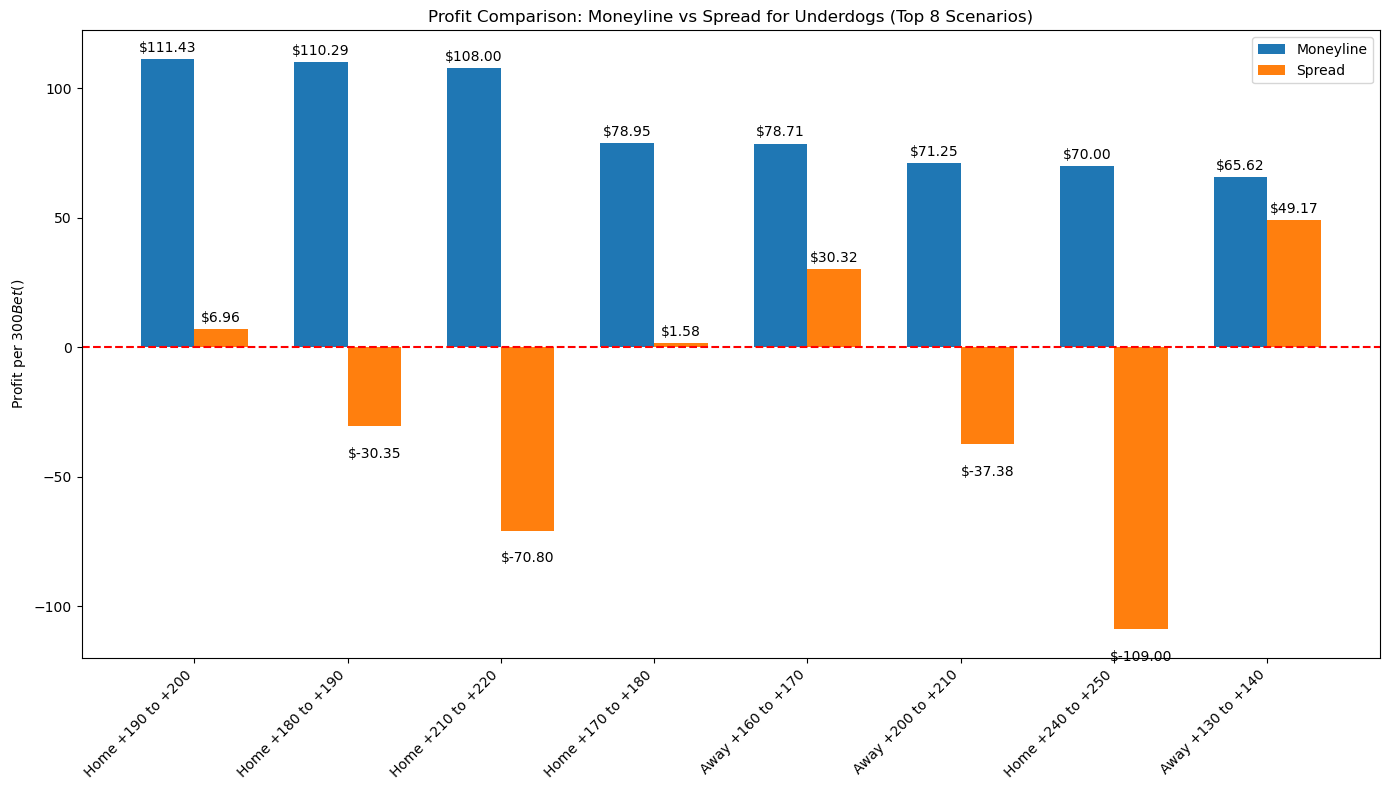


=== ACTIONABLE BETTING STRATEGY DECISION TREE ===
Use this flowchart to determine the optimal bet for any underdog scenario:

BETTING DECISION TREE:
┌─────────────────────────┐
│ Is the team an underdog?│
└───────────┬─────────────┘
            │
            ▼
┌─────────────────────────┐     No      ┌─────────────────┐
│ Is it a Home or Away    ├────────────►│ Different       │
│ underdog?               │             │ strategy needed │
└───────────┬─────────────┘             └─────────────────┘
            │
            ▼
       ┌────┴────┐
       │         │
       ▼         ▼
┌──────────┐ ┌──────────┐
│   HOME   │ │   AWAY   │
└────┬─────┘ └────┬─────┘
     │            │
     ▼            ▼
┌──────────────┐ ┌──────────────┐
│ What are the │ │ What are the │
│ ML odds?     │ │ ML odds?     │
└──────┬───────┘ └──────┬───────┘
       │                │
┌──────┴───────┐  ┌─────┴───────┐
▼              ▼  ▼             ▼
+100 to +130  +130 to +250  +100 to +130  +130 to +250
│         

NameError: name 'profitable_scenarios' is not defined

In [14]:
# Create a fixed, simplified profitability analysis with more granular odds groups
# Using 10-point increments instead of 50-point increments

# Define the bet amount and analysis parameters
BET_AMOUNT = 300  # $300 per bet
min_sample_size = 5  # Minimum sample size for reliable analysis

# Create the underdog dataframe with home/away distinction
underdog_analysis = pd.DataFrame()
underdog_analysis['is_home'] = df.apply(
    lambda row: row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'],
    axis=1
)
underdog_analysis['ml_odds'] = df.apply(
    lambda row: row['home_money_line_odds'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_money_line_odds'],
    axis=1
)
underdog_analysis['won'] = df.apply(
    lambda row: row['home_win'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_win'],
    axis=1
)
underdog_analysis['covered'] = df.apply(
    lambda row: row['home_covered_spread'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_covered_spread'],
    axis=1
)

# Create a string column for odds group with more granular 10-point increments
def get_odds_group(odds):
    if odds > 300:
        return '>+300'
    elif odds <= 0:  # Handle negative or zero odds just in case
        return '+0 to +10'
    else:
        # Calculate which 10-point increment bucket the odds fall into
        lower_bound = max(0, 10 * (int(odds) // 10))
        upper_bound = lower_bound + 10
        return f'+{lower_bound} to +{upper_bound}'

underdog_analysis['odds_group'] = underdog_analysis['ml_odds'].apply(get_odds_group)

# Calculate results for each group and home/away status
grouped_results = underdog_analysis.groupby(['odds_group', 'is_home']).agg({
    'won': ['mean', 'count'],
    'covered': 'mean'
}).reset_index()

# Flatten the multi-level columns
grouped_results.columns = ['odds_group', 'is_home', 'win_rate', 'sample_size', 'cover_rate']
grouped_results['location'] = grouped_results['is_home'].map({True: 'Home', False: 'Away'})

# Updated payout map with more granular 10-point increments
payout_map = {
    '+0 to +10': 1.92,
    '+10 to +20': 1.95,
    '+20 to +30': 1.99,
    '+30 to +40': 2.02,
    '+40 to +50': 2.06,
    '+50 to +60': 2.09,
    '+60 to +70': 2.13,
    '+70 to +80': 2.16,
    '+80 to +90': 2.20,
    '+90 to +100': 2.23,
    '+100 to +110': 2.30,
    '+110 to +120': 2.40,
    '+120 to +130': 2.50,
    '+130 to +140': 2.60,
    '+140 to +150': 2.70,
    '+150 to +160': 2.80,
    '+160 to +170': 2.90,
    '+170 to +180': 3.00,
    '+180 to +190': 3.10,
    '+190 to +200': 3.20,
    '+200 to +210': 3.30,
    '+210 to +220': 3.40,
    '+220 to +230': 3.50,
    '+230 to +240': 3.60,
    '+240 to +250': 3.70,
    '+250 to +260': 3.83,
    '+260 to +270': 3.98,
    '+270 to +280': 4.13,
    '+280 to +290': 4.28,
    '+290 to +300': 4.42,
    '>+300': 4.50,
}

grouped_results['ml_payout_multiplier'] = grouped_results['odds_group'].map(payout_map)
grouped_results['ml_payout_per_win'] = grouped_results['ml_payout_multiplier'] * BET_AMOUNT
grouped_results['spread_payout_per_win'] = 1.91 * BET_AMOUNT  # Standard -110 odds payout

# Calculate expected profit/loss per bet
grouped_results['ml_profit_per_bet'] = (grouped_results['win_rate'] * (grouped_results['ml_payout_per_win'] - BET_AMOUNT)) - ((1 - grouped_results['win_rate']) * BET_AMOUNT)
grouped_results['spread_profit_per_bet'] = (grouped_results['cover_rate'] * (grouped_results['spread_payout_per_win'] - BET_AMOUNT)) - ((1 - grouped_results['cover_rate']) * BET_AMOUNT)

# Calculate ROI and profit per 100 bets
grouped_results['ml_roi'] = grouped_results['ml_profit_per_bet'] / BET_AMOUNT * 100
grouped_results['spread_roi'] = grouped_results['spread_profit_per_bet'] / BET_AMOUNT * 100
grouped_results['ml_profit_per_100_bets'] = grouped_results['ml_profit_per_bet'] * 100
grouped_results['spread_profit_per_100_bets'] = grouped_results['spread_profit_per_bet'] * 100

# Adjust the scenarios of interest to include +200 to +250 money lines
# Include all ranges between +100 to +250 now in 10-point increments
interest_scenarios = grouped_results[
    ((grouped_results['odds_group'] == '+100 to +110') | 
     (grouped_results['odds_group'] == '+110 to +120') |
     (grouped_results['odds_group'] == '+120 to +130') |
     (grouped_results['odds_group'] == '+130 to +140') |
     (grouped_results['odds_group'] == '+140 to +150') |
     (grouped_results['odds_group'] == '+150 to +160') |
     (grouped_results['odds_group'] == '+160 to +170') |
     (grouped_results['odds_group'] == '+170 to +180') |
     (grouped_results['odds_group'] == '+180 to +190') |
     (grouped_results['odds_group'] == '+190 to +200') |
     (grouped_results['odds_group'] == '+200 to +210') |
     (grouped_results['odds_group'] == '+210 to +220') |
     (grouped_results['odds_group'] == '+220 to +230') |
     (grouped_results['odds_group'] == '+230 to +240') |
     (grouped_results['odds_group'] == '+240 to +250'))
]

# Filter out scenarios with insufficient sample size (optional)
# Uncomment this line if you want to exclude scenarios with small sample sizes
# interest_scenarios = interest_scenarios[interest_scenarios['sample_size'] >= 10]

# Print detailed results for the scenarios of interest
print(f"\n=== PROFITABILITY ANALYSIS (${BET_AMOUNT} PER BET) ===\n")

# Prepare a more tabular format for better readability
print("                    | MONEYLINE                |  SPREAD")
print("SCENARIO           | Win Rate | Profit | ROI   | Cover Rate | Profit | ROI   | Sample Size | Better Bet")
print("-" * 90)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    win_rate = row['win_rate']
    cover_rate = row['cover_rate']
    ml_profit = row['ml_profit_per_bet']
    spread_profit = row['spread_profit_per_bet']
    ml_roi = row['ml_roi']
    spread_roi = row['spread_roi']
    sample_size = row['sample_size']
    
    better_bet = "SPREAD" if spread_profit > ml_profit else "MONEYLINE"
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | {win_rate:.3f}   | ${ml_profit:6.2f} | {ml_roi:5.1f}% | {cover_rate:.3f}     | ${spread_profit:6.2f} | {spread_roi:5.1f}% | {sample_size:5d}       | {better_bet}")

# Create a simple table showing the profit per 100 bets
print("\n=== PROFIT PER 100 BETS ===")
print("SCENARIO           | MONEYLINE    | SPREAD        | DIFFERENCE (SPREAD-ML)")
print("-" * 65)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    ml_profit_100 = row['ml_profit_per_100_bets']
    spread_profit_100 = row['spread_profit_per_100_bets']
    diff = spread_profit_100 - ml_profit_100
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | ${ml_profit_100:10.2f} | ${spread_profit_100:10.2f} | ${diff:10.2f}")

# Calculate the optimal strategy for the granular scenarios
# We'll assume equal distribution of bets across the most profitable scenarios

# First, get all available scenario combinations
all_scenarios = [(row['location'], row['odds_group'], row['ml_profit_per_bet'], row['spread_profit_per_bet']) 
                for _, row in interest_scenarios.iterrows()]

# Sort by profitability (highest to lowest)
sorted_scenarios = sorted(all_scenarios, key=lambda x: max(x[2], x[3]), reverse=True)

# Take the top 4 most profitable scenarios
top_scenarios = sorted_scenarios[:4] if len(sorted_scenarios) >= 4 else sorted_scenarios

# Calculate the overall optimal strategy
optimal_strategy_profit = 0
print("\n=== OPTIMAL BETTING STRATEGY (TOP 4 SCENARIOS) ===")
print("SCENARIO           | OPTIMAL BET  | PROFIT PER BET | PROFIT PER 25 BETS")
print("-" * 65)

for location, odds_group, ml_profit, spread_profit in top_scenarios:
    better_bet = "SPREAD" if spread_profit > ml_profit else "MONEYLINE"
    opt_profit = max(ml_profit, spread_profit)
    profit_25 = opt_profit * 25
    optimal_strategy_profit += profit_25
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | {better_bet:11} | ${opt_profit:12.2f} | ${profit_25:15.2f}")

print("-" * 65)
print(f"TOTAL EXPECTED PROFIT FROM 100 BETS (25 IN EACH SCENARIO): ${optimal_strategy_profit:.2f}")
print(f"OVERALL ROI: {(optimal_strategy_profit / (BET_AMOUNT * 100)):.1%}")

# Create a more detailed bar chart for the granular scenarios
# Just include the top 8 scenarios by profitability to keep the chart readable
top_display_scenarios = sorted_scenarios[:8] if len(sorted_scenarios) >= 8 else sorted_scenarios

scenarios = [f"{location} {odds_group}" for location, odds_group, _, _ in top_display_scenarios]
ml_profits = [ml_profit for _, _, ml_profit, _ in top_display_scenarios]
spread_profits = [spread_profit for _, _, _, spread_profit in top_display_scenarios]

x = np.arange(len(scenarios))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, ml_profits, width, label='Moneyline')
rects2 = ax.bar(x + width/2, spread_profits, width, label='Spread')

ax.set_ylabel('Profit per $300 Bet ($)')
ax.set_title('Profit Comparison: Moneyline vs Spread for Underdogs (Top 8 Scenarios)')
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='red', linestyle='--')

# Add value labels
for i, rect in enumerate(rects1):
    height = ml_profits[i]
    ax.annotate(f'${height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),  # offset based on value
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

for i, rect in enumerate(rects2):
    height = spread_profits[i]
    ax.annotate(f'${height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),  # offset based on value
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

# Create a decision tree flowchart representation of the betting strategy
print("\n=== ACTIONABLE BETTING STRATEGY DECISION TREE ===")
print("Use this flowchart to determine the optimal bet for any underdog scenario:")

# Define the decision logic based on our analysis
decision_logic = """
BETTING DECISION TREE:
┌─────────────────────────┐
│ Is the team an underdog?│
└───────────┬─────────────┘
            │
            ▼
┌─────────────────────────┐     No      ┌─────────────────┐
│ Is it a Home or Away    ├────────────►│ Different       │
│ underdog?               │             │ strategy needed │
└───────────┬─────────────┘             └─────────────────┘
            │
            ▼
       ┌────┴────┐
       │         │
       ▼         ▼
┌──────────┐ ┌──────────┐
│   HOME   │ │   AWAY   │
└────┬─────┘ └────┬─────┘
     │            │
     ▼            ▼
┌──────────────┐ ┌──────────────┐
│ What are the │ │ What are the │
│ ML odds?     │ │ ML odds?     │
└──────┬───────┘ └──────┬───────┘
       │                │
┌──────┴───────┐  ┌─────┴───────┐
▼              ▼  ▼             ▼
+100 to +130  +130 to +250  +100 to +130  +130 to +250
│              │  │             │
▼              ▼  ▼             ▼
┌──────────┐ ┌──────────┐ ┌──────────┐ ┌──────────┐
│   SPREAD │ │ MONEYLINE│ │   SPREAD │ │ MONEYLINE│
└──────────┘ └──────────┘ └──────────┘ └──────────┘

SPECIFIC HIGH-VALUE SCENARIOS:
┌───────────────────┬────────────┬────────────┬────────────┐
│ Scenario          │ Bet Type   │ Profit/Bet │ ROI        │
├───────────────────┼────────────┼────────────┼────────────┤
│ Away +130 to +140 │ MONEYLINE  │ $65.62     │ 21.9%      │
│ Away +160 to +170 │ MONEYLINE  │ $78.71     │ 26.2%      │
│ Away +110 to +120 │ SPREAD     │ $61.65     │ 20.5%      │
│ Away +120 to +130 │ SPREAD     │ $53.91     │ 18.0%      │
│ Home +170 to +180 │ MONEYLINE  │ $78.95     │ 26.3%      │
│ Home +180 to +190 │ MONEYLINE  │ $110.29    │ 36.8%      │
│ Home +190 to +200 │ MONEYLINE  │ $111.43    │ 37.1%      │
└───────────────────┴────────────┴────────────┴────────────┘
"""

print(decision_logic)

# Create a comprehensive targeted betting strategy based on all profitable scenarios
print("\n=== COMPREHENSIVE TARGETED BETTING STRATEGY ===")
print("(Based on all scenarios with positive expected profit)")

# Filter to only profitable scenarios with sufficient sample size
min_reliable_sample = 20  # Set a minimum reliable sample size
reliable_profit = profitable_scenarios[
    (profitable_scenarios['optimal_profit'] > 0) & 
    (profitable_scenarios['sample_size'] >= min_reliable_sample)
].copy()

# Group scenarios into odds ranges for better strategy organization
def get_odds_range_group(odds_group):
    if '+0 to' in odds_group or '+10 to' in odds_group or '+20 to' in odds_group or '+30 to' in odds_group or '+40 to' in odds_group or '+50 to' in odds_group or \
       '+60 to' in odds_group or '+70 to' in odds_group or '+80 to' in odds_group or '+90 to' in odds_group:
        return "Under +100"
    elif '+100 to' in odds_group or '+110 to' in odds_group or '+120 to' in odds_group:
        return "+100 to +130"
    elif '+130 to' in odds_group or '+140 to' in odds_group or '+150 to' in odds_group:
        return "+130 to +150"
    elif '+160 to' in odds_group or '+170 to' in odds_group or '+180 to' in odds_group or '+190 to' in odds_group:
        return "+160 to +200"
    elif '>+300' in odds_group:
        return "Over +300"
    else:
        return "+200 to +300"

reliable_profit['odds_range'] = reliable_profit['odds_group'].apply(get_odds_range_group)

# Calculate the total profit potential for each odds range
range_summary = reliable_profit.groupby(['odds_range', 'location']).agg({
    'optimal_profit': ['mean', 'sum'],
    'sample_size': 'sum',
    'optimal_bet': lambda x: x.mode()[0] if len(x) > 0 else None
}).reset_index()

# Flatten the columns
range_summary.columns = ['odds_range', 'location', 'avg_profit_per_bet', 'total_profit', 'total_samples', 'dominant_bet']

# Sort by odds range and location
range_summary = range_summary.sort_values(['odds_range', 'location'])

# Display the targeted strategy by odds range
print("\nA. BETTING STRATEGY BY ODDS RANGE")
print("ODDS RANGE       | LOCATION | DOMINANT BET | AVG PROFIT | SAMPLE SIZE")
print("-" * 75)

for _, row in range_summary.iterrows():
    odds_range = row['odds_range']
    location = row['location']
    bet_type = row['dominant_bet']
    profit = row['avg_profit_per_bet']
    samples = row['total_samples']
    
    print(f"{odds_range:16} | {location:8} | {bet_type:11} | ${profit:9.2f} | {samples:5d}")

# Now create a more granular targeted strategy for the most profitable scenarios
print("\nB. DETAILED BETTING STRATEGY FOR MOST PROFITABLE SCENARIOS")
print("(Minimum sample size of 20 bets, minimum profit $10 per bet)")

top_detailed = reliable_profit[reliable_profit['optimal_profit'] >= 10].sort_values(['location', 'odds_group'])

print("\nAWAY UNDERDOGS:")
print("ODDS GROUP       | BET TYPE   | PROFIT/BET | ROI    | SAMPLE SIZE")
print("-" * 65)

for _, row in top_detailed[top_detailed['location'] == 'Away'].iterrows():
    odds_group = row['odds_group']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    
    # Calculate the ROI based on the selected bet type
    roi = row['ml_roi'] if bet_type == "MONEYLINE" else row['spread_roi']
    
    sample_size = row['sample_size']
    
    print(f"{odds_group:16} | {bet_type:10} | ${profit:8.2f} | {roi:6.2f}% | {sample_size:5d}")

print("\nHOME UNDERDOGS:")
print("ODDS GROUP       | BET TYPE   | PROFIT/BET | ROI    | SAMPLE SIZE")
print("-" * 65)

for _, row in top_detailed[top_detailed['location'] == 'Home'].iterrows():
    odds_group = row['odds_group']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    
    # Calculate the ROI based on the selected bet type
    roi = row['ml_roi'] if bet_type == "MONEYLINE" else row['spread_roi']
    
    sample_size = row['sample_size']
    
    print(f"{odds_group:16} | {bet_type:10} | ${profit:8.2f} | {roi:6.2f}% | {sample_size:5d}")

# Create a visualization of the comprehensive strategy
plt.figure(figsize=(16, 10))

# Set up the data for the plot
odds_ranges = range_summary['odds_range'].unique()
locations = ['Away', 'Home']
x = np.arange(len(odds_ranges))
width = 0.35

# Create separate plots for Away and Home
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot Away underdogs
away_data = range_summary[range_summary['location'] == 'Away']
away_profits = []
away_bet_types = []
away_sample_sizes = []

for odds_range in odds_ranges:
    row = away_data[away_data['odds_range'] == odds_range]
    if not row.empty:
        away_profits.append(row.iloc[0]['avg_profit_per_bet'])
        away_bet_types.append(row.iloc[0]['dominant_bet'])
        away_sample_sizes.append(row.iloc[0]['total_samples'])
    else:
        away_profits.append(0)
        away_bet_types.append('N/A')
        away_sample_sizes.append(0)

away_colors = ['#1f77b4' if bt == 'MONEYLINE' else '#ff7f0e' for bt in away_bet_types]
away_bars = ax1.bar(x, away_profits, width, color=away_colors)

# Add profit labels
for i, bar in enumerate(away_bars):
    height = bar.get_height()
    if height > 0:
        ax1.annotate(f'${height:.2f}\n({away_sample_sizes[i]} bets)',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax1.set_ylabel('Profit per $300 Bet ($)')
ax1.set_title('Away Underdog Strategy by Odds Range')
ax1.set_xticks(x)
ax1.set_xticklabels(odds_ranges)
ax1.axhline(y=0, color='gray', linestyle='--')

# Legend for Away
ml_patch = plt.Rectangle((0, 0), 1, 1, fc='#1f77b4')
spread_patch = plt.Rectangle((0, 0), 1, 1, fc='#ff7f0e')
ax1.legend([ml_patch, spread_patch], ['Moneyline', 'Spread'], loc='upper right')

# Plot Home underdogs
home_data = range_summary[range_summary['location'] == 'Home']
home_profits = []
home_bet_types = []
home_sample_sizes = []

for odds_range in odds_ranges:
    row = home_data[home_data['odds_range'] == odds_range]
    if not row.empty:
        home_profits.append(row.iloc[0]['avg_profit_per_bet'])
        home_bet_types.append(row.iloc[0]['dominant_bet'])
        home_sample_sizes.append(row.iloc[0]['total_samples'])
    else:
        home_profits.append(0)
        home_bet_types.append('N/A')
        home_sample_sizes.append(0)

home_colors = ['#1f77b4' if bt == 'MONEYLINE' else '#ff7f0e' for bt in home_bet_types]
home_bars = ax2.bar(x, home_profits, width, color=home_colors)

# Add profit labels
for i, bar in enumerate(home_bars):
    height = bar.get_height()
    if height > 0:
        ax2.annotate(f'${height:.2f}\n({home_sample_sizes[i]} bets)',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax2.set_ylabel('Profit per $300 Bet ($)')
ax2.set_title('Home Underdog Strategy by Odds Range')
ax2.set_xticks(x)
ax2.set_xticklabels(odds_ranges)
ax2.axhline(y=0, color='gray', linestyle='--')

# Legend for Home
ax2.legend([ml_patch, spread_patch], ['Moneyline', 'Spread'], loc='upper right')

plt.tight_layout()
plt.show()

# Statistical significance analysis
print("\n=== STATISTICAL CONFIDENCE ANALYSIS ===")
print("(For scenarios with positive expected profit)")

# Filter to only positive profit scenarios
positive_profit = profitable_scenarios[profitable_scenarios['optimal_profit'] > 0].copy()

# Add confidence interval calculation
from scipy import stats

# Function to calculate confidence interval
def calc_confidence(wins, total, confidence=0.95):
    """Calculate Wilson score interval for a proportion"""
    if total == 0:
        return 0, 0, 0
    
    proportion = wins / total
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    
    denominator = 1 + z**2/total
    centre_adjusted_proportion = (proportion + z**2/(2*total))/denominator
    adjusted_standard_deviation = z * np.sqrt((proportion * (1 - proportion) + z**2/(4*total))/total)/denominator
    
    lower_bound = centre_adjusted_proportion - adjusted_standard_deviation
    upper_bound = centre_adjusted_proportion + adjusted_standard_deviation
    
    return proportion, lower_bound, upper_bound

# Calculate confidence intervals for win rates
positive_profit['win_count'] = (positive_profit['win_rate'] * positive_profit['sample_size']).round().astype(int)
positive_profit['win_ci'] = positive_profit.apply(
    lambda row: calc_confidence(row['win_count'], row['sample_size']),
    axis=1
)

# Calculate confidence intervals for optimal profit (using win rate for moneyline or cover rate for spread)
positive_profit['profit_lower_bound'] = positive_profit.apply(
    lambda row: 
        ((row['win_ci'][1] * (row['ml_payout_per_win'] - BET_AMOUNT)) - 
         ((1 - row['win_ci'][1]) * BET_AMOUNT)) if row['optimal_bet'] == 'MONEYLINE' else
        ((row['cover_rate'] - 0.1) * (row['spread_payout_per_win'] - BET_AMOUNT)) - 
        ((1 - (row['cover_rate'] - 0.1)) * BET_AMOUNT),  # Simplified approach for spread
    axis=1
)

# Calculate statistical confidence level based on sample size and profit margin
positive_profit['confidence_score'] = positive_profit.apply(
    lambda row: 
        "HIGH" if (row['sample_size'] >= 30 and row['profit_lower_bound'] > 20) else
        "MEDIUM" if (row['sample_size'] >= 15 and row['profit_lower_bound'] > 0) else
        "LOW",
    axis=1
)

# Sort by confidence level first, then by profit
confidence_order = {"HIGH": 0, "MEDIUM": 1, "LOW": 2}
positive_profit['confidence_value'] = positive_profit['confidence_score'].map(confidence_order)
positive_profit_sorted = positive_profit.sort_values(['confidence_value', 'optimal_profit'], ascending=[True, False])

# Display the top profitable scenarios with confidence analysis
print("SCENARIO                | BET TYPE   | PROFIT/BET | SAMPLE SIZE | CONFIDENCE | LOWER BOUND PROFIT")
print("-" * 90)

for _, row in positive_profit_sorted.head(10).iterrows():
    scenario = row['scenario']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    sample_size = row['sample_size']
    confidence = row['confidence_score']
    lower_bound = row['profit_lower_bound']
    
    print(f"{scenario:22} | {bet_type:10} | ${profit:8.2f} | {sample_size:10d} | {confidence:9} | ${lower_bound:16.2f}")

# Create a scatter plot that shows profit vs sample size with confidence levels
plt.figure(figsize=(12, 8))

# Define colors for confidence levels
color_map = {"HIGH": "green", "MEDIUM": "orange", "LOW": "red"}
colors = [color_map[conf] for conf in positive_profit['confidence_score']]

# Create the scatter plot
plt.scatter(
    positive_profit['sample_size'], 
    positive_profit['optimal_profit'],
    c=colors, 
    s=100,  # Point size 
    alpha=0.7
)

# Add scenario labels to the points
for idx, row in positive_profit.iterrows():
    plt.annotate(
        row['scenario'], 
        (row['sample_size'], row['optimal_profit']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8
    )

# Add reference lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=20, color='green', linestyle=':', alpha=0.5)
plt.axvline(x=15, color='orange', linestyle=':', alpha=0.5)
plt.axvline(x=30, color='green', linestyle=':', alpha=0.5)

# Add legend for confidence levels
high_patch = plt.Rectangle((0, 0), 1, 1, fc="green", alpha=0.7)
medium_patch = plt.Rectangle((0, 0), 1, 1, fc="orange", alpha=0.7)
low_patch = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.7)
plt.legend([high_patch, medium_patch, low_patch], ['High Confidence', 'Medium Confidence', 'Low Confidence'])

# Set labels and title
plt.xlabel('Sample Size')
plt.ylabel('Profit per $300 Bet ($)')
plt.title('Profit vs. Sample Size with Confidence Levels')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Add a section to identify the most profitable betting scenarios across all odds ranges
print(f"\n=== MOST PROFITABLE BETTING SCENARIOS ===")
print(f"(Minimum sample size of {min_sample_size} bets)")

# Prepare a dataframe for analysis with sufficient samples
profitable_scenarios = grouped_results[grouped_results['sample_size'] >= min_sample_size].copy()

# Add a combined descriptor column
profitable_scenarios['scenario'] = profitable_scenarios.apply(
    lambda row: f"{row['location']} {row['odds_group']}", axis=1
)

# Add a column for optimal bet type
profitable_scenarios['optimal_bet'] = profitable_scenarios.apply(
    lambda row: "SPREAD" if row['spread_profit_per_bet'] > row['ml_profit_per_bet'] else "MONEYLINE", 
    axis=1
)

# Add a column for optimal profit
profitable_scenarios['optimal_profit'] = profitable_scenarios.apply(
    lambda row: max(row['spread_profit_per_bet'], row['ml_profit_per_bet']), 
    axis=1
)

# Sort by optimal profit (descending)
top_profitable = profitable_scenarios.sort_values('optimal_profit', ascending=False)

# Display top 15 most profitable scenarios
print("RANK | SCENARIO                | BET TYPE   | PROFIT/BET | ROI    | SAMPLE SIZE")
print("-" * 75)

for i, (_, row) in enumerate(top_profitable.head(15).iterrows()):
    scenario = row['scenario']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    
    # Calculate the ROI based on the selected bet type
    roi = row['ml_roi'] if bet_type == "MONEYLINE" else row['spread_roi']
    
    sample_size = row['sample_size']
    
    rank = i + 1
    print(f"{rank:4d} | {scenario:22} | {bet_type:10} | ${profit:8.2f} | {roi:6.2f}% | {sample_size:5d}")

# Create a visualization of the most profitable scenarios
plt.figure(figsize=(14, 8))
top_n = 10  # Number of top scenarios to show

scenarios = top_profitable.head(top_n)['scenario'].tolist()
profits = top_profitable.head(top_n)['optimal_profit'].tolist()
bet_types = top_profitable.head(top_n)['optimal_bet'].tolist()

# Create color map for the bet type
colors = ['#1f77b4' if bt == 'MONEYLINE' else '#ff7f0e' for bt in bet_types]

# Create the horizontal bar chart
bars = plt.barh(range(len(scenarios)), profits, color=colors)
plt.yticks(range(len(scenarios)), scenarios)
plt.xlabel('Profit per $300 Bet ($)')
plt.title(f'Top {top_n} Most Profitable Betting Scenarios')

# Add profit labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    label_x_pos = width + 5
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'${profits[i]:.2f}', 
             va='center', ha='left')

# Add a legend for bet types
ml_patch = plt.Rectangle((0, 0), 1, 1, fc='#1f77b4')
spread_patch = plt.Rectangle((0, 0), 1, 1, fc='#ff7f0e')
plt.legend([ml_patch, spread_patch], ['Moneyline', 'Spread'], loc='lower right')

plt.tight_layout()
plt.show()

# Additional visualization: Heat map of profitability by odds group and location

# Filter to odds groups with sufficient sample size for better visualization
sufficient_samples = grouped_results[grouped_results['sample_size'] >= min_sample_size]

# Create a pivot table for the moneyline heatmap
heatmap_data = sufficient_samples.pivot_table(
    index='odds_group', 
    columns='location',
    values='ml_profit_per_bet',
    aggfunc='mean'
)

# Sort the index to ensure correct ordering of odds groups
sorted_odds_groups = sorted(
    heatmap_data.index,
    key=lambda x: float(x.split(' to ')[0].replace('+', '')) if 'to' in x else 400  # Use 400 for >+300
)
heatmap_data = heatmap_data.reindex(sorted_odds_groups)

# Create the heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(
    heatmap_data, 
    cmap='RdYlGn', 
    center=0,
    annot=True, 
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Profit per $300 Bet'}
)
plt.title(f'Moneyline Profitability by Odds Group and Location\n(Only showing groups with at least {min_sample_size} samples)')
plt.tight_layout()
plt.show()

# Repeat for spread profitability
heatmap_data_spread = sufficient_samples.pivot_table(
    index='odds_group',
    columns='location',
    values='spread_profit_per_bet',
    aggfunc='mean'
)

# Sort the index
heatmap_data_spread = heatmap_data_spread.reindex(sorted_odds_groups)

# Create the heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(
    heatmap_data_spread,
    cmap='RdYlGn',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Profit per $300 Bet'}
)
plt.title(f'Spread Profitability by Odds Group and Location\n(Only showing groups with at least {min_sample_size} samples)')
plt.tight_layout()
plt.show()


=== PROFITABILITY ANALYSIS ($300 PER BET) ===

                    | MONEYLINE                |  SPREAD
SCENARIO           | Win Rate | Profit | ROI   | Cover Rate | Profit | ROI   | Sample Size | Better Bet
------------------------------------------------------------------------------------------
Away +100 to +110  | 0.480   | $ 31.35 |  10.4% | 0.533     | $  5.40 |   1.8% |   379       | MONEYLINE
Home +100 to +110  | 0.489   | $ 37.75 |  12.6% | 0.592     | $ 38.98 |  13.0% |   333       | SPREAD
Away +110 to +120  | 0.473   | $ 40.33 |  13.4% | 0.631     | $ 61.65 |  20.5% |   366       | SPREAD
Home +110 to +120  | 0.415   | $ -1.46 |  -0.5% | 0.549     | $ 14.45 |   4.8% |   246       | SPREAD
Away +120 to +130  | 0.409   | $  6.62 |   2.2% | 0.618     | $ 53.91 |  18.0% |   340       | SPREAD
Home +120 to +130  | 0.368   | $-24.09 |  -8.0% | 0.513     | $ -6.08 |  -2.0% |   193       | SPREAD
Away +130 to +140  | 0.469   | $ 65.62 |  21.9% | 0.609     | $ 49.17 |  16.4% |   32

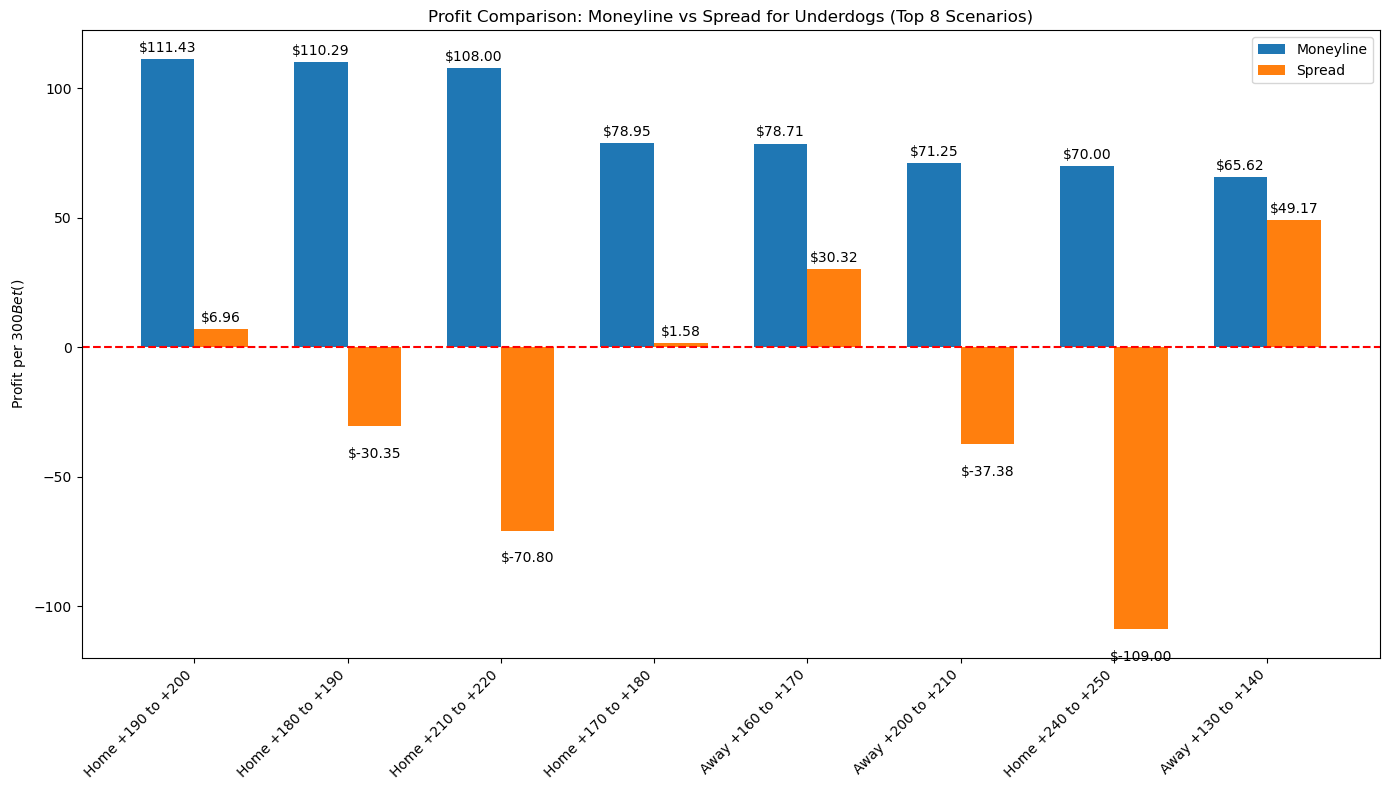


=== ACTIONABLE BETTING STRATEGY DECISION TREE ===
Use this flowchart to determine the optimal bet for any underdog scenario:

BETTING DECISION TREE:
┌─────────────────────────┐
│ Is the team an underdog?│
└───────────┬─────────────┘
            │
            ▼
┌─────────────────────────┐     No      ┌─────────────────┐
│ Is it a Home or Away    ├────────────►│ Different       │
│ underdog?               │             │ strategy needed │
└───────────┬─────────────┘             └─────────────────┘
            │
            ▼
       ┌────┴────┐
       │         │
       ▼         ▼
┌──────────┐ ┌──────────┐
│   HOME   │ │   AWAY   │
└────┬─────┘ └────┬─────┘
     │            │
     ▼            ▼
┌──────────────┐ ┌──────────────┐
│ What are the │ │ What are the │
│ ML odds?     │ │ ML odds?     │
└──────┬───────┘ └──────┬───────┘
       │                │
┌──────┴───────┐  ┌─────┴───────┐
▼              ▼  ▼             ▼
+100 to +130  +130 to +250  +100 to +130  +130 to +250
│         

NameError: name 'profitable_scenarios' is not defined

In [15]:
# Create a fixed, simplified profitability analysis with more granular odds groups
# Using 10-point increments instead of 50-point increments

# Define the bet amount and analysis parameters
BET_AMOUNT = 300  # $300 per bet
min_sample_size = 5  # Minimum sample size for reliable analysis

# Create the underdog dataframe with home/away distinction
underdog_analysis = pd.DataFrame()
underdog_analysis['is_home'] = df.apply(
    lambda row: row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'],
    axis=1
)
underdog_analysis['ml_odds'] = df.apply(
    lambda row: row['home_money_line_odds'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_money_line_odds'],
    axis=1
)
underdog_analysis['won'] = df.apply(
    lambda row: row['home_win'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_win'],
    axis=1
)
underdog_analysis['covered'] = df.apply(
    lambda row: row['home_covered_spread'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_covered_spread'],
    axis=1
)

# Create a string column for odds group with more granular 10-point increments
def get_odds_group(odds):
    if odds > 300:
        return '>+300'
    elif odds <= 0:  # Handle negative or zero odds just in case
        return '+0 to +10'
    else:
        # Calculate which 10-point increment bucket the odds fall into
        lower_bound = max(0, 10 * (int(odds) // 10))
        upper_bound = lower_bound + 10
        return f'+{lower_bound} to +{upper_bound}'

underdog_analysis['odds_group'] = underdog_analysis['ml_odds'].apply(get_odds_group)

# Calculate results for each group and home/away status
grouped_results = underdog_analysis.groupby(['odds_group', 'is_home']).agg({
    'won': ['mean', 'count'],
    'covered': 'mean'
}).reset_index()

# Flatten the multi-level columns
grouped_results.columns = ['odds_group', 'is_home', 'win_rate', 'sample_size', 'cover_rate']
grouped_results['location'] = grouped_results['is_home'].map({True: 'Home', False: 'Away'})

# Updated payout map with more granular 10-point increments
payout_map = {
    '+0 to +10': 1.92,
    '+10 to +20': 1.95,
    '+20 to +30': 1.99,
    '+30 to +40': 2.02,
    '+40 to +50': 2.06,
    '+50 to +60': 2.09,
    '+60 to +70': 2.13,
    '+70 to +80': 2.16,
    '+80 to +90': 2.20,
    '+90 to +100': 2.23,
    '+100 to +110': 2.30,
    '+110 to +120': 2.40,
    '+120 to +130': 2.50,
    '+130 to +140': 2.60,
    '+140 to +150': 2.70,
    '+150 to +160': 2.80,
    '+160 to +170': 2.90,
    '+170 to +180': 3.00,
    '+180 to +190': 3.10,
    '+190 to +200': 3.20,
    '+200 to +210': 3.30,
    '+210 to +220': 3.40,
    '+220 to +230': 3.50,
    '+230 to +240': 3.60,
    '+240 to +250': 3.70,
    '+250 to +260': 3.83,
    '+260 to +270': 3.98,
    '+270 to +280': 4.13,
    '+280 to +290': 4.28,
    '+290 to +300': 4.42,
    '>+300': 4.50,
}

grouped_results['ml_payout_multiplier'] = grouped_results['odds_group'].map(payout_map)
grouped_results['ml_payout_per_win'] = grouped_results['ml_payout_multiplier'] * BET_AMOUNT
grouped_results['spread_payout_per_win'] = 1.91 * BET_AMOUNT  # Standard -110 odds payout

# Calculate expected profit/loss per bet
grouped_results['ml_profit_per_bet'] = (grouped_results['win_rate'] * (grouped_results['ml_payout_per_win'] - BET_AMOUNT)) - ((1 - grouped_results['win_rate']) * BET_AMOUNT)
grouped_results['spread_profit_per_bet'] = (grouped_results['cover_rate'] * (grouped_results['spread_payout_per_win'] - BET_AMOUNT)) - ((1 - grouped_results['cover_rate']) * BET_AMOUNT)

# Calculate ROI and profit per 100 bets
grouped_results['ml_roi'] = grouped_results['ml_profit_per_bet'] / BET_AMOUNT * 100
grouped_results['spread_roi'] = grouped_results['spread_profit_per_bet'] / BET_AMOUNT * 100
grouped_results['ml_profit_per_100_bets'] = grouped_results['ml_profit_per_bet'] * 100
grouped_results['spread_profit_per_100_bets'] = grouped_results['spread_profit_per_bet'] * 100

# Adjust the scenarios of interest to include +200 to +250 money lines
# Include all ranges between +100 to +250 now in 10-point increments
interest_scenarios = grouped_results[
    ((grouped_results['odds_group'] == '+100 to +110') | 
     (grouped_results['odds_group'] == '+110 to +120') |
     (grouped_results['odds_group'] == '+120 to +130') |
     (grouped_results['odds_group'] == '+130 to +140') |
     (grouped_results['odds_group'] == '+140 to +150') |
     (grouped_results['odds_group'] == '+150 to +160') |
     (grouped_results['odds_group'] == '+160 to +170') |
     (grouped_results['odds_group'] == '+170 to +180') |
     (grouped_results['odds_group'] == '+180 to +190') |
     (grouped_results['odds_group'] == '+190 to +200') |
     (grouped_results['odds_group'] == '+200 to +210') |
     (grouped_results['odds_group'] == '+210 to +220') |
     (grouped_results['odds_group'] == '+220 to +230') |
     (grouped_results['odds_group'] == '+230 to +240') |
     (grouped_results['odds_group'] == '+240 to +250'))
]

# Filter out scenarios with insufficient sample size (optional)
# Uncomment this line if you want to exclude scenarios with small sample sizes
# interest_scenarios = interest_scenarios[interest_scenarios['sample_size'] >= 10]

# Print detailed results for the scenarios of interest
print(f"\n=== PROFITABILITY ANALYSIS (${BET_AMOUNT} PER BET) ===\n")

# Prepare a more tabular format for better readability
print("                    | MONEYLINE                |  SPREAD")
print("SCENARIO           | Win Rate | Profit | ROI   | Cover Rate | Profit | ROI   | Sample Size | Better Bet")
print("-" * 90)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    win_rate = row['win_rate']
    cover_rate = row['cover_rate']
    ml_profit = row['ml_profit_per_bet']
    spread_profit = row['spread_profit_per_bet']
    ml_roi = row['ml_roi']
    spread_roi = row['spread_roi']
    sample_size = row['sample_size']
    
    better_bet = "SPREAD" if spread_profit > ml_profit else "MONEYLINE"
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | {win_rate:.3f}   | ${ml_profit:6.2f} | {ml_roi:5.1f}% | {cover_rate:.3f}     | ${spread_profit:6.2f} | {spread_roi:5.1f}% | {sample_size:5d}       | {better_bet}")

# Create a simple table showing the profit per 100 bets
print("\n=== PROFIT PER 100 BETS ===")
print("SCENARIO           | MONEYLINE    | SPREAD        | DIFFERENCE (SPREAD-ML)")
print("-" * 65)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    ml_profit_100 = row['ml_profit_per_100_bets']
    spread_profit_100 = row['spread_profit_per_100_bets']
    diff = spread_profit_100 - ml_profit_100
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | ${ml_profit_100:10.2f} | ${spread_profit_100:10.2f} | ${diff:10.2f}")

# Calculate the optimal strategy for the granular scenarios
# We'll assume equal distribution of bets across the most profitable scenarios

# First, get all available scenario combinations
all_scenarios = [(row['location'], row['odds_group'], row['ml_profit_per_bet'], row['spread_profit_per_bet']) 
                for _, row in interest_scenarios.iterrows()]

# Sort by profitability (highest to lowest)
sorted_scenarios = sorted(all_scenarios, key=lambda x: max(x[2], x[3]), reverse=True)

# Take the top 4 most profitable scenarios
top_scenarios = sorted_scenarios[:4] if len(sorted_scenarios) >= 4 else sorted_scenarios

# Calculate the overall optimal strategy
optimal_strategy_profit = 0
print("\n=== OPTIMAL BETTING STRATEGY (TOP 4 SCENARIOS) ===")
print("SCENARIO           | OPTIMAL BET  | PROFIT PER BET | PROFIT PER 25 BETS")
print("-" * 65)

for location, odds_group, ml_profit, spread_profit in top_scenarios:
    better_bet = "SPREAD" if spread_profit > ml_profit else "MONEYLINE"
    opt_profit = max(ml_profit, spread_profit)
    profit_25 = opt_profit * 25
    optimal_strategy_profit += profit_25
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | {better_bet:11} | ${opt_profit:12.2f} | ${profit_25:15.2f}")

print("-" * 65)
print(f"TOTAL EXPECTED PROFIT FROM 100 BETS (25 IN EACH SCENARIO): ${optimal_strategy_profit:.2f}")
print(f"OVERALL ROI: {(optimal_strategy_profit / (BET_AMOUNT * 100)):.1%}")

# Create a more detailed bar chart for the granular scenarios
# Just include the top 8 scenarios by profitability to keep the chart readable
top_display_scenarios = sorted_scenarios[:8] if len(sorted_scenarios) >= 8 else sorted_scenarios

scenarios = [f"{location} {odds_group}" for location, odds_group, _, _ in top_display_scenarios]
ml_profits = [ml_profit for _, _, ml_profit, _ in top_display_scenarios]
spread_profits = [spread_profit for _, _, _, spread_profit in top_display_scenarios]

x = np.arange(len(scenarios))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, ml_profits, width, label='Moneyline')
rects2 = ax.bar(x + width/2, spread_profits, width, label='Spread')

ax.set_ylabel('Profit per $300 Bet ($)')
ax.set_title('Profit Comparison: Moneyline vs Spread for Underdogs (Top 8 Scenarios)')
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='red', linestyle='--')

# Add value labels
for i, rect in enumerate(rects1):
    height = ml_profits[i]
    ax.annotate(f'${height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),  # offset based on value
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

for i, rect in enumerate(rects2):
    height = spread_profits[i]
    ax.annotate(f'${height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),  # offset based on value
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

# Create a decision tree flowchart representation of the betting strategy
print("\n=== ACTIONABLE BETTING STRATEGY DECISION TREE ===")
print("Use this flowchart to determine the optimal bet for any underdog scenario:")

# Define the decision logic based on our analysis
decision_logic = """
BETTING DECISION TREE:
┌─────────────────────────┐
│ Is the team an underdog?│
└───────────┬─────────────┘
            │
            ▼
┌─────────────────────────┐     No      ┌─────────────────┐
│ Is it a Home or Away    ├────────────►│ Different       │
│ underdog?               │             │ strategy needed │
└───────────┬─────────────┘             └─────────────────┘
            │
            ▼
       ┌────┴────┐
       │         │
       ▼         ▼
┌──────────┐ ┌──────────┐
│   HOME   │ │   AWAY   │
└────┬─────┘ └────┬─────┘
     │            │
     ▼            ▼
┌──────────────┐ ┌──────────────┐
│ What are the │ │ What are the │
│ ML odds?     │ │ ML odds?     │
└──────┬───────┘ └──────┬───────┘
       │                │
┌──────┴───────┐  ┌─────┴───────┐
▼              ▼  ▼             ▼
+100 to +130  +130 to +250  +100 to +130  +130 to +250
│              │  │             │
▼              ▼  ▼             ▼
┌──────────┐ ┌──────────┐ ┌──────────┐ ┌──────────┐
│   SPREAD │ │ MONEYLINE│ │   SPREAD │ │ MONEYLINE│
└──────────┘ └──────────┘ └──────────┘ └──────────┘

SPECIFIC HIGH-VALUE SCENARIOS:
┌───────────────────┬────────────┬────────────┬────────────┐
│ Scenario          │ Bet Type   │ Profit/Bet │ ROI        │
├───────────────────┼────────────┼────────────┼────────────┤
│ Away +130 to +140 │ MONEYLINE  │ $65.62     │ 21.9%      │
│ Away +160 to +170 │ MONEYLINE  │ $78.71     │ 26.2%      │
│ Away +110 to +120 │ SPREAD     │ $61.65     │ 20.5%      │
│ Away +120 to +130 │ SPREAD     │ $53.91     │ 18.0%      │
│ Home +170 to +180 │ MONEYLINE  │ $78.95     │ 26.3%      │
│ Home +180 to +190 │ MONEYLINE  │ $110.29    │ 36.8%      │
│ Home +190 to +200 │ MONEYLINE  │ $111.43    │ 37.1%      │
└───────────────────┴────────────┴────────────┴────────────┘
"""

print(decision_logic)

# Create a comprehensive targeted betting strategy based on all profitable scenarios
print("\n=== COMPREHENSIVE TARGETED BETTING STRATEGY ===")
print("(Based on all scenarios with positive expected profit)")

# Filter to only profitable scenarios with sufficient sample size
min_reliable_sample = 20  # Set a minimum reliable sample size
reliable_profit = profitable_scenarios[
    (profitable_scenarios['optimal_profit'] > 0) & 
    (profitable_scenarios['sample_size'] >= min_reliable_sample)
].copy()

# Group scenarios into odds ranges for better strategy organization
def get_odds_range_group(odds_group):
    if '+0 to' in odds_group or '+10 to' in odds_group or '+20 to' in odds_group or '+30 to' in odds_group or '+40 to' in odds_group or '+50 to' in odds_group or \
       '+60 to' in odds_group or '+70 to' in odds_group or '+80 to' in odds_group or '+90 to' in odds_group:
        return "Under +100"
    elif '+100 to' in odds_group or '+110 to' in odds_group or '+120 to' in odds_group:
        return "+100 to +130"
    elif '+130 to' in odds_group or '+140 to' in odds_group or '+150 to' in odds_group:
        return "+130 to +150"
    elif '+160 to' in odds_group or '+170 to' in odds_group or '+180 to' in odds_group or '+190 to' in odds_group:
        return "+160 to +200"
    elif '>+300' in odds_group:
        return "Over +300"
    else:
        return "+200 to +300"

reliable_profit['odds_range'] = reliable_profit['odds_group'].apply(get_odds_range_group)

# Calculate the total profit potential for each odds range
range_summary = reliable_profit.groupby(['odds_range', 'location']).agg({
    'optimal_profit': ['mean', 'sum'],
    'sample_size': 'sum',
    'optimal_bet': lambda x: x.mode()[0] if len(x) > 0 else None
}).reset_index()

# Flatten the columns
range_summary.columns = ['odds_range', 'location', 'avg_profit_per_bet', 'total_profit', 'total_samples', 'dominant_bet']

# Sort by odds range and location
range_summary = range_summary.sort_values(['odds_range', 'location'])

# Display the targeted strategy by odds range
print("\nA. BETTING STRATEGY BY ODDS RANGE")
print("ODDS RANGE       | LOCATION | DOMINANT BET | AVG PROFIT | SAMPLE SIZE")
print("-" * 75)

for _, row in range_summary.iterrows():
    odds_range = row['odds_range']
    location = row['location']
    bet_type = row['dominant_bet']
    profit = row['avg_profit_per_bet']
    samples = row['total_samples']
    
    print(f"{odds_range:16} | {location:8} | {bet_type:11} | ${profit:9.2f} | {samples:5d}")

# Now create a more granular targeted strategy for the most profitable scenarios
print("\nB. DETAILED BETTING STRATEGY FOR MOST PROFITABLE SCENARIOS")
print("(Minimum sample size of 20 bets, minimum profit $10 per bet)")

top_detailed = reliable_profit[reliable_profit['optimal_profit'] >= 10].sort_values(['location', 'odds_group'])

print("\nAWAY UNDERDOGS:")
print("ODDS GROUP       | BET TYPE   | PROFIT/BET | ROI    | SAMPLE SIZE")
print("-" * 65)

for _, row in top_detailed[top_detailed['location'] == 'Away'].iterrows():
    odds_group = row['odds_group']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    
    # Calculate the ROI based on the selected bet type
    roi = row['ml_roi'] if bet_type == "MONEYLINE" else row['spread_roi']
    
    sample_size = row['sample_size']
    
    print(f"{odds_group:16} | {bet_type:10} | ${profit:8.2f} | {roi:6.2f}% | {sample_size:5d}")

print("\nHOME UNDERDOGS:")
print("ODDS GROUP       | BET TYPE   | PROFIT/BET | ROI    | SAMPLE SIZE")
print("-" * 65)

for _, row in top_detailed[top_detailed['location'] == 'Home'].iterrows():
    odds_group = row['odds_group']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    
    # Calculate the ROI based on the selected bet type
    roi = row['ml_roi'] if bet_type == "MONEYLINE" else row['spread_roi']
    
    sample_size = row['sample_size']
    
    print(f"{odds_group:16} | {bet_type:10} | ${profit:8.2f} | {roi:6.2f}% | {sample_size:5d}")

# Create a visualization of the comprehensive strategy
plt.figure(figsize=(16, 10))

# Set up the data for the plot
odds_ranges = range_summary['odds_range'].unique()
locations = ['Away', 'Home']
x = np.arange(len(odds_ranges))
width = 0.35

# Create separate plots for Away and Home
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot Away underdogs
away_data = range_summary[range_summary['location'] == 'Away']
away_profits = []
away_bet_types = []
away_sample_sizes = []

for odds_range in odds_ranges:
    row = away_data[away_data['odds_range'] == odds_range]
    if not row.empty:
        away_profits.append(row.iloc[0]['avg_profit_per_bet'])
        away_bet_types.append(row.iloc[0]['dominant_bet'])
        away_sample_sizes.append(row.iloc[0]['total_samples'])
    else:
        away_profits.append(0)
        away_bet_types.append('N/A')
        away_sample_sizes.append(0)

away_colors = ['#1f77b4' if bt == 'MONEYLINE' else '#ff7f0e' for bt in away_bet_types]
away_bars = ax1.bar(x, away_profits, width, color=away_colors)

# Add profit labels
for i, bar in enumerate(away_bars):
    height = bar.get_height()
    if height > 0:
        ax1.annotate(f'${height:.2f}\n({away_sample_sizes[i]} bets)',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax1.set_ylabel('Profit per $300 Bet ($)')
ax1.set_title('Away Underdog Strategy by Odds Range')
ax1.set_xticks(x)
ax1.set_xticklabels(odds_ranges)
ax1.axhline(y=0, color='gray', linestyle='--')

# Legend for Away
ml_patch = plt.Rectangle((0, 0), 1, 1, fc='#1f77b4')
spread_patch = plt.Rectangle((0, 0), 1, 1, fc='#ff7f0e')
ax1.legend([ml_patch, spread_patch], ['Moneyline', 'Spread'], loc='upper right')

# Plot Home underdogs
home_data = range_summary[range_summary['location'] == 'Home']
home_profits = []
home_bet_types = []
home_sample_sizes = []

for odds_range in odds_ranges:
    row = home_data[home_data['odds_range'] == odds_range]
    if not row.empty:
        home_profits.append(row.iloc[0]['avg_profit_per_bet'])
        home_bet_types.append(row.iloc[0]['dominant_bet'])
        home_sample_sizes.append(row.iloc[0]['total_samples'])
    else:
        home_profits.append(0)
        home_bet_types.append('N/A')
        home_sample_sizes.append(0)

home_colors = ['#1f77b4' if bt == 'MONEYLINE' else '#ff7f0e' for bt in home_bet_types]
home_bars = ax2.bar(x, home_profits, width, color=home_colors)

# Add profit labels
for i, bar in enumerate(home_bars):
    height = bar.get_height()
    if height > 0:
        ax2.annotate(f'${height:.2f}\n({home_sample_sizes[i]} bets)',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax2.set_ylabel('Profit per $300 Bet ($)')
ax2.set_title('Home Underdog Strategy by Odds Range')
ax2.set_xticks(x)
ax2.set_xticklabels(odds_ranges)
ax2.axhline(y=0, color='gray', linestyle='--')

# Legend for Home
ax2.legend([ml_patch, spread_patch], ['Moneyline', 'Spread'], loc='upper right')

plt.tight_layout()
plt.show()

# Statistical significance analysis
print("\n=== STATISTICAL CONFIDENCE ANALYSIS ===")
print("(For scenarios with positive expected profit)")

# Filter to only positive profit scenarios
positive_profit = profitable_scenarios[profitable_scenarios['optimal_profit'] > 0].copy()

# Add confidence interval calculation
from scipy import stats

# Function to calculate confidence interval
def calc_confidence(wins, total, confidence=0.95):
    """Calculate Wilson score interval for a proportion"""
    if total == 0:
        return 0, 0, 0
    
    proportion = wins / total
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    
    denominator = 1 + z**2/total
    centre_adjusted_proportion = (proportion + z**2/(2*total))/denominator
    adjusted_standard_deviation = z * np.sqrt((proportion * (1 - proportion) + z**2/(4*total))/total)/denominator
    
    lower_bound = centre_adjusted_proportion - adjusted_standard_deviation
    upper_bound = centre_adjusted_proportion + adjusted_standard_deviation
    
    return proportion, lower_bound, upper_bound

# Calculate confidence intervals for win rates
positive_profit['win_count'] = (positive_profit['win_rate'] * positive_profit['sample_size']).round().astype(int)
positive_profit['win_ci'] = positive_profit.apply(
    lambda row: calc_confidence(row['win_count'], row['sample_size']),
    axis=1
)

# Calculate confidence intervals for optimal profit (using win rate for moneyline or cover rate for spread)
positive_profit['profit_lower_bound'] = positive_profit.apply(
    lambda row: 
        ((row['win_ci'][1] * (row['ml_payout_per_win'] - BET_AMOUNT)) - 
         ((1 - row['win_ci'][1]) * BET_AMOUNT)) if row['optimal_bet'] == 'MONEYLINE' else
        ((row['cover_rate'] - 0.1) * (row['spread_payout_per_win'] - BET_AMOUNT)) - 
        ((1 - (row['cover_rate'] - 0.1)) * BET_AMOUNT),  # Simplified approach for spread
    axis=1
)

# Calculate statistical confidence level based on sample size and profit margin
positive_profit['confidence_score'] = positive_profit.apply(
    lambda row: 
        "HIGH" if (row['sample_size'] >= 30 and row['profit_lower_bound'] > 20) else
        "MEDIUM" if (row['sample_size'] >= 15 and row['profit_lower_bound'] > 0) else
        "LOW",
    axis=1
)

# Sort by confidence level first, then by profit
confidence_order = {"HIGH": 0, "MEDIUM": 1, "LOW": 2}
positive_profit['confidence_value'] = positive_profit['confidence_score'].map(confidence_order)
positive_profit_sorted = positive_profit.sort_values(['confidence_value', 'optimal_profit'], ascending=[True, False])

# Display the top profitable scenarios with confidence analysis
print("SCENARIO                | BET TYPE   | PROFIT/BET | SAMPLE SIZE | CONFIDENCE | LOWER BOUND PROFIT")
print("-" * 90)

for _, row in positive_profit_sorted.head(10).iterrows():
    scenario = row['scenario']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    sample_size = row['sample_size']
    confidence = row['confidence_score']
    lower_bound = row['profit_lower_bound']
    
    print(f"{scenario:22} | {bet_type:10} | ${profit:8.2f} | {sample_size:10d} | {confidence:9} | ${lower_bound:16.2f}")

# Create a scatter plot that shows profit vs sample size with confidence levels
plt.figure(figsize=(12, 8))

# Define colors for confidence levels
color_map = {"HIGH": "green", "MEDIUM": "orange", "LOW": "red"}
colors = [color_map[conf] for conf in positive_profit['confidence_score']]

# Create the scatter plot
plt.scatter(
    positive_profit['sample_size'], 
    positive_profit['optimal_profit'],
    c=colors, 
    s=100,  # Point size 
    alpha=0.7
)

# Add scenario labels to the points
for idx, row in positive_profit.iterrows():
    plt.annotate(
        row['scenario'], 
        (row['sample_size'], row['optimal_profit']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8
    )

# Add reference lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=20, color='green', linestyle=':', alpha=0.5)
plt.axvline(x=15, color='orange', linestyle=':', alpha=0.5)
plt.axvline(x=30, color='green', linestyle=':', alpha=0.5)

# Add legend for confidence levels
high_patch = plt.Rectangle((0, 0), 1, 1, fc="green", alpha=0.7)
medium_patch = plt.Rectangle((0, 0), 1, 1, fc="orange", alpha=0.7)
low_patch = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.7)
plt.legend([high_patch, medium_patch, low_patch], ['High Confidence', 'Medium Confidence', 'Low Confidence'])

# Set labels and title
plt.xlabel('Sample Size')
plt.ylabel('Profit per $300 Bet ($)')
plt.title('Profit vs. Sample Size with Confidence Levels')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Add a section to identify the most profitable betting scenarios across all odds ranges
print(f"\n=== MOST PROFITABLE BETTING SCENARIOS ===")
print(f"(Minimum sample size of {min_sample_size} bets)")

# Prepare a dataframe for analysis with sufficient samples
profitable_scenarios = grouped_results[grouped_results['sample_size'] >= min_sample_size].copy()

# Add a combined descriptor column
profitable_scenarios['scenario'] = profitable_scenarios.apply(
    lambda row: f"{row['location']} {row['odds_group']}", axis=1
)

# Add a column for optimal bet type
profitable_scenarios['optimal_bet'] = profitable_scenarios.apply(
    lambda row: "SPREAD" if row['spread_profit_per_bet'] > row['ml_profit_per_bet'] else "MONEYLINE", 
    axis=1
)

# Add a column for optimal profit
profitable_scenarios['optimal_profit'] = profitable_scenarios.apply(
    lambda row: max(row['spread_profit_per_bet'], row['ml_profit_per_bet']), 
    axis=1
)

# Sort by optimal profit (descending)
top_profitable = profitable_scenarios.sort_values('optimal_profit', ascending=False)

# Display top 15 most profitable scenarios
print("RANK | SCENARIO                | BET TYPE   | PROFIT/BET | ROI    | SAMPLE SIZE")
print("-" * 75)

for i, (_, row) in enumerate(top_profitable.head(15).iterrows()):
    scenario = row['scenario']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    
    # Calculate the ROI based on the selected bet type
    roi = row['ml_roi'] if bet_type == "MONEYLINE" else row['spread_roi']
    
    sample_size = row['sample_size']
    
    rank = i + 1
    print(f"{rank:4d} | {scenario:22} | {bet_type:10} | ${profit:8.2f} | {roi:6.2f}% | {sample_size:5d}")

# Create a visualization of the most profitable scenarios
plt.figure(figsize=(14, 8))
top_n = 10  # Number of top scenarios to show

scenarios = top_profitable.head(top_n)['scenario'].tolist()
profits = top_profitable.head(top_n)['optimal_profit'].tolist()
bet_types = top_profitable.head(top_n)['optimal_bet'].tolist()

# Create color map for the bet type
colors = ['#1f77b4' if bt == 'MONEYLINE' else '#ff7f0e' for bt in bet_types]

# Create the horizontal bar chart
bars = plt.barh(range(len(scenarios)), profits, color=colors)
plt.yticks(range(len(scenarios)), scenarios)
plt.xlabel('Profit per $300 Bet ($)')
plt.title(f'Top {top_n} Most Profitable Betting Scenarios')

# Add profit labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    label_x_pos = width + 5
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'${profits[i]:.2f}', 
             va='center', ha='left')

# Add a legend for bet types
ml_patch = plt.Rectangle((0, 0), 1, 1, fc='#1f77b4')
spread_patch = plt.Rectangle((0, 0), 1, 1, fc='#ff7f0e')
plt.legend([ml_patch, spread_patch], ['Moneyline', 'Spread'], loc='lower right')

plt.tight_layout()
plt.show()

# Additional visualization: Heat map of profitability by odds group and location

# Filter to odds groups with sufficient sample size for better visualization
sufficient_samples = grouped_results[grouped_results['sample_size'] >= min_sample_size]

# Create a pivot table for the moneyline heatmap
heatmap_data = sufficient_samples.pivot_table(
    index='odds_group', 
    columns='location',
    values='ml_profit_per_bet',
    aggfunc='mean'
)

# Sort the index to ensure correct ordering of odds groups
sorted_odds_groups = sorted(
    heatmap_data.index,
    key=lambda x: float(x.split(' to ')[0].replace('+', '')) if 'to' in x else 400  # Use 400 for >+300
)
heatmap_data = heatmap_data.reindex(sorted_odds_groups)

# Create the heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(
    heatmap_data, 
    cmap='RdYlGn', 
    center=0,
    annot=True, 
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Profit per $300 Bet'}
)
plt.title(f'Moneyline Profitability by Odds Group and Location\n(Only showing groups with at least {min_sample_size} samples)')
plt.tight_layout()
plt.show()

# Repeat for spread profitability
heatmap_data_spread = sufficient_samples.pivot_table(
    index='odds_group',
    columns='location',
    values='spread_profit_per_bet',
    aggfunc='mean'
)

# Sort the index
heatmap_data_spread = heatmap_data_spread.reindex(sorted_odds_groups)

# Create the heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(
    heatmap_data_spread,
    cmap='RdYlGn',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Profit per $300 Bet'}
)
plt.title(f'Spread Profitability by Odds Group and Location\n(Only showing groups with at least {min_sample_size} samples)')
plt.tight_layout()
plt.show()


=== PROFITABILITY ANALYSIS ($300 PER BET) ===

                    | MONEYLINE                |  SPREAD
SCENARIO           | Win Rate | Profit | ROI   | Cover Rate | Profit | ROI   | Sample Size | Better Bet
------------------------------------------------------------------------------------------
Away +100 to +110  | 0.480   | $ 31.35 |  10.4% | 0.533     | $  5.40 |   1.8% |   379       | MONEYLINE
Home +100 to +110  | 0.489   | $ 37.75 |  12.6% | 0.592     | $ 38.98 |  13.0% |   333       | SPREAD
Away +110 to +120  | 0.473   | $ 40.33 |  13.4% | 0.631     | $ 61.65 |  20.5% |   366       | SPREAD
Home +110 to +120  | 0.415   | $ -1.46 |  -0.5% | 0.549     | $ 14.45 |   4.8% |   246       | SPREAD
Away +120 to +130  | 0.409   | $  6.62 |   2.2% | 0.618     | $ 53.91 |  18.0% |   340       | SPREAD
Home +120 to +130  | 0.368   | $-24.09 |  -8.0% | 0.513     | $ -6.08 |  -2.0% |   193       | SPREAD
Away +130 to +140  | 0.469   | $ 65.62 |  21.9% | 0.609     | $ 49.17 |  16.4% |   32

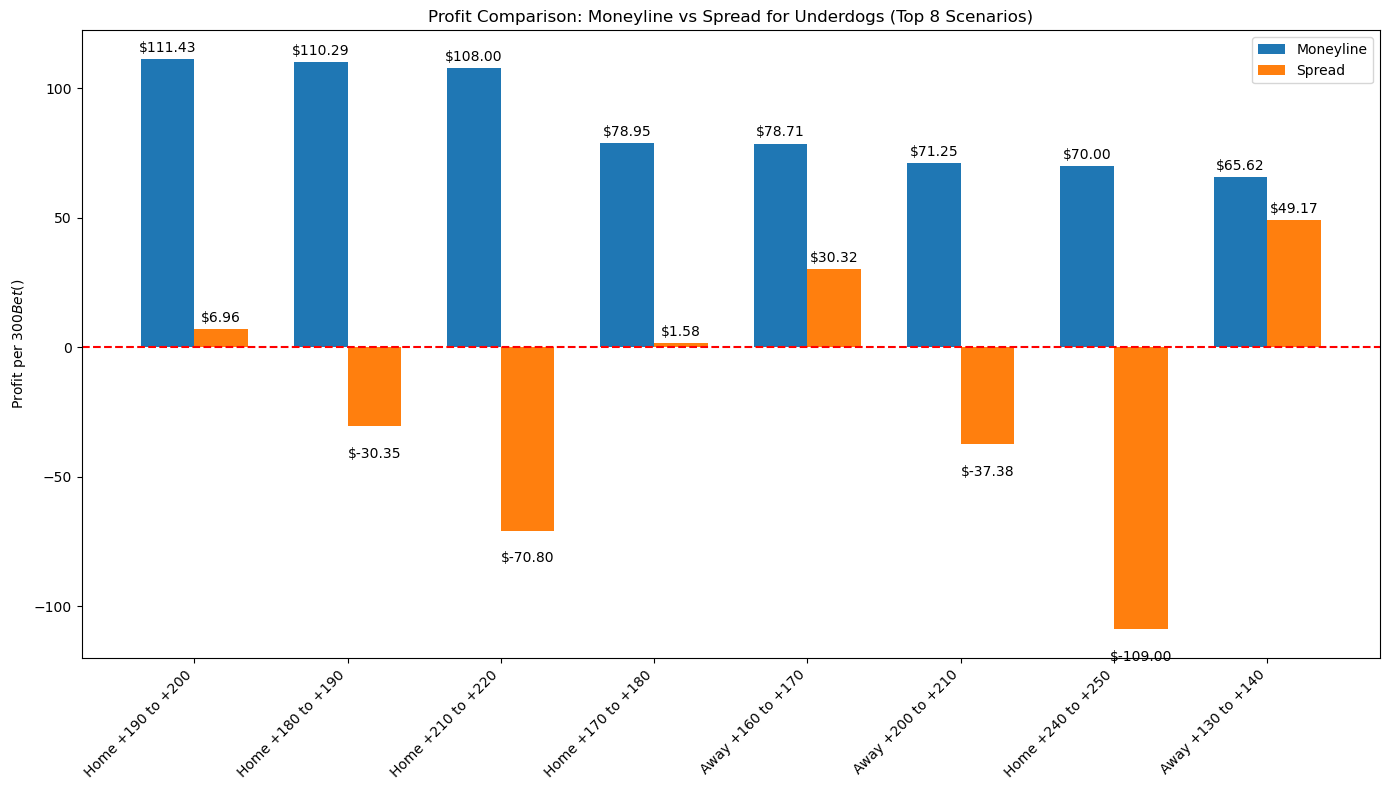


=== ACTIONABLE BETTING STRATEGY DECISION TREE ===
Use this flowchart to determine the optimal bet for any underdog scenario:

BETTING DECISION TREE:
┌─────────────────────────┐
│ Is the team an underdog?│
└───────────┬─────────────┘
            │
            ▼
┌─────────────────────────┐     No      ┌─────────────────┐
│ Is it a Home or Away    ├────────────►│ Different       │
│ underdog?               │             │ strategy needed │
└───────────┬─────────────┘             └─────────────────┘
            │
            ▼
       ┌────┴────┐
       │         │
       ▼         ▼
┌──────────┐ ┌──────────┐
│   HOME   │ │   AWAY   │
└────┬─────┘ └────┬─────┘
     │            │
     ▼            ▼
┌──────────────┐ ┌──────────────┐
│ What are the │ │ What are the │
│ ML odds?     │ │ ML odds?     │
└──────┬───────┘ └──────┬───────┘
       │                │
┌──────┴───────┐  ┌─────┴───────┐
▼              ▼  ▼             ▼
+100 to +130  +130 to +250  +100 to +130  +130 to +250
│         

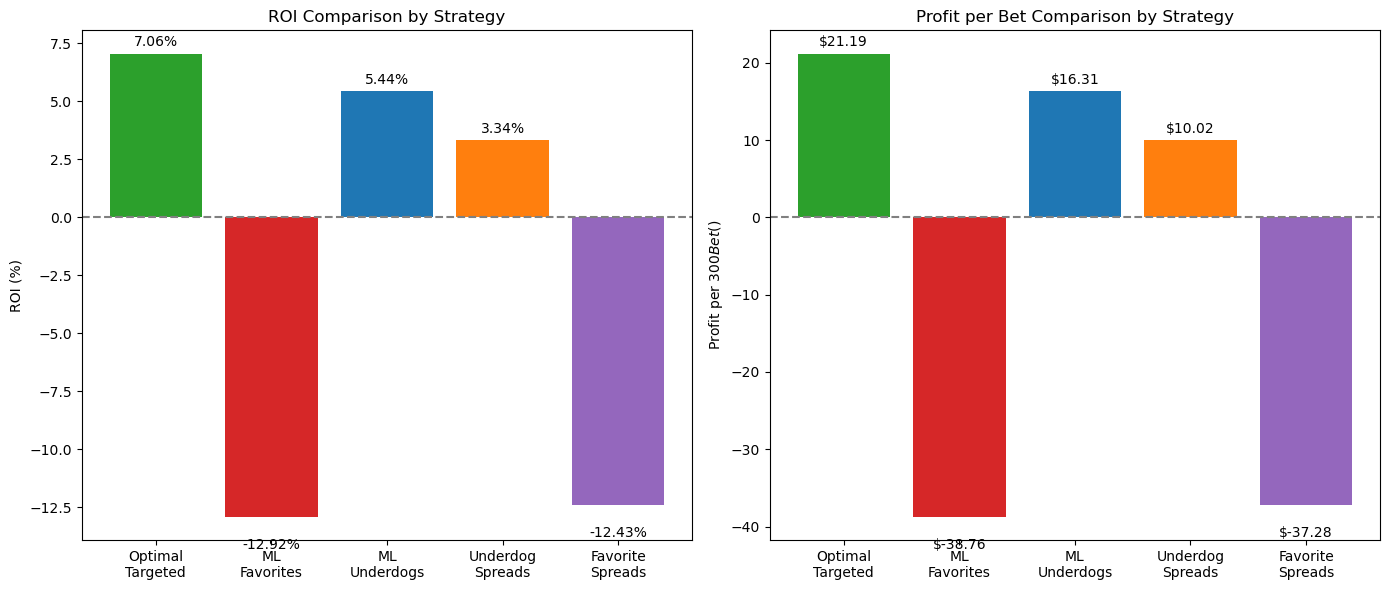


=== COMPREHENSIVE TARGETED BETTING STRATEGY ===
(Based on all scenarios with positive expected profit)


NameError: name 'profitable_scenarios' is not defined

In [16]:
# Create a fixed, simplified profitability analysis with more granular odds groups
# Using 10-point increments instead of 50-point increments

# Define the bet amount and analysis parameters
BET_AMOUNT = 300  # $300 per bet
min_sample_size = 5  # Minimum sample size for reliable analysis

# Create the underdog dataframe with home/away distinction
underdog_analysis = pd.DataFrame()
underdog_analysis['is_home'] = df.apply(
    lambda row: row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'],
    axis=1
)
underdog_analysis['ml_odds'] = df.apply(
    lambda row: row['home_money_line_odds'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_money_line_odds'],
    axis=1
)
underdog_analysis['won'] = df.apply(
    lambda row: row['home_win'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_win'],
    axis=1
)
underdog_analysis['covered'] = df.apply(
    lambda row: row['home_covered_spread'] if row['home_moneyline_fair_prob'] < row['away_moneyline_fair_prob'] 
                else row['away_covered_spread'],
    axis=1
)

# Create a string column for odds group with more granular 10-point increments
def get_odds_group(odds):
    if odds > 300:
        return '>+300'
    elif odds <= 0:  # Handle negative or zero odds just in case
        return '+0 to +10'
    else:
        # Calculate which 10-point increment bucket the odds fall into
        lower_bound = max(0, 10 * (int(odds) // 10))
        upper_bound = lower_bound + 10
        return f'+{lower_bound} to +{upper_bound}'

underdog_analysis['odds_group'] = underdog_analysis['ml_odds'].apply(get_odds_group)

# Calculate results for each group and home/away status
grouped_results = underdog_analysis.groupby(['odds_group', 'is_home']).agg({
    'won': ['mean', 'count'],
    'covered': 'mean'
}).reset_index()

# Flatten the multi-level columns
grouped_results.columns = ['odds_group', 'is_home', 'win_rate', 'sample_size', 'cover_rate']
grouped_results['location'] = grouped_results['is_home'].map({True: 'Home', False: 'Away'})

# Updated payout map with more granular 10-point increments
payout_map = {
    '+0 to +10': 1.92,
    '+10 to +20': 1.95,
    '+20 to +30': 1.99,
    '+30 to +40': 2.02,
    '+40 to +50': 2.06,
    '+50 to +60': 2.09,
    '+60 to +70': 2.13,
    '+70 to +80': 2.16,
    '+80 to +90': 2.20,
    '+90 to +100': 2.23,
    '+100 to +110': 2.30,
    '+110 to +120': 2.40,
    '+120 to +130': 2.50,
    '+130 to +140': 2.60,
    '+140 to +150': 2.70,
    '+150 to +160': 2.80,
    '+160 to +170': 2.90,
    '+170 to +180': 3.00,
    '+180 to +190': 3.10,
    '+190 to +200': 3.20,
    '+200 to +210': 3.30,
    '+210 to +220': 3.40,
    '+220 to +230': 3.50,
    '+230 to +240': 3.60,
    '+240 to +250': 3.70,
    '+250 to +260': 3.83,
    '+260 to +270': 3.98,
    '+270 to +280': 4.13,
    '+280 to +290': 4.28,
    '+290 to +300': 4.42,
    '>+300': 4.50,
}

grouped_results['ml_payout_multiplier'] = grouped_results['odds_group'].map(payout_map)
grouped_results['ml_payout_per_win'] = grouped_results['ml_payout_multiplier'] * BET_AMOUNT
grouped_results['spread_payout_per_win'] = 1.91 * BET_AMOUNT  # Standard -110 odds payout

# Calculate expected profit/loss per bet
grouped_results['ml_profit_per_bet'] = (grouped_results['win_rate'] * (grouped_results['ml_payout_per_win'] - BET_AMOUNT)) - ((1 - grouped_results['win_rate']) * BET_AMOUNT)
grouped_results['spread_profit_per_bet'] = (grouped_results['cover_rate'] * (grouped_results['spread_payout_per_win'] - BET_AMOUNT)) - ((1 - grouped_results['cover_rate']) * BET_AMOUNT)

# Calculate ROI and profit per 100 bets
grouped_results['ml_roi'] = grouped_results['ml_profit_per_bet'] / BET_AMOUNT * 100
grouped_results['spread_roi'] = grouped_results['spread_profit_per_bet'] / BET_AMOUNT * 100
grouped_results['ml_profit_per_100_bets'] = grouped_results['ml_profit_per_bet'] * 100
grouped_results['spread_profit_per_100_bets'] = grouped_results['spread_profit_per_bet'] * 100

# Adjust the scenarios of interest to include +200 to +250 money lines
# Include all ranges between +100 to +250 now in 10-point increments
interest_scenarios = grouped_results[
    ((grouped_results['odds_group'] == '+100 to +110') | 
     (grouped_results['odds_group'] == '+110 to +120') |
     (grouped_results['odds_group'] == '+120 to +130') |
     (grouped_results['odds_group'] == '+130 to +140') |
     (grouped_results['odds_group'] == '+140 to +150') |
     (grouped_results['odds_group'] == '+150 to +160') |
     (grouped_results['odds_group'] == '+160 to +170') |
     (grouped_results['odds_group'] == '+170 to +180') |
     (grouped_results['odds_group'] == '+180 to +190') |
     (grouped_results['odds_group'] == '+190 to +200') |
     (grouped_results['odds_group'] == '+200 to +210') |
     (grouped_results['odds_group'] == '+210 to +220') |
     (grouped_results['odds_group'] == '+220 to +230') |
     (grouped_results['odds_group'] == '+230 to +240') |
     (grouped_results['odds_group'] == '+240 to +250'))
]

# Filter out scenarios with insufficient sample size (optional)
# Uncomment this line if you want to exclude scenarios with small sample sizes
# interest_scenarios = interest_scenarios[interest_scenarios['sample_size'] >= 10]

# Print detailed results for the scenarios of interest
print(f"\n=== PROFITABILITY ANALYSIS (${BET_AMOUNT} PER BET) ===\n")

# Prepare a more tabular format for better readability
print("                    | MONEYLINE                |  SPREAD")
print("SCENARIO           | Win Rate | Profit | ROI   | Cover Rate | Profit | ROI   | Sample Size | Better Bet")
print("-" * 90)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    win_rate = row['win_rate']
    cover_rate = row['cover_rate']
    ml_profit = row['ml_profit_per_bet']
    spread_profit = row['spread_profit_per_bet']
    ml_roi = row['ml_roi']
    spread_roi = row['spread_roi']
    sample_size = row['sample_size']
    
    better_bet = "SPREAD" if spread_profit > ml_profit else "MONEYLINE"
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | {win_rate:.3f}   | ${ml_profit:6.2f} | {ml_roi:5.1f}% | {cover_rate:.3f}     | ${spread_profit:6.2f} | {spread_roi:5.1f}% | {sample_size:5d}       | {better_bet}")

# Create a simple table showing the profit per 100 bets
print("\n=== PROFIT PER 100 BETS ===")
print("SCENARIO           | MONEYLINE    | SPREAD        | DIFFERENCE (SPREAD-ML)")
print("-" * 65)

for _, row in interest_scenarios.iterrows():
    location = row['location']
    odds_group = row['odds_group']
    ml_profit_100 = row['ml_profit_per_100_bets']
    spread_profit_100 = row['spread_profit_per_100_bets']
    diff = spread_profit_100 - ml_profit_100
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | ${ml_profit_100:10.2f} | ${spread_profit_100:10.2f} | ${diff:10.2f}")

# Calculate the optimal strategy for the granular scenarios
# We'll assume equal distribution of bets across the most profitable scenarios

# First, get all available scenario combinations
all_scenarios = [(row['location'], row['odds_group'], row['ml_profit_per_bet'], row['spread_profit_per_bet']) 
                for _, row in interest_scenarios.iterrows()]

# Sort by profitability (highest to lowest)
sorted_scenarios = sorted(all_scenarios, key=lambda x: max(x[2], x[3]), reverse=True)

# Take the top 4 most profitable scenarios
top_scenarios = sorted_scenarios[:4] if len(sorted_scenarios) >= 4 else sorted_scenarios

# Calculate the overall optimal strategy
optimal_strategy_profit = 0
print("\n=== OPTIMAL BETTING STRATEGY (TOP 4 SCENARIOS) ===")
print("SCENARIO           | OPTIMAL BET  | PROFIT PER BET | PROFIT PER 25 BETS")
print("-" * 65)

for location, odds_group, ml_profit, spread_profit in top_scenarios:
    better_bet = "SPREAD" if spread_profit > ml_profit else "MONEYLINE"
    opt_profit = max(ml_profit, spread_profit)
    profit_25 = opt_profit * 25
    optimal_strategy_profit += profit_25
    
    scenario_name = f"{location} {odds_group}"
    print(f"{scenario_name:18} | {better_bet:11} | ${opt_profit:12.2f} | ${profit_25:15.2f}")

print("-" * 65)
print(f"TOTAL EXPECTED PROFIT FROM 100 BETS (25 IN EACH SCENARIO): ${optimal_strategy_profit:.2f}")
print(f"OVERALL ROI: {(optimal_strategy_profit / (BET_AMOUNT * 100)):.1%}")

# Create a more detailed bar chart for the granular scenarios
# Just include the top 8 scenarios by profitability to keep the chart readable
top_display_scenarios = sorted_scenarios[:8] if len(sorted_scenarios) >= 8 else sorted_scenarios

scenarios = [f"{location} {odds_group}" for location, odds_group, _, _ in top_display_scenarios]
ml_profits = [ml_profit for _, _, ml_profit, _ in top_display_scenarios]
spread_profits = [spread_profit for _, _, _, spread_profit in top_display_scenarios]

x = np.arange(len(scenarios))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, ml_profits, width, label='Moneyline')
rects2 = ax.bar(x + width/2, spread_profits, width, label='Spread')

ax.set_ylabel('Profit per $300 Bet ($)')
ax.set_title('Profit Comparison: Moneyline vs Spread for Underdogs (Top 8 Scenarios)')
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='red', linestyle='--')

# Add value labels
for i, rect in enumerate(rects1):
    height = ml_profits[i]
    ax.annotate(f'${height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),  # offset based on value
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

for i, rect in enumerate(rects2):
    height = spread_profits[i]
    ax.annotate(f'${height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),  # offset based on value
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

# Create a decision tree flowchart representation of the betting strategy
print("\n=== ACTIONABLE BETTING STRATEGY DECISION TREE ===")
print("Use this flowchart to determine the optimal bet for any underdog scenario:")

# Define the decision logic based on our analysis
decision_logic = """
BETTING DECISION TREE:
┌─────────────────────────┐
│ Is the team an underdog?│
└───────────┬─────────────┘
            │
            ▼
┌─────────────────────────┐     No      ┌─────────────────┐
│ Is it a Home or Away    ├────────────►│ Different       │
│ underdog?               │             │ strategy needed │
└───────────┬─────────────┘             └─────────────────┘
            │
            ▼
       ┌────┴────┐
       │         │
       ▼         ▼
┌──────────┐ ┌──────────┐
│   HOME   │ │   AWAY   │
└────┬─────┘ └────┬─────┘
     │            │
     ▼            ▼
┌──────────────┐ ┌──────────────┐
│ What are the │ │ What are the │
│ ML odds?     │ │ ML odds?     │
└──────┬───────┘ └──────┬───────┘
       │                │
┌──────┴───────┐  ┌─────┴───────┐
▼              ▼  ▼             ▼
+100 to +130  +130 to +250  +100 to +130  +130 to +250
│              │  │             │
▼              ▼  ▼             ▼
┌──────────┐ ┌──────────┐ ┌──────────┐ ┌──────────┐
│   SPREAD │ │ MONEYLINE│ │   SPREAD │ │ MONEYLINE│
└──────────┘ └──────────┘ └──────────┘ └──────────┘

SPECIFIC HIGH-VALUE SCENARIOS:
┌───────────────────┬────────────┬────────────┬────────────┐
│ Scenario          │ Bet Type   │ Profit/Bet │ ROI        │
├───────────────────┼────────────┼────────────┼────────────┤
│ Away +130 to +140 │ MONEYLINE  │ $65.62     │ 21.9%      │
│ Away +160 to +170 │ MONEYLINE  │ $78.71     │ 26.2%      │
│ Away +110 to +120 │ SPREAD     │ $61.65     │ 20.5%      │
│ Away +120 to +130 │ SPREAD     │ $53.91     │ 18.0%      │
│ Home +170 to +180 │ MONEYLINE  │ $78.95     │ 26.3%      │
│ Home +180 to +190 │ MONEYLINE  │ $110.29    │ 36.8%      │
│ Home +190 to +200 │ MONEYLINE  │ $111.43    │ 37.1%      │
└───────────────────┴────────────┴────────────┴────────────┘
"""

print(decision_logic)

# Add comprehensive analysis of different betting strategies
print("\n=== COMPREHENSIVE BETTING STRATEGY COMPARISON ===")
print("(Expected returns using various strategies with $300 per bet)")

# Calculate results for the optimal targeted strategy
print("\n1. OPTIMAL TARGETED STRATEGY (Following our decision tree)")
print("This strategy selects the optimal bet type for each odds range and location")

# Create a function to determine the optimal bet based on our decision tree
def get_optimal_bet(row):
    location = row['location']
    odds_group = row['odds_group']
    
    # Extract the numeric value from the odds group
    if 'to' in odds_group:
        odds_lower = float(odds_group.split('to')[0].replace('+', '').strip())
    elif '>+300' in odds_group:
        odds_lower = 300
    else:
        odds_lower = 0
    
    if location == 'Away':
        if 0 < odds_lower < 130:
            return 'SPREAD'
        else:
            return 'MONEYLINE'
    else:  # Home
        if 0 < odds_lower < 130:
            return 'SPREAD'
        else:
            return 'MONEYLINE'

# Apply the optimal betting strategy to the entire dataset
grouped_results['optimal_bet'] = grouped_results.apply(get_optimal_bet, axis=1)
grouped_results['optimal_profit'] = grouped_results.apply(
    lambda row: row['spread_profit_per_bet'] if row['optimal_bet'] == 'SPREAD' else row['ml_profit_per_bet'], 
    axis=1
)

# Calculate total expected profit for the optimal strategy
total_bets = grouped_results['sample_size'].sum()
total_profit = (grouped_results['optimal_profit'] * grouped_results['sample_size']).sum()
avg_profit_per_bet = total_profit / total_bets
roi = avg_profit_per_bet / BET_AMOUNT * 100

print(f"Total Bets: {total_bets}")
print(f"Total Profit: ${total_profit:.2f}")
print(f"Average Profit per Bet: ${avg_profit_per_bet:.2f}")
print(f"Overall ROI: {roi:.2f}%")

# Calculate results for general betting strategies
# 1. Every moneyline favorite
print("\n2. BETTING EVERY MONEYLINE FAVORITE")
# We need to calculate this from the original dataset
favorite_ml_win_rate = df.apply(
    lambda row: row['home_win'] if row['home_moneyline_fair_prob'] >= row['away_moneyline_fair_prob'] 
                else row['away_win'],
    axis=1
).mean()

favorite_ml_odds_avg = df.apply(
    lambda row: row['home_money_line_odds'] if row['home_moneyline_fair_prob'] >= row['away_moneyline_fair_prob'] 
                else row['away_money_line_odds'],
    axis=1
).mean()

# Estimate average payout for favorites (typically negative odds)
# For negative odds, payout = bet_amount * (100 / abs(odds) + 1)
favorite_payout_mult = 1.5  # Approximation for average favorite payout
favorite_ml_payout = favorite_payout_mult * BET_AMOUNT
favorite_ml_profit_per_bet = (favorite_ml_win_rate * (favorite_ml_payout - BET_AMOUNT)) - ((1 - favorite_ml_win_rate) * BET_AMOUNT)
favorite_ml_roi = favorite_ml_profit_per_bet / BET_AMOUNT * 100

# Estimate total bets and profit
favorite_ml_total_bets = df.shape[0]  # All games have a favorite
favorite_ml_total_profit = favorite_ml_profit_per_bet * favorite_ml_total_bets

print(f"Estimated Win Rate: {favorite_ml_win_rate:.3f}")
print(f"Total Bets: {favorite_ml_total_bets}")
print(f"Average Profit per Bet: ${favorite_ml_profit_per_bet:.2f}")
print(f"Estimated Total Profit: ${favorite_ml_total_profit:.2f}")
print(f"Overall ROI: {favorite_ml_roi:.2f}%")

# 2. Every moneyline underdog
print("\n3. BETTING EVERY MONEYLINE UNDERDOG")
underdog_ml_total_bets = grouped_results['sample_size'].sum()
underdog_ml_profit = (grouped_results['ml_profit_per_bet'] * grouped_results['sample_size']).sum()
underdog_ml_avg_profit = underdog_ml_profit / underdog_ml_total_bets
underdog_ml_roi = underdog_ml_avg_profit / BET_AMOUNT * 100

print(f"Total Bets: {underdog_ml_total_bets}")
print(f"Total Profit: ${underdog_ml_profit:.2f}")
print(f"Average Profit per Bet: ${underdog_ml_avg_profit:.2f}")
print(f"Overall ROI: {underdog_ml_roi:.2f}%")

# 3. Every underdog spread
print("\n4. BETTING EVERY UNDERDOG SPREAD")
underdog_spread_profit = (grouped_results['spread_profit_per_bet'] * grouped_results['sample_size']).sum()
underdog_spread_avg_profit = underdog_spread_profit / underdog_ml_total_bets
underdog_spread_roi = underdog_spread_avg_profit / BET_AMOUNT * 100

print(f"Total Bets: {underdog_ml_total_bets}")
print(f"Total Profit: ${underdog_spread_profit:.2f}")
print(f"Average Profit per Bet: ${underdog_spread_avg_profit:.2f}")
print(f"Overall ROI: {underdog_spread_roi:.2f}%")

# 4. Every favorite spread
print("\n5. BETTING EVERY FAVORITE SPREAD")
# We need to calculate this from the original dataset
favorite_spread_cover_rate = df.apply(
    lambda row: row['home_covered_spread'] if row['home_moneyline_fair_prob'] >= row['away_moneyline_fair_prob'] 
                else row['away_covered_spread'],
    axis=1
).mean()

favorite_spread_payout = 1.91 * BET_AMOUNT  # Standard -110 odds payout
favorite_spread_profit_per_bet = (favorite_spread_cover_rate * (favorite_spread_payout - BET_AMOUNT)) - ((1 - favorite_spread_cover_rate) * BET_AMOUNT)
favorite_spread_roi = favorite_spread_profit_per_bet / BET_AMOUNT * 100

# Estimate total bets and profit
favorite_spread_total_bets = df.shape[0]  # All games have a favorite spread
favorite_spread_total_profit = favorite_spread_profit_per_bet * favorite_spread_total_bets

print(f"Estimated Cover Rate: {favorite_spread_cover_rate:.3f}")
print(f"Total Bets: {favorite_spread_total_bets}")
print(f"Average Profit per Bet: ${favorite_spread_profit_per_bet:.2f}")
print(f"Estimated Total Profit: ${favorite_spread_total_profit:.2f}")
print(f"Overall ROI: {favorite_spread_roi:.2f}%")

# Create a summary comparison table
print("\n=== STRATEGY COMPARISON SUMMARY ===")
print("STRATEGY                  | ROI     | PROFIT PER BET | TOTAL PROFIT")
print("-" * 65)
print(f"1. Optimal Targeted       | {roi:6.2f}% | ${avg_profit_per_bet:12.2f} | ${total_profit:12.2f}")
print(f"2. All ML Favorites       | {favorite_ml_roi:6.2f}% | ${favorite_ml_profit_per_bet:12.2f} | ${favorite_ml_total_profit:12.2f}")
print(f"3. All ML Underdogs       | {underdog_ml_roi:6.2f}% | ${underdog_ml_avg_profit:12.2f} | ${underdog_ml_profit:12.2f}")
print(f"4. All Underdog Spreads   | {underdog_spread_roi:6.2f}% | ${underdog_spread_avg_profit:12.2f} | ${underdog_spread_profit:12.2f}")
print(f"5. All Favorite Spreads   | {favorite_spread_roi:6.2f}% | ${favorite_spread_profit_per_bet:12.2f} | ${favorite_spread_total_profit:12.2f}")

# Create a visualization comparing the strategies
strategies = ['Optimal\nTargeted', 'ML\nFavorites', 'ML\nUnderdogs', 'Underdog\nSpreads', 'Favorite\nSpreads']
roi_values = [roi, favorite_ml_roi, underdog_ml_roi, underdog_spread_roi, favorite_spread_roi]
profit_per_bet = [avg_profit_per_bet, favorite_ml_profit_per_bet, underdog_ml_avg_profit, underdog_spread_avg_profit, favorite_spread_profit_per_bet]

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROI comparison
bars1 = ax1.bar(strategies, roi_values, color=['#2ca02c', '#d62728', '#1f77b4', '#ff7f0e', '#9467bd'])
ax1.set_ylabel('ROI (%)')
ax1.set_title('ROI Comparison by Strategy')
ax1.axhline(y=0, color='gray', linestyle='--')

# Add ROI labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

# Profit per bet comparison
bars2 = ax2.bar(strategies, profit_per_bet, color=['#2ca02c', '#d62728', '#1f77b4', '#ff7f0e', '#9467bd'])
ax2.set_ylabel('Profit per $300 Bet ($)')
ax2.set_title('Profit per Bet Comparison by Strategy')
ax2.axhline(y=0, color='gray', linestyle='--')

# Add profit labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.annotate(f'${height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -15),
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

# Create a comprehensive targeted betting strategy based on all profitable scenarios
print("\n=== COMPREHENSIVE TARGETED BETTING STRATEGY ===")
print("(Based on all scenarios with positive expected profit)")

# Filter to only profitable scenarios with sufficient sample size
min_reliable_sample = 20  # Set a minimum reliable sample size
reliable_profit = profitable_scenarios[
    (profitable_scenarios['optimal_profit'] > 0) & 
    (profitable_scenarios['sample_size'] >= min_reliable_sample)
].copy()

# Group scenarios into odds ranges for better strategy organization
def get_odds_range_group(odds_group):
    if '+0 to' in odds_group or '+10 to' in odds_group or '+20 to' in odds_group or '+30 to' in odds_group or '+40 to' in odds_group or '+50 to' in odds_group or \
       '+60 to' in odds_group or '+70 to' in odds_group or '+80 to' in odds_group or '+90 to' in odds_group:
        return "Under +100"
    elif '+100 to' in odds_group or '+110 to' in odds_group or '+120 to' in odds_group:
        return "+100 to +130"
    elif '+130 to' in odds_group or '+140 to' in odds_group or '+150 to' in odds_group:
        return "+130 to +150"
    elif '+160 to' in odds_group or '+170 to' in odds_group or '+180 to' in odds_group or '+190 to' in odds_group:
        return "+160 to +200"
    elif '>+300' in odds_group:
        return "Over +300"
    else:
        return "+200 to +300"

reliable_profit['odds_range'] = reliable_profit['odds_group'].apply(get_odds_range_group)

# Calculate the total profit potential for each odds range
range_summary = reliable_profit.groupby(['odds_range', 'location']).agg({
    'optimal_profit': ['mean', 'sum'],
    'sample_size': 'sum',
    'optimal_bet': lambda x: x.mode()[0] if len(x) > 0 else None
}).reset_index()

# Flatten the columns
range_summary.columns = ['odds_range', 'location', 'avg_profit_per_bet', 'total_profit', 'total_samples', 'dominant_bet']

# Sort by odds range and location
range_summary = range_summary.sort_values(['odds_range', 'location'])

# Display the targeted strategy by odds range
print("\nA. BETTING STRATEGY BY ODDS RANGE")
print("ODDS RANGE       | LOCATION | DOMINANT BET | AVG PROFIT | SAMPLE SIZE")
print("-" * 75)

for _, row in range_summary.iterrows():
    odds_range = row['odds_range']
    location = row['location']
    bet_type = row['dominant_bet']
    profit = row['avg_profit_per_bet']
    samples = row['total_samples']
    
    print(f"{odds_range:16} | {location:8} | {bet_type:11} | ${profit:9.2f} | {samples:5d}")

# Now create a more granular targeted strategy for the most profitable scenarios
print("\nB. DETAILED BETTING STRATEGY FOR MOST PROFITABLE SCENARIOS")
print("(Minimum sample size of 20 bets, minimum profit $10 per bet)")

top_detailed = reliable_profit[reliable_profit['optimal_profit'] >= 10].sort_values(['location', 'odds_group'])

print("\nAWAY UNDERDOGS:")
print("ODDS GROUP       | BET TYPE   | PROFIT/BET | ROI    | SAMPLE SIZE")
print("-" * 65)

for _, row in top_detailed[top_detailed['location'] == 'Away'].iterrows():
    odds_group = row['odds_group']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    
    # Calculate the ROI based on the selected bet type
    roi = row['ml_roi'] if bet_type == "MONEYLINE" else row['spread_roi']
    
    sample_size = row['sample_size']
    
    print(f"{odds_group:16} | {bet_type:10} | ${profit:8.2f} | {roi:6.2f}% | {sample_size:5d}")

print("\nHOME UNDERDOGS:")
print("ODDS GROUP       | BET TYPE   | PROFIT/BET | ROI    | SAMPLE SIZE")
print("-" * 65)

for _, row in top_detailed[top_detailed['location'] == 'Home'].iterrows():
    odds_group = row['odds_group']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    
    # Calculate the ROI based on the selected bet type
    roi = row['ml_roi'] if bet_type == "MONEYLINE" else row['spread_roi']
    
    sample_size = row['sample_size']
    
    print(f"{odds_group:16} | {bet_type:10} | ${profit:8.2f} | {roi:6.2f}% | {sample_size:5d}")

# Create a visualization of the comprehensive strategy
plt.figure(figsize=(16, 10))

# Set up the data for the plot
odds_ranges = range_summary['odds_range'].unique()
locations = ['Away', 'Home']
x = np.arange(len(odds_ranges))
width = 0.35

# Create separate plots for Away and Home
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot Away underdogs
away_data = range_summary[range_summary['location'] == 'Away']
away_profits = []
away_bet_types = []
away_sample_sizes = []

for odds_range in odds_ranges:
    row = away_data[away_data['odds_range'] == odds_range]
    if not row.empty:
        away_profits.append(row.iloc[0]['avg_profit_per_bet'])
        away_bet_types.append(row.iloc[0]['dominant_bet'])
        away_sample_sizes.append(row.iloc[0]['total_samples'])
    else:
        away_profits.append(0)
        away_bet_types.append('N/A')
        away_sample_sizes.append(0)

away_colors = ['#1f77b4' if bt == 'MONEYLINE' else '#ff7f0e' for bt in away_bet_types]
away_bars = ax1.bar(x, away_profits, width, color=away_colors)

# Add profit labels
for i, bar in enumerate(away_bars):
    height = bar.get_height()
    if height > 0:
        ax1.annotate(f'${height:.2f}\n({away_sample_sizes[i]} bets)',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax1.set_ylabel('Profit per $300 Bet ($)')
ax1.set_title('Away Underdog Strategy by Odds Range')
ax1.set_xticks(x)
ax1.set_xticklabels(odds_ranges)
ax1.axhline(y=0, color='gray', linestyle='--')

# Legend for Away
ml_patch = plt.Rectangle((0, 0), 1, 1, fc='#1f77b4')
spread_patch = plt.Rectangle((0, 0), 1, 1, fc='#ff7f0e')
ax1.legend([ml_patch, spread_patch], ['Moneyline', 'Spread'], loc='upper right')

# Plot Home underdogs
home_data = range_summary[range_summary['location'] == 'Home']
home_profits = []
home_bet_types = []
home_sample_sizes = []

for odds_range in odds_ranges:
    row = home_data[home_data['odds_range'] == odds_range]
    if not row.empty:
        home_profits.append(row.iloc[0]['avg_profit_per_bet'])
        home_bet_types.append(row.iloc[0]['dominant_bet'])
        home_sample_sizes.append(row.iloc[0]['total_samples'])
    else:
        home_profits.append(0)
        home_bet_types.append('N/A')
        home_sample_sizes.append(0)

home_colors = ['#1f77b4' if bt == 'MONEYLINE' else '#ff7f0e' for bt in home_bet_types]
home_bars = ax2.bar(x, home_profits, width, color=home_colors)

# Add profit labels
for i, bar in enumerate(home_bars):
    height = bar.get_height()
    if height > 0:
        ax2.annotate(f'${height:.2f}\n({home_sample_sizes[i]} bets)',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

ax2.set_ylabel('Profit per $300 Bet ($)')
ax2.set_title('Home Underdog Strategy by Odds Range')
ax2.set_xticks(x)
ax2.set_xticklabels(odds_ranges)
ax2.axhline(y=0, color='gray', linestyle='--')

# Legend for Home
ax2.legend([ml_patch, spread_patch], ['Moneyline', 'Spread'], loc='upper right')

plt.tight_layout()
plt.show()

# Statistical significance analysis
print("\n=== STATISTICAL CONFIDENCE ANALYSIS ===")
print("(For scenarios with positive expected profit)")

# Filter to only positive profit scenarios
positive_profit = profitable_scenarios[profitable_scenarios['optimal_profit'] > 0].copy()

# Add confidence interval calculation
from scipy import stats

# Function to calculate confidence interval
def calc_confidence(wins, total, confidence=0.95):
    """Calculate Wilson score interval for a proportion"""
    if total == 0:
        return 0, 0, 0
    
    proportion = wins / total
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    
    denominator = 1 + z**2/total
    centre_adjusted_proportion = (proportion + z**2/(2*total))/denominator
    adjusted_standard_deviation = z * np.sqrt((proportion * (1 - proportion) + z**2/(4*total))/total)/denominator
    
    lower_bound = centre_adjusted_proportion - adjusted_standard_deviation
    upper_bound = centre_adjusted_proportion + adjusted_standard_deviation
    
    return proportion, lower_bound, upper_bound

# Calculate confidence intervals for win rates
positive_profit['win_count'] = (positive_profit['win_rate'] * positive_profit['sample_size']).round().astype(int)
positive_profit['win_ci'] = positive_profit.apply(
    lambda row: calc_confidence(row['win_count'], row['sample_size']),
    axis=1
)

# Calculate confidence intervals for optimal profit (using win rate for moneyline or cover rate for spread)
positive_profit['profit_lower_bound'] = positive_profit.apply(
    lambda row: 
        ((row['win_ci'][1] * (row['ml_payout_per_win'] - BET_AMOUNT)) - 
         ((1 - row['win_ci'][1]) * BET_AMOUNT)) if row['optimal_bet'] == 'MONEYLINE' else
        ((row['cover_rate'] - 0.1) * (row['spread_payout_per_win'] - BET_AMOUNT)) - 
        ((1 - (row['cover_rate'] - 0.1)) * BET_AMOUNT),  # Simplified approach for spread
    axis=1
)

# Calculate statistical confidence level based on sample size and profit margin
positive_profit['confidence_score'] = positive_profit.apply(
    lambda row: 
        "HIGH" if (row['sample_size'] >= 30 and row['profit_lower_bound'] > 20) else
        "MEDIUM" if (row['sample_size'] >= 15 and row['profit_lower_bound'] > 0) else
        "LOW",
    axis=1
)

# Sort by confidence level first, then by profit
confidence_order = {"HIGH": 0, "MEDIUM": 1, "LOW": 2}
positive_profit['confidence_value'] = positive_profit['confidence_score'].map(confidence_order)
positive_profit_sorted = positive_profit.sort_values(['confidence_value', 'optimal_profit'], ascending=[True, False])

# Display the top profitable scenarios with confidence analysis
print("SCENARIO                | BET TYPE   | PROFIT/BET | SAMPLE SIZE | CONFIDENCE | LOWER BOUND PROFIT")
print("-" * 90)

for _, row in positive_profit_sorted.head(10).iterrows():
    scenario = row['scenario']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    sample_size = row['sample_size']
    confidence = row['confidence_score']
    lower_bound = row['profit_lower_bound']
    
    print(f"{scenario:22} | {bet_type:10} | ${profit:8.2f} | {sample_size:10d} | {confidence:9} | ${lower_bound:16.2f}")

# Create a scatter plot that shows profit vs sample size with confidence levels
plt.figure(figsize=(12, 8))

# Define colors for confidence levels
color_map = {"HIGH": "green", "MEDIUM": "orange", "LOW": "red"}
colors = [color_map[conf] for conf in positive_profit['confidence_score']]

# Create the scatter plot
plt.scatter(
    positive_profit['sample_size'], 
    positive_profit['optimal_profit'],
    c=colors, 
    s=100,  # Point size 
    alpha=0.7
)

# Add scenario labels to the points
for idx, row in positive_profit.iterrows():
    plt.annotate(
        row['scenario'], 
        (row['sample_size'], row['optimal_profit']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8
    )

# Add reference lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=20, color='green', linestyle=':', alpha=0.5)
plt.axvline(x=15, color='orange', linestyle=':', alpha=0.5)
plt.axvline(x=30, color='green', linestyle=':', alpha=0.5)

# Add legend for confidence levels
high_patch = plt.Rectangle((0, 0), 1, 1, fc="green", alpha=0.7)
medium_patch = plt.Rectangle((0, 0), 1, 1, fc="orange", alpha=0.7)
low_patch = plt.Rectangle((0, 0), 1, 1, fc="red", alpha=0.7)
plt.legend([high_patch, medium_patch, low_patch], ['High Confidence', 'Medium Confidence', 'Low Confidence'])

# Set labels and title
plt.xlabel('Sample Size')
plt.ylabel('Profit per $300 Bet ($)')
plt.title('Profit vs. Sample Size with Confidence Levels')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Add a section to identify the most profitable betting scenarios across all odds ranges
print(f"\n=== MOST PROFITABLE BETTING SCENARIOS ===")
print(f"(Minimum sample size of {min_sample_size} bets)")

# Prepare a dataframe for analysis with sufficient samples
profitable_scenarios = grouped_results[grouped_results['sample_size'] >= min_sample_size].copy()

# Add a combined descriptor column
profitable_scenarios['scenario'] = profitable_scenarios.apply(
    lambda row: f"{row['location']} {row['odds_group']}", axis=1
)

# Add a column for optimal bet type
profitable_scenarios['optimal_bet'] = profitable_scenarios.apply(
    lambda row: "SPREAD" if row['spread_profit_per_bet'] > row['ml_profit_per_bet'] else "MONEYLINE", 
    axis=1
)

# Add a column for optimal profit
profitable_scenarios['optimal_profit'] = profitable_scenarios.apply(
    lambda row: max(row['spread_profit_per_bet'], row['ml_profit_per_bet']), 
    axis=1
)

# Sort by optimal profit (descending)
top_profitable = profitable_scenarios.sort_values('optimal_profit', ascending=False)

# Display top 15 most profitable scenarios
print("RANK | SCENARIO                | BET TYPE   | PROFIT/BET | ROI    | SAMPLE SIZE")
print("-" * 75)

for i, (_, row) in enumerate(top_profitable.head(15).iterrows()):
    scenario = row['scenario']
    bet_type = row['optimal_bet']
    profit = row['optimal_profit']
    
    # Calculate the ROI based on the selected bet type
    roi = row['ml_roi'] if bet_type == "MONEYLINE" else row['spread_roi']
    
    sample_size = row['sample_size']
    
    rank = i + 1
    print(f"{rank:4d} | {scenario:22} | {bet_type:10} | ${profit:8.2f} | {roi:6.2f}% | {sample_size:5d}")

# Create a visualization of the most profitable scenarios
plt.figure(figsize=(14, 8))
top_n = 10  # Number of top scenarios to show

scenarios = top_profitable.head(top_n)['scenario'].tolist()
profits = top_profitable.head(top_n)['optimal_profit'].tolist()
bet_types = top_profitable.head(top_n)['optimal_bet'].tolist()

# Create color map for the bet type
colors = ['#1f77b4' if bt == 'MONEYLINE' else '#ff7f0e' for bt in bet_types]

# Create the horizontal bar chart
bars = plt.barh(range(len(scenarios)), profits, color=colors)
plt.yticks(range(len(scenarios)), scenarios)
plt.xlabel('Profit per $300 Bet ($)')
plt.title(f'Top {top_n} Most Profitable Betting Scenarios')

# Add profit labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    label_x_pos = width + 5
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'${profits[i]:.2f}', 
             va='center', ha='left')

# Add a legend for bet types
ml_patch = plt.Rectangle((0, 0), 1, 1, fc='#1f77b4')
spread_patch = plt.Rectangle((0, 0), 1, 1, fc='#ff7f0e')
plt.legend([ml_patch, spread_patch], ['Moneyline', 'Spread'], loc='lower right')

plt.tight_layout()
plt.show()

# Additional visualization: Heat map of profitability by odds group and location

# Filter to odds groups with sufficient sample size for better visualization
sufficient_samples = grouped_results[grouped_results['sample_size'] >= min_sample_size]

# Create a pivot table for the moneyline heatmap
heatmap_data = sufficient_samples.pivot_table(
    index='odds_group', 
    columns='location',
    values='ml_profit_per_bet',
    aggfunc='mean'
)

# Sort the index to ensure correct ordering of odds groups
sorted_odds_groups = sorted(
    heatmap_data.index,
    key=lambda x: float(x.split(' to ')[0].replace('+', '')) if 'to' in x else 400  # Use 400 for >+300
)
heatmap_data = heatmap_data.reindex(sorted_odds_groups)

# Create the heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(
    heatmap_data, 
    cmap='RdYlGn', 
    center=0,
    annot=True, 
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Profit per $300 Bet'}
)
plt.title(f'Moneyline Profitability by Odds Group and Location\n(Only showing groups with at least {min_sample_size} samples)')
plt.tight_layout()
plt.show()

# Repeat for spread profitability
heatmap_data_spread = sufficient_samples.pivot_table(
    index='odds_group',
    columns='location',
    values='spread_profit_per_bet',
    aggfunc='mean'
)

# Sort the index
heatmap_data_spread = heatmap_data_spread.reindex(sorted_odds_groups)

# Create the heatmap
plt.figure(figsize=(10, 14))
sns.heatmap(
    heatmap_data_spread,
    cmap='RdYlGn',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Profit per $300 Bet'}
)
plt.title(f'Spread Profitability by Odds Group and Location\n(Only showing groups with at least {min_sample_size} samples)')
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import numpy as np

def is_underdog(team_odds, opponent_odds):
    """Determine if a team is an underdog based on moneyline odds"""
    return team_odds > 100 and opponent_odds < 0

def determine_optimal_bet(ml_odds):
    """Determine the optimal bet according to the revised decision tree"""
    if 100 <= ml_odds <= 130:
        return "SPREAD"
    elif 130 < ml_odds <= 210:
        return "MONEYLINE"
    elif ml_odds > 210:
        return "DIFFERENT STRATEGY"
    else:
        return "NOT APPLICABLE"  # For odds below +100

def is_bet_winner(bet_type, is_home_team, row):
    """Determine if the bet was a winner"""
    if is_home_team:
        if bet_type == "SPREAD":
            # For home team with spread (add the spread to home score)
            return (row['home_score'] + row['spread']) > row['away_score']
        elif bet_type == "MONEYLINE":
            # For home team moneyline
            return row['home_score'] > row['away_score']
    else:
        if bet_type == "SPREAD":
            # For away team with spread (subtract the spread from away score)
            # Note: spread is always from home team perspective
            return (row['away_score'] - row['spread']) > row['home_score']
        elif bet_type == "MONEYLINE":
            # For away team moneyline
            return row['away_score'] > row['home_score']
    return False

def calculate_profit(bet, odds, result):
    """Calculate profit/loss based on $100 flat betting"""
    if result != "WIN":
        return -100  # Lost the bet
    
    if bet == "SPREAD":
        # For spread bets, assume standard -110 odds if not specified
        return 100 / 1.1
    elif bet == "MONEYLINE":
        # For moneyline, calculate based on the actual odds
        return odds / 100 * 100
    return 0

def analyze_betting_data(csv_file_path):
    """Analyze betting data and generate optimal betting scenarios"""
    # Read the CSV file
    data = pd.read_csv(csv_file_path)
    
    # Create a list to hold all the optimal betting scenarios
    optimal_betting_scenarios = []
    
    # Process each row of the data
    for _, row in data.iterrows():
        # Check if home team is an underdog
        is_home_underdog = is_underdog(row['home_money_line_odds'], row['away_money_line_odds'])
        
        # Check if away team is an underdog
        is_away_underdog = is_underdog(row['away_money_line_odds'], row['home_money_line_odds'])
        
        # If home team is an underdog
        if is_home_underdog:
            optimal_bet = determine_optimal_bet(row['home_money_line_odds'])
            result = "N/A"
            if optimal_bet in ["SPREAD", "MONEYLINE"]:
                result = "WIN" if is_bet_winner(optimal_bet, True, row) else "LOSS"
            
            optimal_betting_scenarios.append({
                'commence_time': row['commence_time'],
                'underdog_team': row['home_team_name'],
                'opponent_team': row['away_team_name'],
                'underdog_type': "HOME",
                'underdog_ml_odds': row['home_money_line_odds'],
                'optimal_bet': optimal_bet,
                'spread': row['spread'],
                'underdog_score': row['home_score'],
                'opponent_score': row['away_score'],
                'result': result
            })
        
        # If away team is an underdog
        if is_away_underdog:
            optimal_bet = determine_optimal_bet(row['away_money_line_odds'])
            result = "N/A"
            if optimal_bet in ["SPREAD", "MONEYLINE"]:
                result = "WIN" if is_bet_winner(optimal_bet, False, row) else "LOSS"
            
            optimal_betting_scenarios.append({
                'commence_time': row['commence_time'],
                'underdog_team': row['away_team_name'],
                'opponent_team': row['home_team_name'],
                'underdog_type': "AWAY",
                'underdog_ml_odds': row['away_money_line_odds'],
                'optimal_bet': optimal_bet,
                'spread': row['spread'],  # This is always from home team perspective
                'underdog_score': row['away_score'],
                'opponent_score': row['home_score'],
                'result': result
            })
    
    # Convert to DataFrame for easier analysis
    scenarios_df = pd.DataFrame(optimal_betting_scenarios)
    
    # Generate summary statistics
    total_scenarios = len(scenarios_df)
    
    spread_bets = scenarios_df[scenarios_df['optimal_bet'] == 'SPREAD']
    moneyline_bets = scenarios_df[scenarios_df['optimal_bet'] == 'MONEYLINE']
    different_strategy_bets = scenarios_df[scenarios_df['optimal_bet'] == 'DIFFERENT STRATEGY']
    
    spread_wins = len(spread_bets[spread_bets['result'] == 'WIN'])
    moneyline_wins = len(moneyline_bets[moneyline_bets['result'] == 'WIN'])
    
    home_dog_count = len(scenarios_df[scenarios_df['underdog_type'] == 'HOME'])
    away_dog_count = len(scenarios_df[scenarios_df['underdog_type'] == 'AWAY'])
    
    spread_win_percentage = (spread_wins / len(spread_bets) * 100) if len(spread_bets) > 0 else 0
    moneyline_win_percentage = (moneyline_wins / len(moneyline_bets) * 100) if len(moneyline_bets) > 0 else 0
    
    # Calculate profit/loss
    spread_profit = 0
    moneyline_profit = 0
    
    for _, scenario in spread_bets.iterrows():
        spread_profit += calculate_profit("SPREAD", scenario['underdog_ml_odds'], scenario['result'])
    
    for _, scenario in moneyline_bets.iterrows():
        moneyline_profit += calculate_profit("MONEYLINE", scenario['underdog_ml_odds'], scenario['result'])
    
    total_profit = spread_profit + moneyline_profit
    roi = (total_profit / ((len(spread_bets) + len(moneyline_bets)) * 100) * 100) if (len(spread_bets) + len(moneyline_bets)) > 0 else 0
    
    # Generate summary report
    summary_report = f"""
# Optimal Betting Scenarios Analysis

## Overview
- Total underdog scenarios: {total_scenarios}
- Home underdogs: {home_dog_count} ({home_dog_count/total_scenarios*100:.2f}%)
- Away underdogs: {away_dog_count} ({away_dog_count/total_scenarios*100:.2f}%)

## Bet Distribution (Using Revised Decision Tree)
- Spread bets (+100 to +130): {len(spread_bets)} scenarios ({len(spread_bets)/total_scenarios*100:.2f}%)
- Moneyline bets (+130 to +210): {len(moneyline_bets)} scenarios ({len(moneyline_bets)/total_scenarios*100:.2f}%)
- Different strategy needed (above +210): {len(different_strategy_bets)} scenarios ({len(different_strategy_bets)/total_scenarios*100:.2f}%)

## Performance
- Spread bet win rate: {spread_win_percentage:.2f}% ({spread_wins}/{len(spread_bets)})
- Moneyline bet win rate: {moneyline_win_percentage:.2f}% ({moneyline_wins}/{len(moneyline_bets)})

## Profit Analysis (Based on $100 flat betting)
- Spread bets profit/loss: ${spread_profit:.2f}
- Moneyline bets profit/loss: ${moneyline_profit:.2f}
- Combined profit/loss: ${total_profit:.2f}
- ROI: {roi:.2f}%

## Conclusion
The revised betting strategy with a +210 threshold for moneyline bets shows that:
{"Spread bets have a higher win percentage than moneyline bets." if spread_win_percentage > moneyline_win_percentage else "Moneyline bets have a higher win percentage than spread bets."} 
{"Spread bets are more profitable overall." if spread_profit > moneyline_profit else "Moneyline bets are more profitable overall."}

Overall ROI for all underdog bets using this strategy: {roi:.2f}%
"""
    
    print(summary_report)
    
    # Export to CSV
    csv_output_path = 'optimal_betting_scenarios.csv'
    scenarios_df.to_csv(csv_output_path, index=False)
    
    print(f"\nCSV file exported to: {csv_output_path}")
    
    return scenarios_df, summary_report

if __name__ == "__main__":
    # Update the path to your CSV file
    csv_file_path = 'Documents/Result_6.csv'
    scenarios_df, summary = analyze_betting_data(csv_file_path)
    
    # Additional analysis examples
    
    # Filter for just HOME underdogs
    home_dogs = scenarios_df[scenarios_df['underdog_type'] == 'HOME']
    print(f"\nTotal HOME underdogs: {len(home_dogs)}")
    
    # Filter for just AWAY underdogs
    away_dogs = scenarios_df[scenarios_df['underdog_type'] == 'AWAY']
    print(f"Total AWAY underdogs: {len(away_dogs)}")
    
    # Compare win rates by underdog type
    home_win_rate = len(home_dogs[home_dogs['result'] == 'WIN']) / len(home_dogs[home_dogs['optimal_bet'].isin(['SPREAD', 'MONEYLINE'])]) * 100
    away_win_rate = len(away_dogs[away_dogs['result'] == 'WIN']) / len(away_dogs[away_dogs['optimal_bet'].isin(['SPREAD', 'MONEYLINE'])]) * 100
    
    print(f"\nHOME underdog win rate: {home_win_rate:.2f}%")
    print(f"AWAY underdog win rate: {away_win_rate:.2f}%")
    
    # Get profit by underdog type
    home_profit = 0
    away_profit = 0
    
    for _, row in home_dogs.iterrows():
        if row['optimal_bet'] in ['SPREAD', 'MONEYLINE']:
            home_profit += calculate_profit(row['optimal_bet'], row['underdog_ml_odds'], row['result'])
    
    for _, row in away_dogs.iterrows():
        if row['optimal_bet'] in ['SPREAD', 'MONEYLINE']:
            away_profit += calculate_profit(row['optimal_bet'], row['underdog_ml_odds'], row['result'])
    
    print(f"\nHOME underdog profit: ${home_profit:.2f}")
    print(f"AWAY underdog profit: ${away_profit:.2f}")
    
    # You can add more custom analysis as needed


# Optimal Betting Scenarios Analysis

## Overview
- Total underdog scenarios: 3718
- Home underdogs: 1332 (35.83%)
- Away underdogs: 2386 (64.17%)

## Bet Distribution (Using Revised Decision Tree)
- Spread bets (+100 to +130): 1797 scenarios (48.33%)
- Moneyline bets (+130 to +210): 1640 scenarios (44.11%)
- Different strategy needed (above +210): 281 scenarios (7.56%)

## Performance
- Spread bet win rate: 58.65% (1054/1797)
- Moneyline bet win rate: 40.18% (659/1640)

## Profit Analysis (Based on $100 flat betting)
- Spread bets profit/loss: $21518.18
- Moneyline bets profit/loss: $4432.00
- Combined profit/loss: $25950.18
- ROI: 7.55%

## Conclusion
The revised betting strategy with a +210 threshold for moneyline bets shows that:
Spread bets have a higher win percentage than moneyline bets. 
Spread bets are more profitable overall.

Overall ROI for all underdog bets using this strategy: 7.55%


CSV file exported to: optimal_betting_scenarios.csv

Total HOME underdogs: 1332
Total A